# ANN-to-SNN conversion - CNN

[![Download JupyterNotebook](https://img.shields.io/badge/Download-Notebook-orange?style=for-the-badge&logo=Jupyter)](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/notebooks/ANN2SNN2.ipynb) [![Download JupyterNotebook](https://img.shields.io/badge/Open_in-Colab-blue?style=for-the-badge&logo=Jupyter)](https://colab.research.google.com/github/ANNarchy/ANNarchy.github.io/blob/master/notebooks/ANN2SNN2.ipynb)

This notebook demonstrates how to transform a CNN trained using tensorflow/keras into an SNN network usable in ANNarchy.

The CNN is adapted from the original model used in:

> Diehl et al. (2015) "Fast-classifying, high-accuracy spiking deep networks through weight and threshold balancing" Proceedings of IJCNN. doi: 10.1109/IJCNN.2015.7280696

In [1]:
#!pip install ANNarchy

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(f"Tensorflow {tf.__version__}")

2026-01-05 13:49:00.215815: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-05 13:49:00.218299: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-05 13:49:00.227507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767617340.243377  121409 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767617340.248113  121409 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-05 13:49:00.263586: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Tensorflow 2.18.0


In [3]:
# Download data
(X_train, t_train), (X_test, t_test) = tf.keras.datasets.mnist.load_data()

# Normalize inputs
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# One-hot output vectors
T_train = tf.keras.utils.to_categorical(t_train, 10)
T_test = tf.keras.utils.to_categorical(t_test, 10)

## Training an ANN in tensorflow/keras

The `tensorflow.keras` convolutional network is built using the functional API. 

The CNN has three 5\*5 convolutional layers with ReLU, each followed by 2\*2 max-pooling, **no bias**, dropout at 0.25, and a softmax output layer with 10 neurons. We use the standard SGD optimizer and the categorical crossentropy loss for classification.

In [4]:
def create_cnn():
    
    inputs = tf.keras.Input(shape = (28, 28, 1))
    x = tf.keras.layers.Conv2D(
        16, 
        kernel_size=(5,5),
        activation='relu',
        padding = 'same',
        use_bias=False)(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(
        64,
        kernel_size=(5,5),
        activation='relu',
        padding = 'same',
        use_bias=False)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(
        64,
        kernel_size=(5,5),
        activation='relu',
        padding = 'same',
        use_bias=False)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(
        10,
        activation='softmax',
        use_bias=False)(x)

    # Create functional model
    model= tf.keras.Model(inputs, x)
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

    # Loss function
    model.compile(
        loss='categorical_crossentropy', # loss function
        optimizer=optimizer, # learning rule
        metrics=['accuracy'] # show accuracy
    )
    print(model.summary())

    return model

In [5]:
# Create model
model = create_cnn()

# Train model
history = model.fit(
    X_train, T_train,       # training data
    batch_size=128,          # batch size
    epochs=20,              # Maximum number of epochs
    validation_split=0.1,   # Percentage of training data used for validation
)

model.save("runs/cnn.keras")

# Test model
predictions_keras = model.predict(X_test, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, T_test, verbose=0)
print(f"Test accuracy: {test_accuracy}")

W0000 00:00:1767617341.902178  121409 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        25,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │       102,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         5,760 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,160 (524.06 KB)

 Trainable params: 134,160 (524.06 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20


2026-01-05 13:49:02.005832: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169344000 exceeds 10% of free system memory.


  1/422 ━━━━━━━━━━━━━━━━━━━━ 2:36 373ms/step - accuracy: 0.1016 - loss: 2.3052

  3/422 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.1172 - loss: 2.2999  

  5/422 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.1171 - loss: 2.2988

  7/422 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.1164 - loss: 2.2989

  9/422 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.1155 - loss: 2.2993

 11/422 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.1143 - loss: 2.2996

 13/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.1145 - loss: 2.2995

 15/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.1151 - loss: 2.2992

 17/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.1157 - loss: 2.2989

 19/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.1167 - loss: 2.2984

 21/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.1176 - loss: 2.2979

 23/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.1187 - loss: 2.2973

 25/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.1200 - loss: 2.2967

 27/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.1211 - loss: 2.2962

 29/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.1224 - loss: 2.2958

 31/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.1235 - loss: 2.2953

 33/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.1247 - loss: 2.2949

 35/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.1260 - loss: 2.2944

 37/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.1272 - loss: 2.2940

 39/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.1284 - loss: 2.2935

 41/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.1296 - loss: 2.2930

 43/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.1309 - loss: 2.2925

 45/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.1322 - loss: 2.2920

 47/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.1335 - loss: 2.2915

 49/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.1347 - loss: 2.2910

 51/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.1360 - loss: 2.2905

 53/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.1372 - loss: 2.2900

 55/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.1384 - loss: 2.2896

 57/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.1396 - loss: 2.2890

 59/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.1408 - loss: 2.2885

 61/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.1420 - loss: 2.2880

 63/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.1433 - loss: 2.2875

 65/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.1445 - loss: 2.2870

 67/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.1457 - loss: 2.2865

 69/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.1470 - loss: 2.2860

 71/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.1483 - loss: 2.2854

 73/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.1495 - loss: 2.2849

 75/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.1507 - loss: 2.2843

 77/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.1519 - loss: 2.2838

 79/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.1532 - loss: 2.2833

 81/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.1544 - loss: 2.2827

 83/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.1557 - loss: 2.2822

 85/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.1569 - loss: 2.2816

 87/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.1582 - loss: 2.2810

 89/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.1595 - loss: 2.2805

 91/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.1608 - loss: 2.2799

 93/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.1621 - loss: 2.2793

 95/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.1634 - loss: 2.2787

 97/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.1647 - loss: 2.2781

 99/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.1660 - loss: 2.2775

101/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.1673 - loss: 2.2768

103/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.1686 - loss: 2.2762

105/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.1699 - loss: 2.2756

107/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.1712 - loss: 2.2749

109/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.1725 - loss: 2.2743

111/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.1739 - loss: 2.2736

113/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.1752 - loss: 2.2729

115/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.1766 - loss: 2.2722

117/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.1780 - loss: 2.2715

119/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.1794 - loss: 2.2708

121/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.1808 - loss: 2.2701

123/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.1822 - loss: 2.2693

125/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.1836 - loss: 2.2686

127/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.1850 - loss: 2.2678

129/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.1865 - loss: 2.2670

131/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.1879 - loss: 2.2662

133/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.1893 - loss: 2.2654

135/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.1908 - loss: 2.2645

137/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.1923 - loss: 2.2637

139/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.1938 - loss: 2.2628

141/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.1952 - loss: 2.2619

143/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.1967 - loss: 2.2609

145/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.1982 - loss: 2.2600

147/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.1997 - loss: 2.2590

149/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.2012 - loss: 2.2580

151/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.2027 - loss: 2.2570

153/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.2042 - loss: 2.2559

155/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.2057 - loss: 2.2549

157/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.2072 - loss: 2.2537

159/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.2087 - loss: 2.2526

161/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.2102 - loss: 2.2514

163/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.2117 - loss: 2.2502

165/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.2132 - loss: 2.2490

167/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.2147 - loss: 2.2477

169/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.2162 - loss: 2.2464

171/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.2177 - loss: 2.2451

173/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.2192 - loss: 2.2437

175/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.2206 - loss: 2.2423

177/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.2221 - loss: 2.2408

179/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.2236 - loss: 2.2393 

181/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.2251 - loss: 2.2378

183/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.2266 - loss: 2.2363

185/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.2281 - loss: 2.2347

187/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.2295 - loss: 2.2331

189/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.2310 - loss: 2.2314

191/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.2325 - loss: 2.2297

193/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.2339 - loss: 2.2280

195/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.2354 - loss: 2.2262

197/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.2368 - loss: 2.2244

199/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.2383 - loss: 2.2225

201/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.2398 - loss: 2.2206

203/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.2412 - loss: 2.2187

205/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.2427 - loss: 2.2168

207/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.2441 - loss: 2.2148

209/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.2456 - loss: 2.2127

211/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.2470 - loss: 2.2107

213/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.2485 - loss: 2.2086

215/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.2499 - loss: 2.2064

217/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.2513 - loss: 2.2043

219/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.2528 - loss: 2.2021

221/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.2542 - loss: 2.1999

223/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.2556 - loss: 2.1976

225/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.2570 - loss: 2.1953

227/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.2584 - loss: 2.1930

229/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.2599 - loss: 2.1907

231/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.2613 - loss: 2.1883

233/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.2627 - loss: 2.1859

235/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.2641 - loss: 2.1835

237/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.2655 - loss: 2.1811

239/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.2669 - loss: 2.1786

241/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.2683 - loss: 2.1761

243/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.2697 - loss: 2.1736

245/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.2711 - loss: 2.1710

247/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.2725 - loss: 2.1684

249/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.2739 - loss: 2.1658

251/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.2752 - loss: 2.1632

253/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.2766 - loss: 2.1606

255/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.2780 - loss: 2.1579

257/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.2794 - loss: 2.1553

259/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.2808 - loss: 2.1526

261/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.2821 - loss: 2.1499

263/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.2835 - loss: 2.1472

265/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.2849 - loss: 2.1444

267/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.2862 - loss: 2.1417

269/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.2876 - loss: 2.1389

271/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.2889 - loss: 2.1361

273/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.2903 - loss: 2.1334

275/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.2916 - loss: 2.1306

277/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.2929 - loss: 2.1277

279/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.2943 - loss: 2.1249

281/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.2956 - loss: 2.1221

283/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.2969 - loss: 2.1193

285/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.2983 - loss: 2.1164

287/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.2996 - loss: 2.1135

289/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.3009 - loss: 2.1107

291/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.3022 - loss: 2.1078

293/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.3035 - loss: 2.1049

295/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.3048 - loss: 2.1020

297/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.3061 - loss: 2.0991

299/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.3074 - loss: 2.0962

301/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.3087 - loss: 2.0933

303/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.3100 - loss: 2.0904

305/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.3113 - loss: 2.0875

307/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.3126 - loss: 2.0846

309/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.3139 - loss: 2.0817

311/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.3151 - loss: 2.0787

313/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.3164 - loss: 2.0758

315/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.3177 - loss: 2.0729

317/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.3189 - loss: 2.0700

319/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.3202 - loss: 2.0670

321/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.3214 - loss: 2.0641

323/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.3227 - loss: 2.0611

325/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3239 - loss: 2.0582

327/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3251 - loss: 2.0553

329/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3264 - loss: 2.0523

331/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3276 - loss: 2.0494

333/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3288 - loss: 2.0464

335/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3301 - loss: 2.0435

337/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3313 - loss: 2.0406

339/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3325 - loss: 2.0376

341/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3337 - loss: 2.0347

343/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3349 - loss: 2.0318

345/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3361 - loss: 2.0288

347/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3373 - loss: 2.0259

349/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3385 - loss: 2.0230

351/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3397 - loss: 2.0201

353/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3408 - loss: 2.0171

355/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3420 - loss: 2.0142

357/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3432 - loss: 2.0113

359/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3444 - loss: 2.0084

361/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3455 - loss: 2.0055

363/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3467 - loss: 2.0026

365/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3478 - loss: 1.9997

367/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3490 - loss: 1.9968

369/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3501 - loss: 1.9939

371/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3513 - loss: 1.9910

373/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3524 - loss: 1.9882

375/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3535 - loss: 1.9853

377/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3547 - loss: 1.9824

379/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3558 - loss: 1.9795

381/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3569 - loss: 1.9767

383/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3580 - loss: 1.9738

385/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3592 - loss: 1.9710

387/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3603 - loss: 1.9681

389/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3614 - loss: 1.9653

391/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3625 - loss: 1.9624

393/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3636 - loss: 1.9596

395/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3647 - loss: 1.9568

397/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3658 - loss: 1.9539

399/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3668 - loss: 1.9511

401/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3679 - loss: 1.9483

403/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3690 - loss: 1.9455

405/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3701 - loss: 1.9427

407/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3711 - loss: 1.9399

409/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3722 - loss: 1.9371

411/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3733 - loss: 1.9343

413/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3743 - loss: 1.9316

415/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3754 - loss: 1.9288

417/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3764 - loss: 1.9260

419/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3775 - loss: 1.9233

421/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3785 - loss: 1.9205

422/422 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.3796 - loss: 1.9178 - val_accuracy: 0.9077 - val_loss: 0.3333


Epoch 2/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - accuracy: 0.7969 - loss: 0.5830

  3/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.8212 - loss: 0.5568

  5/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.8318 - loss: 0.5367

  7/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.8338 - loss: 0.5300

  9/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.8344 - loss: 0.5238

 11/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.8357 - loss: 0.5179

 13/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.8361 - loss: 0.5147

 15/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.8371 - loss: 0.5107

 17/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.8379 - loss: 0.5073

 19/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.8387 - loss: 0.5044

 21/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.8396 - loss: 0.5015

 23/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.8404 - loss: 0.4991

 25/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.8412 - loss: 0.4969

 27/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.8420 - loss: 0.4953

 29/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.8429 - loss: 0.4937

 31/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.8437 - loss: 0.4923

 33/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.8444 - loss: 0.4910

 35/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.8452 - loss: 0.4896

 37/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.8458 - loss: 0.4883

 39/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.8464 - loss: 0.4870

 41/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.8469 - loss: 0.4858

 43/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.8474 - loss: 0.4846

 45/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.8479 - loss: 0.4833

 47/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.8483 - loss: 0.4819

 49/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.8488 - loss: 0.4806

 51/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.8493 - loss: 0.4793

 53/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.8498 - loss: 0.4779

 55/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.8503 - loss: 0.4764

 57/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.8509 - loss: 0.4750

 59/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.8514 - loss: 0.4736

 61/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.8520 - loss: 0.4721

 63/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.8525 - loss: 0.4708

 65/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.8530 - loss: 0.4694

 67/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.8535 - loss: 0.4682

 69/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.8539 - loss: 0.4671

 71/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.8543 - loss: 0.4660

 73/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.8547 - loss: 0.4649

 75/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.8551 - loss: 0.4638

 77/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.8555 - loss: 0.4627

 79/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.8559 - loss: 0.4617

 81/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.8563 - loss: 0.4606

 83/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8566 - loss: 0.4596

 85/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8570 - loss: 0.4586

 87/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8574 - loss: 0.4577

 89/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8577 - loss: 0.4567

 91/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8581 - loss: 0.4558

 93/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8584 - loss: 0.4549

 95/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8587 - loss: 0.4540

 97/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8591 - loss: 0.4531

 99/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8594 - loss: 0.4522

101/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8597 - loss: 0.4514

103/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8601 - loss: 0.4505

105/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8604 - loss: 0.4497

107/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.8607 - loss: 0.4489

109/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.8610 - loss: 0.4482

111/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.8612 - loss: 0.4474

113/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.8615 - loss: 0.4467

115/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.8618 - loss: 0.4459

117/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.8621 - loss: 0.4452

119/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.8623 - loss: 0.4444

121/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.8626 - loss: 0.4437

123/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.8628 - loss: 0.4431

125/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.8631 - loss: 0.4424

127/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.8633 - loss: 0.4417

129/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.8635 - loss: 0.4411

131/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.8638 - loss: 0.4404

133/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.8640 - loss: 0.4398

134/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.8641 - loss: 0.4396

136/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.8643 - loss: 0.4390

138/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.8645 - loss: 0.4384

140/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.8647 - loss: 0.4378

142/422 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8649 - loss: 0.4373

144/422 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8651 - loss: 0.4367

146/422 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8653 - loss: 0.4362

148/422 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8655 - loss: 0.4356

150/422 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8657 - loss: 0.4351

152/422 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8659 - loss: 0.4346

154/422 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8661 - loss: 0.4341

156/422 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8663 - loss: 0.4336

158/422 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8664 - loss: 0.4330

160/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.8666 - loss: 0.4325

162/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.8668 - loss: 0.4320

164/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.8670 - loss: 0.4315

166/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.8672 - loss: 0.4310

168/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.8673 - loss: 0.4305

170/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.8675 - loss: 0.4300

172/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.8677 - loss: 0.4295

174/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.8679 - loss: 0.4290

176/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.8681 - loss: 0.4285

178/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.8682 - loss: 0.4280

180/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.8684 - loss: 0.4275

182/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.8686 - loss: 0.4271

184/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.8687 - loss: 0.4266 

186/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.8689 - loss: 0.4261

188/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.8691 - loss: 0.4257

190/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.8692 - loss: 0.4252

192/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.8694 - loss: 0.4248

194/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.8695 - loss: 0.4244

196/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.8697 - loss: 0.4240

198/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.8698 - loss: 0.4236

200/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.8700 - loss: 0.4232

202/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.8701 - loss: 0.4227

204/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.8703 - loss: 0.4223

206/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.8704 - loss: 0.4219

208/422 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.8706 - loss: 0.4215

210/422 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.8707 - loss: 0.4211

212/422 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.8708 - loss: 0.4207

214/422 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.8710 - loss: 0.4203

216/422 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.8711 - loss: 0.4199

218/422 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.8713 - loss: 0.4196

220/422 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.8714 - loss: 0.4192

222/422 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.8715 - loss: 0.4188

224/422 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.8717 - loss: 0.4184

226/422 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.8718 - loss: 0.4180

228/422 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.8719 - loss: 0.4176

230/422 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8721 - loss: 0.4173

232/422 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8722 - loss: 0.4169

234/422 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8723 - loss: 0.4165

236/422 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8725 - loss: 0.4161

238/422 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8726 - loss: 0.4158

240/422 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8727 - loss: 0.4154

242/422 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8728 - loss: 0.4150

244/422 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8730 - loss: 0.4147

246/422 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8731 - loss: 0.4143

248/422 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8732 - loss: 0.4139

250/422 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8733 - loss: 0.4136

252/422 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8735 - loss: 0.4132

254/422 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.8736 - loss: 0.4129

256/422 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.8737 - loss: 0.4125

258/422 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.8738 - loss: 0.4121

260/422 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.8739 - loss: 0.4118

262/422 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.8741 - loss: 0.4114

264/422 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.8742 - loss: 0.4111

266/422 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.8743 - loss: 0.4107

268/422 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.8744 - loss: 0.4104

270/422 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.8745 - loss: 0.4101

272/422 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.8747 - loss: 0.4097

274/422 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.8748 - loss: 0.4094

276/422 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.8749 - loss: 0.4090

278/422 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8750 - loss: 0.4087

280/422 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8751 - loss: 0.4083

282/422 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8752 - loss: 0.4080

284/422 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8753 - loss: 0.4077

286/422 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8755 - loss: 0.4073

288/422 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8756 - loss: 0.4070

290/422 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8757 - loss: 0.4067

292/422 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8758 - loss: 0.4063

294/422 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8759 - loss: 0.4060

296/422 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8760 - loss: 0.4057

298/422 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8761 - loss: 0.4053

300/422 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8762 - loss: 0.4050

302/422 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8764 - loss: 0.4047

304/422 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8765 - loss: 0.4044

306/422 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8766 - loss: 0.4040

308/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8767 - loss: 0.4037

310/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8768 - loss: 0.4034

312/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8769 - loss: 0.4030

314/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8770 - loss: 0.4027

316/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8771 - loss: 0.4024

318/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8772 - loss: 0.4021

320/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8773 - loss: 0.4018

322/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8774 - loss: 0.4014

324/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8776 - loss: 0.4011

326/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8777 - loss: 0.4008

328/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8778 - loss: 0.4005

330/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8779 - loss: 0.4002

332/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8780 - loss: 0.3999

334/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8781 - loss: 0.3995

336/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8782 - loss: 0.3992

338/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8783 - loss: 0.3989

340/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8784 - loss: 0.3986

342/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8785 - loss: 0.3983

344/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8786 - loss: 0.3980

346/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8787 - loss: 0.3977

348/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8788 - loss: 0.3974

350/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8789 - loss: 0.3971

352/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8790 - loss: 0.3968

354/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8791 - loss: 0.3965

356/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8792 - loss: 0.3962

358/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8793 - loss: 0.3959

360/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8794 - loss: 0.3956

362/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8794 - loss: 0.3953

364/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8795 - loss: 0.3951

366/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8796 - loss: 0.3948

368/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8797 - loss: 0.3945

370/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8798 - loss: 0.3942

372/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8799 - loss: 0.3939

374/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8800 - loss: 0.3937

376/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8801 - loss: 0.3934

378/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8802 - loss: 0.3931

380/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8802 - loss: 0.3929

382/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8803 - loss: 0.3926

384/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8804 - loss: 0.3924

386/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8805 - loss: 0.3921

388/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8806 - loss: 0.3918

390/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8807 - loss: 0.3916

392/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8808 - loss: 0.3913

394/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8808 - loss: 0.3911

396/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8809 - loss: 0.3908

398/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8810 - loss: 0.3906

400/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8811 - loss: 0.3903

402/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8812 - loss: 0.3901

404/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8812 - loss: 0.3898

406/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8813 - loss: 0.3896

408/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8814 - loss: 0.3893

410/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8815 - loss: 0.3891

412/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8816 - loss: 0.3888

414/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8816 - loss: 0.3886

416/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8817 - loss: 0.3883

418/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8818 - loss: 0.3881

420/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8819 - loss: 0.3879

422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8820 - loss: 0.3876

422/422 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.8820 - loss: 0.3875 - val_accuracy: 0.9553 - val_loss: 0.1703


Epoch 3/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 26s 63ms/step - accuracy: 0.9375 - loss: 0.2224

  3/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9349 - loss: 0.2339

  5/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9311 - loss: 0.2482

  7/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9277 - loss: 0.2609

  9/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9262 - loss: 0.2646

 11/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9252 - loss: 0.2678

 13/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9246 - loss: 0.2697

 15/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9238 - loss: 0.2715

 17/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9232 - loss: 0.2721

 19/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9226 - loss: 0.2728

 21/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9223 - loss: 0.2726

 23/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9220 - loss: 0.2723

 25/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9220 - loss: 0.2718

 27/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9218 - loss: 0.2715

 29/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9218 - loss: 0.2711

 31/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9218 - loss: 0.2707

 33/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9218 - loss: 0.2706

 35/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9218 - loss: 0.2705

 37/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9218 - loss: 0.2703

 39/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9219 - loss: 0.2700

 41/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9220 - loss: 0.2695

 43/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9222 - loss: 0.2690

 45/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9224 - loss: 0.2683

 47/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9226 - loss: 0.2677

 49/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9228 - loss: 0.2672

 51/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9229 - loss: 0.2669

 53/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9230 - loss: 0.2667

 55/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9230 - loss: 0.2664

 57/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9231 - loss: 0.2660

 59/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9232 - loss: 0.2657

 61/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9232 - loss: 0.2653

 63/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9233 - loss: 0.2650

 65/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9234 - loss: 0.2646

 67/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9234 - loss: 0.2644

 69/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9234 - loss: 0.2641

 71/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9234 - loss: 0.2639

 73/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9235 - loss: 0.2636

 75/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9235 - loss: 0.2635

 77/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9235 - loss: 0.2633

 79/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9236 - loss: 0.2631

 81/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9236 - loss: 0.2628

 83/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9237 - loss: 0.2626

 85/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9237 - loss: 0.2625

 87/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9237 - loss: 0.2623

 89/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9238 - loss: 0.2621

 91/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9238 - loss: 0.2619

 93/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9239 - loss: 0.2617

 95/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9239 - loss: 0.2615

 97/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9239 - loss: 0.2613

 99/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9240 - loss: 0.2611

101/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9240 - loss: 0.2609

103/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9241 - loss: 0.2607

105/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9241 - loss: 0.2604

107/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9242 - loss: 0.2602

109/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9242 - loss: 0.2600

111/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9243 - loss: 0.2597

113/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9243 - loss: 0.2595

115/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9243 - loss: 0.2593

117/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9243 - loss: 0.2591

119/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9244 - loss: 0.2589

121/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9244 - loss: 0.2587

123/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9244 - loss: 0.2585

125/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9244 - loss: 0.2584

127/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9244 - loss: 0.2582

129/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9244 - loss: 0.2581

131/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9244 - loss: 0.2579

133/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9244 - loss: 0.2578

135/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9244 - loss: 0.2576

137/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9244 - loss: 0.2575

139/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9244 - loss: 0.2574

141/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9245 - loss: 0.2572

143/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9245 - loss: 0.2571

145/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9245 - loss: 0.2570

147/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9245 - loss: 0.2568

149/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9245 - loss: 0.2567

151/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9246 - loss: 0.2565

153/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9246 - loss: 0.2564

155/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9246 - loss: 0.2563

157/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9246 - loss: 0.2562

159/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9246 - loss: 0.2560

161/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9247 - loss: 0.2559

163/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9247 - loss: 0.2558

165/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9247 - loss: 0.2557

167/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9247 - loss: 0.2556

169/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9247 - loss: 0.2555

171/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9247 - loss: 0.2554

173/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9248 - loss: 0.2553

175/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9248 - loss: 0.2552

177/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9248 - loss: 0.2551

179/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9248 - loss: 0.2549

181/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9249 - loss: 0.2548 

183/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9249 - loss: 0.2547

185/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9249 - loss: 0.2546

187/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9249 - loss: 0.2545

189/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9250 - loss: 0.2543

191/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9250 - loss: 0.2542

193/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9250 - loss: 0.2541

195/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9251 - loss: 0.2540

197/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9251 - loss: 0.2539

199/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9251 - loss: 0.2538

201/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9251 - loss: 0.2536

203/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9252 - loss: 0.2535

205/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9252 - loss: 0.2534

207/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9252 - loss: 0.2533

209/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9252 - loss: 0.2532

211/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9253 - loss: 0.2531

213/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9253 - loss: 0.2530

215/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9253 - loss: 0.2529

217/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9253 - loss: 0.2528

219/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9254 - loss: 0.2527

221/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9254 - loss: 0.2525

223/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9254 - loss: 0.2524

225/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9254 - loss: 0.2523

227/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9255 - loss: 0.2522

229/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9255 - loss: 0.2521

231/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9255 - loss: 0.2520

233/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9255 - loss: 0.2519

235/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9255 - loss: 0.2518

237/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9256 - loss: 0.2517

239/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9256 - loss: 0.2516

241/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9256 - loss: 0.2515

243/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9257 - loss: 0.2514

245/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9257 - loss: 0.2513

247/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9257 - loss: 0.2512

249/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9257 - loss: 0.2511

251/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9258 - loss: 0.2510

253/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9258 - loss: 0.2509

255/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9258 - loss: 0.2508

257/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9258 - loss: 0.2507

259/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9259 - loss: 0.2506

261/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9259 - loss: 0.2505

263/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9259 - loss: 0.2504

265/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9260 - loss: 0.2503

267/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9260 - loss: 0.2502

269/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9260 - loss: 0.2501

271/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9260 - loss: 0.2500

273/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9261 - loss: 0.2499

275/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9261 - loss: 0.2498

277/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9261 - loss: 0.2497

279/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9261 - loss: 0.2496

281/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9262 - loss: 0.2495

283/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9262 - loss: 0.2495

285/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9262 - loss: 0.2494

287/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9262 - loss: 0.2493

289/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9263 - loss: 0.2492

291/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9263 - loss: 0.2491

293/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9263 - loss: 0.2490

295/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9263 - loss: 0.2489

297/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9264 - loss: 0.2488

299/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9264 - loss: 0.2487

301/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9264 - loss: 0.2486

303/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9264 - loss: 0.2486

305/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9264 - loss: 0.2485

307/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9265 - loss: 0.2484

309/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9265 - loss: 0.2483

311/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9265 - loss: 0.2482

313/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9265 - loss: 0.2481

315/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9266 - loss: 0.2480

317/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9266 - loss: 0.2479

319/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9266 - loss: 0.2478

321/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9266 - loss: 0.2477

323/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9266 - loss: 0.2477

325/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9267 - loss: 0.2476

327/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9267 - loss: 0.2475

329/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9267 - loss: 0.2474

331/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9267 - loss: 0.2473

333/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9268 - loss: 0.2472

335/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9268 - loss: 0.2471

337/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9268 - loss: 0.2470

339/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9268 - loss: 0.2469

341/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9269 - loss: 0.2468

343/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9269 - loss: 0.2467

345/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9269 - loss: 0.2466

347/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9269 - loss: 0.2465

349/422 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9270 - loss: 0.2465

351/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9270 - loss: 0.2464

353/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9270 - loss: 0.2463

355/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9270 - loss: 0.2462

357/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9270 - loss: 0.2461

359/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9271 - loss: 0.2460

361/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9271 - loss: 0.2459

363/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9271 - loss: 0.2458

365/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9271 - loss: 0.2457

367/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9272 - loss: 0.2456

369/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9272 - loss: 0.2455

371/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9272 - loss: 0.2454

373/422 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9272 - loss: 0.2453

375/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9273 - loss: 0.2452

377/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9273 - loss: 0.2452

379/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9273 - loss: 0.2451

381/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9274 - loss: 0.2450

383/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9274 - loss: 0.2449

385/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9274 - loss: 0.2448

387/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9274 - loss: 0.2447

389/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9275 - loss: 0.2446

391/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9275 - loss: 0.2445

393/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9275 - loss: 0.2444

395/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9275 - loss: 0.2443

397/422 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9276 - loss: 0.2442

399/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9276 - loss: 0.2441

401/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9276 - loss: 0.2440

403/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9276 - loss: 0.2439

405/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9277 - loss: 0.2438

407/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9277 - loss: 0.2437

409/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9277 - loss: 0.2436

411/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9277 - loss: 0.2435

413/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9278 - loss: 0.2434

415/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9278 - loss: 0.2433

417/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9278 - loss: 0.2432

419/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9278 - loss: 0.2431

421/422 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9279 - loss: 0.2430

422/422 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - accuracy: 0.9279 - loss: 0.2430 - val_accuracy: 0.9667 - val_loss: 0.1241


Epoch 4/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - accuracy: 0.9766 - loss: 0.1075

  3/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9553 - loss: 0.1519

  5/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9520 - loss: 0.1565

  7/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9500 - loss: 0.1624

  9/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9472 - loss: 0.1666

 11/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9455 - loss: 0.1703

 13/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9444 - loss: 0.1726

 15/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9436 - loss: 0.1746

 17/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9433 - loss: 0.1756

 19/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9434 - loss: 0.1759

 21/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9432 - loss: 0.1766

 23/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9430 - loss: 0.1773

 25/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9429 - loss: 0.1775

 27/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9429 - loss: 0.1776

 29/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9429 - loss: 0.1778

 31/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9429 - loss: 0.1780

 33/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9429 - loss: 0.1782

 35/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9430 - loss: 0.1784

 37/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9430 - loss: 0.1786

 39/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9430 - loss: 0.1788

 41/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9431 - loss: 0.1788

 43/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9432 - loss: 0.1787

 45/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9433 - loss: 0.1787

 47/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9434 - loss: 0.1787

 49/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9434 - loss: 0.1787

 51/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9434 - loss: 0.1789

 53/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9435 - loss: 0.1790

 55/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9435 - loss: 0.1792

 57/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9435 - loss: 0.1795

 59/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9435 - loss: 0.1797

 61/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9435 - loss: 0.1799

 63/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9435 - loss: 0.1801

 65/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9435 - loss: 0.1802

 67/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9436 - loss: 0.1804

 69/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9436 - loss: 0.1805

 71/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9436 - loss: 0.1806

 73/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9437 - loss: 0.1807

 75/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9437 - loss: 0.1808

 77/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9437 - loss: 0.1809

 79/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9437 - loss: 0.1810

 81/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9437 - loss: 0.1811

 83/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9437 - loss: 0.1812

 85/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9438 - loss: 0.1812

 87/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9438 - loss: 0.1813

 89/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9438 - loss: 0.1813

 91/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9439 - loss: 0.1813

 93/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9439 - loss: 0.1813

 95/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9439 - loss: 0.1814

 97/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9439 - loss: 0.1814

 99/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9439 - loss: 0.1814

101/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9440 - loss: 0.1815

103/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9440 - loss: 0.1815

105/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9440 - loss: 0.1816

107/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9440 - loss: 0.1816

109/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9441 - loss: 0.1816

111/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9441 - loss: 0.1817

113/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9441 - loss: 0.1817

115/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9441 - loss: 0.1817

117/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9442 - loss: 0.1817

119/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9442 - loss: 0.1817

121/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9442 - loss: 0.1817

123/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9442 - loss: 0.1818

125/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9442 - loss: 0.1818

127/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9442 - loss: 0.1818

129/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9442 - loss: 0.1819

131/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9443 - loss: 0.1819

133/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9443 - loss: 0.1819

135/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9443 - loss: 0.1819

137/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9443 - loss: 0.1820

139/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9443 - loss: 0.1820

141/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9443 - loss: 0.1820

143/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9443 - loss: 0.1820

145/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9443 - loss: 0.1820

147/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9443 - loss: 0.1820

149/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9443 - loss: 0.1820

151/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9443 - loss: 0.1820

153/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9443 - loss: 0.1820

155/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9443 - loss: 0.1820

157/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9444 - loss: 0.1820

159/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9444 - loss: 0.1820

161/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9444 - loss: 0.1820

163/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9444 - loss: 0.1820

165/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9444 - loss: 0.1820

167/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9444 - loss: 0.1820

169/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9444 - loss: 0.1821

171/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9444 - loss: 0.1821

173/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9444 - loss: 0.1820

175/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9444 - loss: 0.1820

177/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9445 - loss: 0.1820

179/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9445 - loss: 0.1820 

181/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9445 - loss: 0.1820

183/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9445 - loss: 0.1819

185/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9445 - loss: 0.1819

187/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9445 - loss: 0.1819

189/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9445 - loss: 0.1819

191/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9446 - loss: 0.1819

193/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9446 - loss: 0.1818

195/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9446 - loss: 0.1818

197/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9446 - loss: 0.1818

199/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9446 - loss: 0.1818

201/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9446 - loss: 0.1818

203/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9446 - loss: 0.1817

205/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9447 - loss: 0.1817

207/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9447 - loss: 0.1817

209/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9447 - loss: 0.1817

211/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9447 - loss: 0.1816

213/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9447 - loss: 0.1816

215/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9447 - loss: 0.1816

217/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9447 - loss: 0.1816

219/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9447 - loss: 0.1816

221/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9447 - loss: 0.1816

223/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9448 - loss: 0.1815

225/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9448 - loss: 0.1815

227/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9448 - loss: 0.1815

229/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9448 - loss: 0.1815

231/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9448 - loss: 0.1815

233/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9448 - loss: 0.1815

235/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9448 - loss: 0.1815

237/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9448 - loss: 0.1815

239/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9448 - loss: 0.1815

241/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9448 - loss: 0.1814

243/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9449 - loss: 0.1814

245/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9449 - loss: 0.1814

247/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9449 - loss: 0.1814

249/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9449 - loss: 0.1814

251/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9449 - loss: 0.1814

253/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9449 - loss: 0.1814

255/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9449 - loss: 0.1814

256/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9449 - loss: 0.1813

257/422 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9449 - loss: 0.1813

258/422 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9449 - loss: 0.1813

259/422 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9449 - loss: 0.1813

260/422 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9449 - loss: 0.1813

261/422 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9450 - loss: 0.1813

262/422 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9450 - loss: 0.1813

263/422 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9450 - loss: 0.1813

264/422 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9450 - loss: 0.1812

265/422 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9450 - loss: 0.1812

266/422 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9450 - loss: 0.1812

267/422 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9450 - loss: 0.1812

268/422 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.9450 - loss: 0.1812

269/422 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.9450 - loss: 0.1812

270/422 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.9450 - loss: 0.1812

271/422 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.9450 - loss: 0.1812

272/422 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.9450 - loss: 0.1812

273/422 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.9450 - loss: 0.1811

274/422 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.9450 - loss: 0.1811

275/422 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.9450 - loss: 0.1811

276/422 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.9450 - loss: 0.1811

277/422 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9450 - loss: 0.1811

278/422 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9450 - loss: 0.1811

279/422 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9450 - loss: 0.1811

280/422 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9451 - loss: 0.1811

281/422 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.9451 - loss: 0.1811

282/422 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.9451 - loss: 0.1810

283/422 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.9451 - loss: 0.1810

284/422 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.9451 - loss: 0.1810

285/422 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9451 - loss: 0.1810

286/422 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9451 - loss: 0.1810

287/422 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.9451 - loss: 0.1810

288/422 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9451 - loss: 0.1810

289/422 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9451 - loss: 0.1810

290/422 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9451 - loss: 0.1809

291/422 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9451 - loss: 0.1809

292/422 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9451 - loss: 0.1809

294/422 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9451 - loss: 0.1809

296/422 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9451 - loss: 0.1809

298/422 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9451 - loss: 0.1808

300/422 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9452 - loss: 0.1808

302/422 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9452 - loss: 0.1808

304/422 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9452 - loss: 0.1808

306/422 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9452 - loss: 0.1808

308/422 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9452 - loss: 0.1807

310/422 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9452 - loss: 0.1807

312/422 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9452 - loss: 0.1807

314/422 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9452 - loss: 0.1807

316/422 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9452 - loss: 0.1806

318/422 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9453 - loss: 0.1806

320/422 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9453 - loss: 0.1806

322/422 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9453 - loss: 0.1806

324/422 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9453 - loss: 0.1805

326/422 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9453 - loss: 0.1805

328/422 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9453 - loss: 0.1805

330/422 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9453 - loss: 0.1805

332/422 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9453 - loss: 0.1804

334/422 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9454 - loss: 0.1804

336/422 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9454 - loss: 0.1804

338/422 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9454 - loss: 0.1804

340/422 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9454 - loss: 0.1803

342/422 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9454 - loss: 0.1803

344/422 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9454 - loss: 0.1803

346/422 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9454 - loss: 0.1802

348/422 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9454 - loss: 0.1802

350/422 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9455 - loss: 0.1802

352/422 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9455 - loss: 0.1802

354/422 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9455 - loss: 0.1801

356/422 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9455 - loss: 0.1801

358/422 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9455 - loss: 0.1801

360/422 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9455 - loss: 0.1800

362/422 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9455 - loss: 0.1800

364/422 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9455 - loss: 0.1800

365/422 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9455 - loss: 0.1800

367/422 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9455 - loss: 0.1799

369/422 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9456 - loss: 0.1799

371/422 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9456 - loss: 0.1799

373/422 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9456 - loss: 0.1799

375/422 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9456 - loss: 0.1798

377/422 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9456 - loss: 0.1798

379/422 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9456 - loss: 0.1798

381/422 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9456 - loss: 0.1798

383/422 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9456 - loss: 0.1797

385/422 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9457 - loss: 0.1797

387/422 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9457 - loss: 0.1797

389/422 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9457 - loss: 0.1797

391/422 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9457 - loss: 0.1796

393/422 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9457 - loss: 0.1796

395/422 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9457 - loss: 0.1796

397/422 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9457 - loss: 0.1796

399/422 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9457 - loss: 0.1795

401/422 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9457 - loss: 0.1795

403/422 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9457 - loss: 0.1795

405/422 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9458 - loss: 0.1795

407/422 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9458 - loss: 0.1795

409/422 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9458 - loss: 0.1794

411/422 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9458 - loss: 0.1794

413/422 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9458 - loss: 0.1794

415/422 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9458 - loss: 0.1794

417/422 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9458 - loss: 0.1794

419/422 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9458 - loss: 0.1793

421/422 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9458 - loss: 0.1793

422/422 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - accuracy: 0.9458 - loss: 0.1793 - val_accuracy: 0.9723 - val_loss: 0.1055


Epoch 5/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 26s 63ms/step - accuracy: 0.9531 - loss: 0.1460

  3/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9501 - loss: 0.1492

  5/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9493 - loss: 0.1503

  7/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9488 - loss: 0.1520

  9/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9491 - loss: 0.1522

 11/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9496 - loss: 0.1521

 13/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9501 - loss: 0.1519

 15/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9502 - loss: 0.1521

 17/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9503 - loss: 0.1525

 19/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9505 - loss: 0.1527

 21/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9506 - loss: 0.1531

 23/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9508 - loss: 0.1532

 25/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9511 - loss: 0.1531

 27/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9514 - loss: 0.1528

 29/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9517 - loss: 0.1526

 31/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9519 - loss: 0.1525

 33/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9522 - loss: 0.1522

 35/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9525 - loss: 0.1518

 37/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9527 - loss: 0.1515

 39/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9530 - loss: 0.1512

 41/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9532 - loss: 0.1509

 43/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9533 - loss: 0.1507

 45/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9535 - loss: 0.1505

 47/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9536 - loss: 0.1504

 49/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9537 - loss: 0.1504

 51/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9537 - loss: 0.1503

 53/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9538 - loss: 0.1503

 55/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9539 - loss: 0.1502

 57/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9539 - loss: 0.1500

 59/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9540 - loss: 0.1499

 61/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9541 - loss: 0.1499

 63/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9541 - loss: 0.1499

 65/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9542 - loss: 0.1499

 67/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9542 - loss: 0.1499

 69/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9542 - loss: 0.1499

 71/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9543 - loss: 0.1498

 73/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9543 - loss: 0.1498

 75/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9543 - loss: 0.1498

 77/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9543 - loss: 0.1498

 79/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9543 - loss: 0.1498

 81/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9543 - loss: 0.1498

 83/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9543 - loss: 0.1498

 85/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9543 - loss: 0.1499

 87/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9543 - loss: 0.1499

 89/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9543 - loss: 0.1500

 91/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9542 - loss: 0.1500

 93/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9542 - loss: 0.1501

 95/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9542 - loss: 0.1502

 97/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9542 - loss: 0.1502

 99/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9542 - loss: 0.1503

101/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9542 - loss: 0.1503

103/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9542 - loss: 0.1504

105/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9541 - loss: 0.1504

107/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9541 - loss: 0.1505

109/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9541 - loss: 0.1505

111/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9541 - loss: 0.1506

113/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9541 - loss: 0.1506

115/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9541 - loss: 0.1507

117/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9541 - loss: 0.1507

119/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9541 - loss: 0.1508

121/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9541 - loss: 0.1509

123/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9540 - loss: 0.1509

125/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9540 - loss: 0.1510

127/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9540 - loss: 0.1510

129/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9540 - loss: 0.1511

131/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9540 - loss: 0.1511

133/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9540 - loss: 0.1511

135/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9540 - loss: 0.1511

137/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9540 - loss: 0.1512

139/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9540 - loss: 0.1512

141/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9540 - loss: 0.1513

143/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9540 - loss: 0.1513

145/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9540 - loss: 0.1513

147/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9540 - loss: 0.1514

149/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9540 - loss: 0.1514

151/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9540 - loss: 0.1514

153/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9540 - loss: 0.1515

155/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9540 - loss: 0.1515

157/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9540 - loss: 0.1515

159/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9540 - loss: 0.1515

161/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9540 - loss: 0.1515

163/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9540 - loss: 0.1515

165/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9540 - loss: 0.1515

167/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9540 - loss: 0.1516

169/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9540 - loss: 0.1516

171/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9540 - loss: 0.1516

173/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9540 - loss: 0.1516

175/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9540 - loss: 0.1516

177/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9540 - loss: 0.1516

179/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9540 - loss: 0.1516 

181/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9540 - loss: 0.1516

183/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9540 - loss: 0.1516

185/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9540 - loss: 0.1516

187/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9540 - loss: 0.1516

189/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9540 - loss: 0.1516

191/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9540 - loss: 0.1516

193/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9540 - loss: 0.1517

195/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9540 - loss: 0.1517

197/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9540 - loss: 0.1517

199/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9540 - loss: 0.1517

201/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9540 - loss: 0.1517

203/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9541 - loss: 0.1517

205/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9541 - loss: 0.1517

207/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9541 - loss: 0.1518

209/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9541 - loss: 0.1518

211/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9541 - loss: 0.1518

213/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9541 - loss: 0.1518

215/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9541 - loss: 0.1518

217/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9541 - loss: 0.1518

219/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9541 - loss: 0.1519

221/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9541 - loss: 0.1519

223/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9541 - loss: 0.1519

225/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9541 - loss: 0.1519

227/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9541 - loss: 0.1519

229/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9541 - loss: 0.1519

231/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9541 - loss: 0.1519

233/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9541 - loss: 0.1519

235/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9541 - loss: 0.1519

237/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9541 - loss: 0.1519

239/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9541 - loss: 0.1519

241/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9541 - loss: 0.1519

243/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9541 - loss: 0.1519

245/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9541 - loss: 0.1519

247/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9541 - loss: 0.1520

249/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9541 - loss: 0.1520

251/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9541 - loss: 0.1520

253/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9541 - loss: 0.1520

255/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9541 - loss: 0.1520

257/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9541 - loss: 0.1520

259/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9541 - loss: 0.1520

261/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9541 - loss: 0.1520

263/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9541 - loss: 0.1520

265/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9541 - loss: 0.1520

267/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9541 - loss: 0.1520

269/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9542 - loss: 0.1520

271/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9542 - loss: 0.1520

273/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9542 - loss: 0.1520

275/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9542 - loss: 0.1520

277/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9542 - loss: 0.1520

279/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9542 - loss: 0.1520

281/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9542 - loss: 0.1520

283/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9542 - loss: 0.1520

285/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9542 - loss: 0.1520

287/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9542 - loss: 0.1520

289/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9542 - loss: 0.1520

291/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9542 - loss: 0.1520

293/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9542 - loss: 0.1520

295/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9542 - loss: 0.1520

297/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9542 - loss: 0.1520

299/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9542 - loss: 0.1520

301/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9542 - loss: 0.1520

303/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9542 - loss: 0.1520

305/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9542 - loss: 0.1520

307/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9542 - loss: 0.1520

309/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9542 - loss: 0.1520

311/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9542 - loss: 0.1520

312/422 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9542 - loss: 0.1520

313/422 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9542 - loss: 0.1520

314/422 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9542 - loss: 0.1520

315/422 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9542 - loss: 0.1520

316/422 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9542 - loss: 0.1520

317/422 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9542 - loss: 0.1520

318/422 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9542 - loss: 0.1520

319/422 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9542 - loss: 0.1520

320/422 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9542 - loss: 0.1520

321/422 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9542 - loss: 0.1520

322/422 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9542 - loss: 0.1519

323/422 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9542 - loss: 0.1519

324/422 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9542 - loss: 0.1519

325/422 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9542 - loss: 0.1519

326/422 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9542 - loss: 0.1519

327/422 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9542 - loss: 0.1519

328/422 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9542 - loss: 0.1519

329/422 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9542 - loss: 0.1519

330/422 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9542 - loss: 0.1519

331/422 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9542 - loss: 0.1519

332/422 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.9542 - loss: 0.1519

333/422 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.9542 - loss: 0.1519

334/422 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.9542 - loss: 0.1519

335/422 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.9542 - loss: 0.1519

336/422 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.9542 - loss: 0.1519

337/422 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.9542 - loss: 0.1519

338/422 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.9542 - loss: 0.1519

339/422 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9542 - loss: 0.1519

340/422 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9542 - loss: 0.1519

341/422 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9542 - loss: 0.1519

342/422 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9542 - loss: 0.1518

343/422 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9542 - loss: 0.1518

344/422 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9542 - loss: 0.1518

345/422 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9542 - loss: 0.1518

346/422 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9542 - loss: 0.1518

347/422 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9542 - loss: 0.1518

348/422 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9542 - loss: 0.1518

349/422 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9542 - loss: 0.1518

350/422 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9542 - loss: 0.1518

352/422 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9542 - loss: 0.1518

354/422 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9543 - loss: 0.1518

356/422 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9543 - loss: 0.1518

358/422 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9543 - loss: 0.1518

360/422 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9543 - loss: 0.1518

362/422 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9543 - loss: 0.1517

364/422 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9543 - loss: 0.1517

366/422 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9543 - loss: 0.1517

368/422 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9543 - loss: 0.1517

370/422 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9543 - loss: 0.1517

372/422 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9543 - loss: 0.1517

374/422 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9543 - loss: 0.1517

376/422 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9543 - loss: 0.1517

378/422 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9543 - loss: 0.1517

380/422 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9543 - loss: 0.1516

381/422 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9543 - loss: 0.1516

383/422 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9543 - loss: 0.1516

385/422 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9543 - loss: 0.1516

387/422 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9543 - loss: 0.1516

389/422 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9543 - loss: 0.1516

391/422 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9544 - loss: 0.1516

393/422 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9544 - loss: 0.1515

395/422 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9544 - loss: 0.1515

397/422 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9544 - loss: 0.1515

399/422 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9544 - loss: 0.1515

401/422 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9544 - loss: 0.1515

403/422 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9544 - loss: 0.1515

405/422 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9544 - loss: 0.1515

407/422 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9544 - loss: 0.1514

409/422 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9544 - loss: 0.1514

411/422 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9544 - loss: 0.1514

413/422 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9544 - loss: 0.1514

415/422 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9544 - loss: 0.1514

417/422 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9544 - loss: 0.1514

419/422 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9544 - loss: 0.1514

421/422 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9544 - loss: 0.1513

422/422 ━━━━━━━━━━━━━━━━━━━━ 24s 58ms/step - accuracy: 0.9544 - loss: 0.1513 - val_accuracy: 0.9757 - val_loss: 0.0884


Epoch 6/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - accuracy: 0.9531 - loss: 0.1473

  3/422 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.9562 - loss: 0.1520

  5/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9522 - loss: 0.1555

  7/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9529 - loss: 0.1496

  9/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9541 - loss: 0.1443

 11/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9552 - loss: 0.1406

 13/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9555 - loss: 0.1386

 15/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9555 - loss: 0.1377

 17/422 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.9557 - loss: 0.1366

 19/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9560 - loss: 0.1359

 21/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9560 - loss: 0.1363

 23/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9561 - loss: 0.1368

 25/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9561 - loss: 0.1372

 27/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9561 - loss: 0.1376

 29/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9562 - loss: 0.1378

 31/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9561 - loss: 0.1381

 33/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9561 - loss: 0.1387

 35/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9561 - loss: 0.1392

 37/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9560 - loss: 0.1396

 39/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9559 - loss: 0.1401

 41/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9559 - loss: 0.1405

 43/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9558 - loss: 0.1408

 45/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9558 - loss: 0.1410

 47/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9558 - loss: 0.1412

 49/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9558 - loss: 0.1413

 51/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9558 - loss: 0.1414

 53/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9558 - loss: 0.1415

 55/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9558 - loss: 0.1415

 57/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9558 - loss: 0.1416

 59/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9559 - loss: 0.1416

 61/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9559 - loss: 0.1416

 63/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9559 - loss: 0.1416

 65/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9560 - loss: 0.1416

 67/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9560 - loss: 0.1416

 69/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9560 - loss: 0.1416

 71/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9561 - loss: 0.1416

 73/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9561 - loss: 0.1415

 75/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9561 - loss: 0.1415

 77/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9562 - loss: 0.1414

 79/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9562 - loss: 0.1413

 81/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9563 - loss: 0.1412

 83/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9563 - loss: 0.1411

 85/422 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9563 - loss: 0.1411

 87/422 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9564 - loss: 0.1410

 89/422 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9564 - loss: 0.1410

 91/422 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9564 - loss: 0.1409

 93/422 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9564 - loss: 0.1409

 95/422 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9564 - loss: 0.1408

 97/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9564 - loss: 0.1408

 99/422 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9564 - loss: 0.1408

101/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9565 - loss: 0.1407

103/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9565 - loss: 0.1407

105/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9565 - loss: 0.1407

107/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9565 - loss: 0.1406

109/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9565 - loss: 0.1406

111/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9565 - loss: 0.1406

113/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9565 - loss: 0.1406

115/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9565 - loss: 0.1406

117/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9565 - loss: 0.1405

119/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9565 - loss: 0.1405

121/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9565 - loss: 0.1405

123/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9565 - loss: 0.1405

125/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9565 - loss: 0.1405

127/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9565 - loss: 0.1405

129/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9565 - loss: 0.1405

131/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9565 - loss: 0.1404

133/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9565 - loss: 0.1404

135/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9565 - loss: 0.1403

137/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9565 - loss: 0.1403

139/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9565 - loss: 0.1403

141/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9565 - loss: 0.1402

143/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9566 - loss: 0.1402

145/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9566 - loss: 0.1401

147/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9566 - loss: 0.1401

149/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9566 - loss: 0.1400

151/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9566 - loss: 0.1400

153/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9566 - loss: 0.1399

155/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9567 - loss: 0.1399

157/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9567 - loss: 0.1398

159/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9567 - loss: 0.1398

161/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9567 - loss: 0.1398

163/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9567 - loss: 0.1397

165/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9567 - loss: 0.1397

167/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9568 - loss: 0.1397

169/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9568 - loss: 0.1396

171/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9568 - loss: 0.1396

173/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9568 - loss: 0.1396

175/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9568 - loss: 0.1396

177/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9569 - loss: 0.1395

179/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9569 - loss: 0.1395

181/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9569 - loss: 0.1395 

183/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9569 - loss: 0.1395

185/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9569 - loss: 0.1394

187/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9569 - loss: 0.1394

189/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9569 - loss: 0.1394

191/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9570 - loss: 0.1394

193/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9570 - loss: 0.1393

195/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9570 - loss: 0.1393

197/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9570 - loss: 0.1393

199/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9570 - loss: 0.1392

201/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9570 - loss: 0.1392

203/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9570 - loss: 0.1391

205/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9571 - loss: 0.1391

207/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9571 - loss: 0.1391

209/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9571 - loss: 0.1390

211/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9571 - loss: 0.1390

213/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9571 - loss: 0.1390

215/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9571 - loss: 0.1389

217/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9572 - loss: 0.1389

219/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9572 - loss: 0.1389

221/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9572 - loss: 0.1388

223/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9572 - loss: 0.1388

225/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9572 - loss: 0.1388

227/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9572 - loss: 0.1387

229/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9572 - loss: 0.1387

231/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9572 - loss: 0.1387

233/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9573 - loss: 0.1386

235/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9573 - loss: 0.1386

237/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9573 - loss: 0.1386

239/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9573 - loss: 0.1386

241/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9573 - loss: 0.1385

243/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9573 - loss: 0.1385

245/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9573 - loss: 0.1385

247/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9573 - loss: 0.1384

249/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9574 - loss: 0.1384

251/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9574 - loss: 0.1384

253/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9574 - loss: 0.1384

255/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9574 - loss: 0.1383

257/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9574 - loss: 0.1383

259/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9574 - loss: 0.1383

261/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9575 - loss: 0.1382

263/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9575 - loss: 0.1382

265/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9575 - loss: 0.1381

267/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9575 - loss: 0.1381

269/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9575 - loss: 0.1381

271/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9575 - loss: 0.1380

273/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9575 - loss: 0.1380

275/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9576 - loss: 0.1380

277/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9576 - loss: 0.1379

279/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9576 - loss: 0.1379

281/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9576 - loss: 0.1379

283/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9576 - loss: 0.1379

285/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9576 - loss: 0.1378

287/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9576 - loss: 0.1378

289/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9576 - loss: 0.1378

291/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9576 - loss: 0.1378

293/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9576 - loss: 0.1378

295/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9577 - loss: 0.1377

297/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9577 - loss: 0.1377

299/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9577 - loss: 0.1377

301/422 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9577 - loss: 0.1377

303/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9577 - loss: 0.1376

305/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9577 - loss: 0.1376

307/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9577 - loss: 0.1376

309/422 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9577 - loss: 0.1376

311/422 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9577 - loss: 0.1376

312/422 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9577 - loss: 0.1376

313/422 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9577 - loss: 0.1375

314/422 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9577 - loss: 0.1375

315/422 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9577 - loss: 0.1375

316/422 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9577 - loss: 0.1375

317/422 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9577 - loss: 0.1375

318/422 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9577 - loss: 0.1375

319/422 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9578 - loss: 0.1375

320/422 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9578 - loss: 0.1375

321/422 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9578 - loss: 0.1375

322/422 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9578 - loss: 0.1375

323/422 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9578 - loss: 0.1375

324/422 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9578 - loss: 0.1375

325/422 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9578 - loss: 0.1374

326/422 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9578 - loss: 0.1374

327/422 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9578 - loss: 0.1374

328/422 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9578 - loss: 0.1374

329/422 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9578 - loss: 0.1374

330/422 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9578 - loss: 0.1374

331/422 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9578 - loss: 0.1374

332/422 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.9578 - loss: 0.1374

333/422 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.9578 - loss: 0.1374

334/422 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.9578 - loss: 0.1374

335/422 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.9578 - loss: 0.1374

336/422 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.9578 - loss: 0.1374

337/422 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.9578 - loss: 0.1373

338/422 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9578 - loss: 0.1373

339/422 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9578 - loss: 0.1373

340/422 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9578 - loss: 0.1373

341/422 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9578 - loss: 0.1373

342/422 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9578 - loss: 0.1373

343/422 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9578 - loss: 0.1373

344/422 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9578 - loss: 0.1373

345/422 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9579 - loss: 0.1373

346/422 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9579 - loss: 0.1373

347/422 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9579 - loss: 0.1373

348/422 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9579 - loss: 0.1373

349/422 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9579 - loss: 0.1373

350/422 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9579 - loss: 0.1373

351/422 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9579 - loss: 0.1372

352/422 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9579 - loss: 0.1372

354/422 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9579 - loss: 0.1372

356/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9579 - loss: 0.1372

358/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9579 - loss: 0.1372

360/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9579 - loss: 0.1372

362/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9579 - loss: 0.1372

364/422 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9579 - loss: 0.1371

366/422 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9579 - loss: 0.1371

368/422 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9579 - loss: 0.1371

370/422 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9579 - loss: 0.1371

372/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9579 - loss: 0.1371

374/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9580 - loss: 0.1370

376/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9580 - loss: 0.1370

378/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9580 - loss: 0.1370

380/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9580 - loss: 0.1370

382/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9580 - loss: 0.1370

384/422 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9580 - loss: 0.1370

386/422 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9580 - loss: 0.1369

388/422 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9580 - loss: 0.1369

390/422 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9580 - loss: 0.1369

392/422 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9580 - loss: 0.1369

394/422 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9580 - loss: 0.1369

396/422 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9580 - loss: 0.1369

398/422 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9580 - loss: 0.1368

400/422 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9580 - loss: 0.1368

402/422 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9581 - loss: 0.1368

404/422 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9581 - loss: 0.1368

406/422 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9581 - loss: 0.1368

408/422 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9581 - loss: 0.1368

410/422 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9581 - loss: 0.1368

412/422 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9581 - loss: 0.1367

414/422 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9581 - loss: 0.1367

416/422 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9581 - loss: 0.1367

418/422 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9581 - loss: 0.1367

420/422 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9581 - loss: 0.1367

422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9581 - loss: 0.1367

422/422 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.9581 - loss: 0.1366 - val_accuracy: 0.9777 - val_loss: 0.0814


Epoch 7/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step - accuracy: 0.9375 - loss: 0.2171

  3/422 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.9440 - loss: 0.1813

  5/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9479 - loss: 0.1680

  7/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9484 - loss: 0.1694

  9/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9489 - loss: 0.1685

 11/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9498 - loss: 0.1653

 13/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9507 - loss: 0.1625

 15/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9515 - loss: 0.1597

 17/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9521 - loss: 0.1577

 19/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9526 - loss: 0.1559

 21/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9531 - loss: 0.1542

 23/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9536 - loss: 0.1527

 25/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9540 - loss: 0.1515

 27/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9544 - loss: 0.1504

 29/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9548 - loss: 0.1493

 31/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9552 - loss: 0.1483

 33/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9555 - loss: 0.1473

 35/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9559 - loss: 0.1464

 37/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9562 - loss: 0.1454

 39/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9565 - loss: 0.1446

 41/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9567 - loss: 0.1438

 43/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9570 - loss: 0.1430

 45/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9572 - loss: 0.1423

 47/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9574 - loss: 0.1416

 49/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9577 - loss: 0.1409

 51/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9579 - loss: 0.1403

 53/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9581 - loss: 0.1398

 55/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9582 - loss: 0.1394

 57/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9584 - loss: 0.1389

 59/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9586 - loss: 0.1384

 61/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9587 - loss: 0.1380

 63/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9588 - loss: 0.1377

 65/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9590 - loss: 0.1373

 67/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9591 - loss: 0.1369

 69/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9592 - loss: 0.1366

 71/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9593 - loss: 0.1363

 73/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9593 - loss: 0.1360

 75/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9594 - loss: 0.1358

 77/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9595 - loss: 0.1355

 79/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9595 - loss: 0.1352

 81/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9596 - loss: 0.1350

 83/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9597 - loss: 0.1347

 85/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9598 - loss: 0.1344

 87/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9598 - loss: 0.1342

 89/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9599 - loss: 0.1339

 91/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9600 - loss: 0.1337

 93/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9600 - loss: 0.1335

 95/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9601 - loss: 0.1333

 97/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9601 - loss: 0.1331

 99/422 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9602 - loss: 0.1330

101/422 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9602 - loss: 0.1328

103/422 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9602 - loss: 0.1327

105/422 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9603 - loss: 0.1326

107/422 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9603 - loss: 0.1324

109/422 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9603 - loss: 0.1323

111/422 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9604 - loss: 0.1322

113/422 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9604 - loss: 0.1320

115/422 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9604 - loss: 0.1319

117/422 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9605 - loss: 0.1318

119/422 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9605 - loss: 0.1317

121/422 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9606 - loss: 0.1316

123/422 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9606 - loss: 0.1315

125/422 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9606 - loss: 0.1314

127/422 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9607 - loss: 0.1313

129/422 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9607 - loss: 0.1312

131/422 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9607 - loss: 0.1312

133/422 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9608 - loss: 0.1311

135/422 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9608 - loss: 0.1310

137/422 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9608 - loss: 0.1309

139/422 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9608 - loss: 0.1309

141/422 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9609 - loss: 0.1308

143/422 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9609 - loss: 0.1307

145/422 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9609 - loss: 0.1307

147/422 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9609 - loss: 0.1306

149/422 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9610 - loss: 0.1305

151/422 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9610 - loss: 0.1305

153/422 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9610 - loss: 0.1304

155/422 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9610 - loss: 0.1304

157/422 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9610 - loss: 0.1304

159/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9610 - loss: 0.1303

161/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9611 - loss: 0.1303

163/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9611 - loss: 0.1303

165/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9611 - loss: 0.1302

167/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9611 - loss: 0.1302

169/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9611 - loss: 0.1302

171/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9611 - loss: 0.1301

173/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9612 - loss: 0.1301

175/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9612 - loss: 0.1300

177/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9612 - loss: 0.1300

179/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9612 - loss: 0.1299

181/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9612 - loss: 0.1299

183/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9613 - loss: 0.1298 

185/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9613 - loss: 0.1298

187/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9613 - loss: 0.1297

189/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9613 - loss: 0.1297

191/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9613 - loss: 0.1296

193/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9614 - loss: 0.1296

195/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9614 - loss: 0.1295

197/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9614 - loss: 0.1294

199/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9614 - loss: 0.1294

201/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9614 - loss: 0.1293

203/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9615 - loss: 0.1293

205/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9615 - loss: 0.1292

207/422 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9615 - loss: 0.1291

209/422 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9615 - loss: 0.1291

211/422 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9615 - loss: 0.1291

213/422 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9615 - loss: 0.1290

215/422 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9615 - loss: 0.1290

217/422 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9615 - loss: 0.1289

219/422 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9616 - loss: 0.1289

221/422 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9616 - loss: 0.1289

223/422 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9616 - loss: 0.1288

225/422 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9616 - loss: 0.1288

227/422 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9616 - loss: 0.1287

229/422 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9616 - loss: 0.1287

231/422 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9616 - loss: 0.1287

233/422 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9616 - loss: 0.1286

235/422 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9617 - loss: 0.1286

237/422 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9617 - loss: 0.1285

239/422 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9617 - loss: 0.1285

241/422 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9617 - loss: 0.1284

243/422 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9617 - loss: 0.1284

245/422 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9617 - loss: 0.1284

247/422 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9617 - loss: 0.1283

249/422 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9617 - loss: 0.1283

251/422 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9618 - loss: 0.1282

253/422 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9618 - loss: 0.1282

255/422 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9618 - loss: 0.1281

257/422 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9618 - loss: 0.1281

259/422 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9618 - loss: 0.1280

261/422 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9618 - loss: 0.1280

263/422 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9618 - loss: 0.1280

265/422 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9618 - loss: 0.1279

267/422 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9618 - loss: 0.1279

269/422 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9619 - loss: 0.1278

271/422 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9619 - loss: 0.1278

273/422 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9619 - loss: 0.1278

275/422 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9619 - loss: 0.1277

277/422 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9619 - loss: 0.1277

279/422 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9619 - loss: 0.1276

281/422 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9619 - loss: 0.1276

282/422 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9619 - loss: 0.1276

283/422 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9619 - loss: 0.1275

285/422 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9619 - loss: 0.1275

286/422 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9619 - loss: 0.1275

287/422 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9619 - loss: 0.1275

288/422 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9619 - loss: 0.1274

289/422 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9619 - loss: 0.1274

290/422 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9619 - loss: 0.1274

291/422 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9620 - loss: 0.1274

292/422 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9620 - loss: 0.1274

293/422 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9620 - loss: 0.1273

294/422 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9620 - loss: 0.1273

295/422 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9620 - loss: 0.1273

296/422 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9620 - loss: 0.1273

297/422 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9620 - loss: 0.1273

298/422 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.9620 - loss: 0.1272

299/422 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.9620 - loss: 0.1272

300/422 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9620 - loss: 0.1272

301/422 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9620 - loss: 0.1272

302/422 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9620 - loss: 0.1272

303/422 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9620 - loss: 0.1271

304/422 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.9620 - loss: 0.1271

305/422 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.9620 - loss: 0.1271

306/422 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.9620 - loss: 0.1271

307/422 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.9620 - loss: 0.1271

308/422 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.9620 - loss: 0.1270

309/422 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.9620 - loss: 0.1270

310/422 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.9620 - loss: 0.1270

311/422 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.9620 - loss: 0.1270

312/422 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9620 - loss: 0.1270

313/422 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9620 - loss: 0.1270

314/422 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9620 - loss: 0.1270

315/422 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9620 - loss: 0.1269

316/422 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9620 - loss: 0.1269

317/422 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.9620 - loss: 0.1269

318/422 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.9620 - loss: 0.1269

319/422 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9620 - loss: 0.1269

320/422 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9620 - loss: 0.1269

321/422 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9620 - loss: 0.1268

322/422 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9621 - loss: 0.1268

323/422 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9621 - loss: 0.1268

324/422 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9621 - loss: 0.1268

325/422 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9621 - loss: 0.1268

326/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9621 - loss: 0.1268

327/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9621 - loss: 0.1267

328/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9621 - loss: 0.1267

330/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9621 - loss: 0.1267

332/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9621 - loss: 0.1267

334/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9621 - loss: 0.1266

336/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9621 - loss: 0.1266

338/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9621 - loss: 0.1266

340/422 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9621 - loss: 0.1265

342/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9621 - loss: 0.1265

344/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9621 - loss: 0.1265

346/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9621 - loss: 0.1264

348/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9621 - loss: 0.1264

350/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9621 - loss: 0.1264

352/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9621 - loss: 0.1263

354/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9621 - loss: 0.1263

356/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9621 - loss: 0.1263

358/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9621 - loss: 0.1262

360/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9622 - loss: 0.1262

362/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9622 - loss: 0.1262

364/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9622 - loss: 0.1261

366/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9622 - loss: 0.1261

368/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9622 - loss: 0.1260

370/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9622 - loss: 0.1260

372/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9622 - loss: 0.1260

374/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9622 - loss: 0.1259

376/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9622 - loss: 0.1259

378/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9622 - loss: 0.1259

380/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9622 - loss: 0.1258

382/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9622 - loss: 0.1258

384/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9622 - loss: 0.1258

386/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9622 - loss: 0.1257

388/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9622 - loss: 0.1257

390/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9623 - loss: 0.1257

392/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9623 - loss: 0.1256

394/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9623 - loss: 0.1256

396/422 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9623 - loss: 0.1256

398/422 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9623 - loss: 0.1255

400/422 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9623 - loss: 0.1255

402/422 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9623 - loss: 0.1255

404/422 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9623 - loss: 0.1254

406/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9623 - loss: 0.1254

408/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9623 - loss: 0.1254

410/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9623 - loss: 0.1253

412/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9623 - loss: 0.1253

414/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9623 - loss: 0.1253

416/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9623 - loss: 0.1252

418/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9624 - loss: 0.1252

420/422 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9624 - loss: 0.1252

422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9624 - loss: 0.1251

422/422 ━━━━━━━━━━━━━━━━━━━━ 25s 59ms/step - accuracy: 0.9624 - loss: 0.1251 - val_accuracy: 0.9777 - val_loss: 0.0772


Epoch 8/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 26s 63ms/step - accuracy: 0.9766 - loss: 0.0699

  3/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9666 - loss: 0.0908

  5/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9632 - loss: 0.1030

  7/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9633 - loss: 0.1064

  9/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9620 - loss: 0.1122

 11/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9611 - loss: 0.1160

 13/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9604 - loss: 0.1184

 15/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9599 - loss: 0.1202

 17/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9595 - loss: 0.1218

 19/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9591 - loss: 0.1231

 21/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9589 - loss: 0.1238

 23/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9588 - loss: 0.1245

 25/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9587 - loss: 0.1250

 27/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9588 - loss: 0.1252

 29/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9588 - loss: 0.1255

 31/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9588 - loss: 0.1257

 33/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9589 - loss: 0.1259

 35/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9590 - loss: 0.1259

 37/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9591 - loss: 0.1258

 39/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9592 - loss: 0.1256

 41/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9594 - loss: 0.1253

 43/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9595 - loss: 0.1250

 45/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9597 - loss: 0.1247

 47/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9598 - loss: 0.1243

 49/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9600 - loss: 0.1241

 51/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9601 - loss: 0.1238

 53/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9602 - loss: 0.1236

 55/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9603 - loss: 0.1234

 57/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9604 - loss: 0.1232

 59/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9605 - loss: 0.1230

 61/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9606 - loss: 0.1228

 63/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9607 - loss: 0.1227

 65/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9608 - loss: 0.1224

 67/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9609 - loss: 0.1222

 69/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9611 - loss: 0.1220

 71/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9612 - loss: 0.1218

 73/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9613 - loss: 0.1216

 75/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9613 - loss: 0.1214

 77/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9614 - loss: 0.1212

 79/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9615 - loss: 0.1211

 81/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9616 - loss: 0.1209

 83/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9617 - loss: 0.1207

 85/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9618 - loss: 0.1205

 87/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9619 - loss: 0.1203

 89/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9620 - loss: 0.1201

 91/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9621 - loss: 0.1199

 93/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9622 - loss: 0.1197

 95/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9623 - loss: 0.1195

 97/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9623 - loss: 0.1193

 99/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9624 - loss: 0.1191

101/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9625 - loss: 0.1190

103/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9626 - loss: 0.1188

105/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9627 - loss: 0.1186

107/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9627 - loss: 0.1185

109/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9628 - loss: 0.1184

111/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9628 - loss: 0.1183

113/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9629 - loss: 0.1182

115/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9629 - loss: 0.1181

117/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9630 - loss: 0.1180

119/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9630 - loss: 0.1180

121/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9631 - loss: 0.1179

123/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9631 - loss: 0.1178

125/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9631 - loss: 0.1178

127/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9631 - loss: 0.1177

129/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9632 - loss: 0.1177

131/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9632 - loss: 0.1176

133/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9632 - loss: 0.1176

135/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9633 - loss: 0.1175

137/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9633 - loss: 0.1175

139/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9633 - loss: 0.1174

141/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9633 - loss: 0.1174

143/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9634 - loss: 0.1173

145/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9634 - loss: 0.1173

147/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9634 - loss: 0.1172

149/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9635 - loss: 0.1172

151/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9635 - loss: 0.1171

153/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9635 - loss: 0.1171

155/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9635 - loss: 0.1170

157/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9636 - loss: 0.1170

159/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9636 - loss: 0.1169

161/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9636 - loss: 0.1169

163/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9636 - loss: 0.1168

165/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9637 - loss: 0.1168

167/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9637 - loss: 0.1167

169/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9637 - loss: 0.1167

171/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9637 - loss: 0.1166

173/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9638 - loss: 0.1166

175/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9638 - loss: 0.1165

177/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9638 - loss: 0.1165

179/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9638 - loss: 0.1165 

181/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9639 - loss: 0.1164

183/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9639 - loss: 0.1163

185/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9639 - loss: 0.1163

187/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9639 - loss: 0.1162

189/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9640 - loss: 0.1162

191/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9640 - loss: 0.1161

193/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9640 - loss: 0.1161

195/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9640 - loss: 0.1160

197/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9641 - loss: 0.1159

199/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9641 - loss: 0.1159

201/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9641 - loss: 0.1158

203/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9641 - loss: 0.1158

205/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9642 - loss: 0.1157

207/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9642 - loss: 0.1157

209/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9642 - loss: 0.1156

211/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9642 - loss: 0.1156

213/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9642 - loss: 0.1155

215/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9643 - loss: 0.1155

217/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9643 - loss: 0.1155

219/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9643 - loss: 0.1154

221/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9643 - loss: 0.1154

223/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9643 - loss: 0.1153

225/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9644 - loss: 0.1153

227/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9644 - loss: 0.1153

229/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9644 - loss: 0.1152

231/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9644 - loss: 0.1152

233/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9644 - loss: 0.1152

235/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9644 - loss: 0.1151

237/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9644 - loss: 0.1151

239/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9644 - loss: 0.1151

241/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9645 - loss: 0.1150

243/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9645 - loss: 0.1150

245/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9645 - loss: 0.1150

247/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9645 - loss: 0.1150

249/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9645 - loss: 0.1149

251/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9645 - loss: 0.1149

253/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9645 - loss: 0.1149

255/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9646 - loss: 0.1148

257/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9646 - loss: 0.1148

259/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9646 - loss: 0.1148

261/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9646 - loss: 0.1147

263/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9646 - loss: 0.1147

265/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9646 - loss: 0.1147

267/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9646 - loss: 0.1147

269/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9646 - loss: 0.1146

270/422 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9647 - loss: 0.1146

271/422 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9647 - loss: 0.1146

272/422 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9647 - loss: 0.1146

273/422 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.9647 - loss: 0.1146

274/422 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9647 - loss: 0.1146

275/422 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9647 - loss: 0.1146

276/422 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9647 - loss: 0.1146

277/422 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9647 - loss: 0.1145

278/422 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9647 - loss: 0.1145

279/422 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9647 - loss: 0.1145

280/422 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9647 - loss: 0.1145

281/422 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9647 - loss: 0.1145

282/422 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9647 - loss: 0.1145

283/422 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.9647 - loss: 0.1145

284/422 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.9647 - loss: 0.1145

285/422 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9647 - loss: 0.1145

286/422 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9647 - loss: 0.1144

287/422 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9648 - loss: 0.1144

288/422 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9648 - loss: 0.1144

289/422 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.9648 - loss: 0.1144

290/422 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.9648 - loss: 0.1144

291/422 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.9648 - loss: 0.1144

292/422 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.9648 - loss: 0.1144

293/422 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.9648 - loss: 0.1144

294/422 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.9648 - loss: 0.1143

295/422 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.9648 - loss: 0.1143

296/422 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.9648 - loss: 0.1143

297/422 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9648 - loss: 0.1143

298/422 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.9648 - loss: 0.1143

299/422 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.9648 - loss: 0.1143

300/422 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.9648 - loss: 0.1143

301/422 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9648 - loss: 0.1143

302/422 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9648 - loss: 0.1142

303/422 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.9648 - loss: 0.1142

304/422 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.9648 - loss: 0.1142

305/422 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9649 - loss: 0.1142

306/422 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9649 - loss: 0.1142

307/422 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9649 - loss: 0.1142

308/422 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9649 - loss: 0.1142

309/422 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9649 - loss: 0.1142

310/422 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9649 - loss: 0.1142

311/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9649 - loss: 0.1141

312/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9649 - loss: 0.1141

313/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9649 - loss: 0.1141

315/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9649 - loss: 0.1141

317/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9649 - loss: 0.1141

319/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9649 - loss: 0.1141

321/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9649 - loss: 0.1140

323/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9649 - loss: 0.1140

325/422 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9650 - loss: 0.1140

327/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9650 - loss: 0.1140

329/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9650 - loss: 0.1139

331/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9650 - loss: 0.1139

333/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9650 - loss: 0.1139

335/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9650 - loss: 0.1139

337/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9650 - loss: 0.1139

339/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9650 - loss: 0.1138

341/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9650 - loss: 0.1138

343/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9650 - loss: 0.1138

345/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9650 - loss: 0.1138

347/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9651 - loss: 0.1138

349/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9651 - loss: 0.1137

351/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9651 - loss: 0.1137

353/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9651 - loss: 0.1137

355/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9651 - loss: 0.1137

357/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9651 - loss: 0.1137

359/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9651 - loss: 0.1137

361/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9651 - loss: 0.1136

363/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9651 - loss: 0.1136

365/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9651 - loss: 0.1136

367/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9651 - loss: 0.1136

369/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9651 - loss: 0.1136

371/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9651 - loss: 0.1136

373/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9652 - loss: 0.1136

375/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9652 - loss: 0.1135

377/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9652 - loss: 0.1135

379/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9652 - loss: 0.1135

381/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9652 - loss: 0.1135

383/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9652 - loss: 0.1135

385/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9652 - loss: 0.1135

387/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9652 - loss: 0.1135

389/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9652 - loss: 0.1135

391/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9652 - loss: 0.1134

393/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9652 - loss: 0.1134

395/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9652 - loss: 0.1134

397/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9652 - loss: 0.1134

399/422 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9652 - loss: 0.1134

401/422 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9652 - loss: 0.1134

403/422 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9652 - loss: 0.1134

405/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9653 - loss: 0.1133

407/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9653 - loss: 0.1133

409/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9653 - loss: 0.1133

411/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9653 - loss: 0.1133

413/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9653 - loss: 0.1133

415/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9653 - loss: 0.1133

417/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9653 - loss: 0.1133

419/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9653 - loss: 0.1133

421/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9653 - loss: 0.1132

422/422 ━━━━━━━━━━━━━━━━━━━━ 25s 59ms/step - accuracy: 0.9653 - loss: 0.1132 - val_accuracy: 0.9788 - val_loss: 0.0751


Epoch 9/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - accuracy: 0.9453 - loss: 0.0967

  3/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9553 - loss: 0.0993

  5/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9609 - loss: 0.0954

  7/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9632 - loss: 0.0936

  9/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9648 - loss: 0.0925

 11/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9655 - loss: 0.0939

 13/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9661 - loss: 0.0943

 15/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9663 - loss: 0.0950

 17/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9665 - loss: 0.0954

 19/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9666 - loss: 0.0955

 21/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9667 - loss: 0.0956

 23/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9666 - loss: 0.0957

 25/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9666 - loss: 0.0957

 27/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9666 - loss: 0.0958

 29/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9667 - loss: 0.0957

 31/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9668 - loss: 0.0955

 33/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9670 - loss: 0.0954

 35/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9671 - loss: 0.0953

 37/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9672 - loss: 0.0952

 39/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9673 - loss: 0.0953

 41/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9673 - loss: 0.0953

 43/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9674 - loss: 0.0952

 45/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9675 - loss: 0.0951

 47/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9676 - loss: 0.0951

 49/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9676 - loss: 0.0951

 51/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9677 - loss: 0.0951

 53/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9677 - loss: 0.0952

 55/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9677 - loss: 0.0953

 57/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9677 - loss: 0.0955

 59/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9677 - loss: 0.0957

 61/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9677 - loss: 0.0959

 63/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9677 - loss: 0.0962

 65/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9677 - loss: 0.0964

 67/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9677 - loss: 0.0966

 69/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9677 - loss: 0.0968

 71/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9677 - loss: 0.0970

 73/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9677 - loss: 0.0971

 75/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9677 - loss: 0.0973

 77/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9677 - loss: 0.0975

 79/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9677 - loss: 0.0977

 81/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9677 - loss: 0.0978

 83/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9677 - loss: 0.0980

 85/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9677 - loss: 0.0982

 87/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9677 - loss: 0.0983

 89/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9677 - loss: 0.0985

 91/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9676 - loss: 0.0986

 93/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9677 - loss: 0.0987

 95/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9677 - loss: 0.0988

 97/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9677 - loss: 0.0989

 99/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9677 - loss: 0.0990

101/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9676 - loss: 0.0991

103/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9676 - loss: 0.0992

105/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9676 - loss: 0.0993

107/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9676 - loss: 0.0994

109/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9676 - loss: 0.0995

111/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9676 - loss: 0.0996

113/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9676 - loss: 0.0997

115/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9676 - loss: 0.0998

117/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9676 - loss: 0.0999

119/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9676 - loss: 0.1000

121/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9676 - loss: 0.1001

123/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9676 - loss: 0.1002

125/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9675 - loss: 0.1004

127/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9675 - loss: 0.1005

129/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9675 - loss: 0.1006

131/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9675 - loss: 0.1007

133/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9675 - loss: 0.1008

135/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9675 - loss: 0.1009

137/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9675 - loss: 0.1009

139/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9675 - loss: 0.1010

141/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9675 - loss: 0.1011

143/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9674 - loss: 0.1012

145/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9674 - loss: 0.1012

147/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9674 - loss: 0.1013

149/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9674 - loss: 0.1014

151/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9674 - loss: 0.1014

153/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9674 - loss: 0.1015

155/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9674 - loss: 0.1016

157/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9674 - loss: 0.1017

159/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9674 - loss: 0.1017

161/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9674 - loss: 0.1018

163/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9674 - loss: 0.1019

165/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9674 - loss: 0.1019

167/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9674 - loss: 0.1020

169/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9673 - loss: 0.1020

171/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9673 - loss: 0.1021

173/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9673 - loss: 0.1021

175/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9673 - loss: 0.1022

177/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9673 - loss: 0.1022

179/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9673 - loss: 0.1023

181/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9673 - loss: 0.1023 

183/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9673 - loss: 0.1024

185/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9673 - loss: 0.1024

187/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9673 - loss: 0.1025

189/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9673 - loss: 0.1025

191/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9673 - loss: 0.1025

193/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9673 - loss: 0.1025

195/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9673 - loss: 0.1026

197/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9673 - loss: 0.1026

199/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9673 - loss: 0.1026

201/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9673 - loss: 0.1027

203/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9673 - loss: 0.1027

205/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9673 - loss: 0.1027

207/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9673 - loss: 0.1027

209/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9673 - loss: 0.1028

211/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9673 - loss: 0.1028

213/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9673 - loss: 0.1028

215/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9673 - loss: 0.1028

217/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9673 - loss: 0.1029

219/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9673 - loss: 0.1029

221/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9673 - loss: 0.1029

223/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9673 - loss: 0.1029

225/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9673 - loss: 0.1029

227/422 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9674 - loss: 0.1029

229/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9674 - loss: 0.1029

231/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9674 - loss: 0.1029

233/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9674 - loss: 0.1030

235/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9674 - loss: 0.1030

237/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9674 - loss: 0.1030

239/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9674 - loss: 0.1030

241/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9674 - loss: 0.1030

243/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9674 - loss: 0.1030

245/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9674 - loss: 0.1030

247/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9674 - loss: 0.1030

249/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9674 - loss: 0.1030

251/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9674 - loss: 0.1030

252/422 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9674 - loss: 0.1030

253/422 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9674 - loss: 0.1030

254/422 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9674 - loss: 0.1030

255/422 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9674 - loss: 0.1030

256/422 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9674 - loss: 0.1030

257/422 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9674 - loss: 0.1030

258/422 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9674 - loss: 0.1030

259/422 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9674 - loss: 0.1030

260/422 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9674 - loss: 0.1031

261/422 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9674 - loss: 0.1031

262/422 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9674 - loss: 0.1031

263/422 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9674 - loss: 0.1031

264/422 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.9674 - loss: 0.1031

265/422 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.9674 - loss: 0.1031

266/422 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.9674 - loss: 0.1031

267/422 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.9674 - loss: 0.1031

268/422 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.9674 - loss: 0.1031

269/422 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.9674 - loss: 0.1031

270/422 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.9674 - loss: 0.1031

271/422 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.9674 - loss: 0.1031

272/422 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9674 - loss: 0.1031

273/422 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.9674 - loss: 0.1031

274/422 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.9674 - loss: 0.1031

275/422 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.9674 - loss: 0.1031

276/422 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.9674 - loss: 0.1031

277/422 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.9674 - loss: 0.1031

278/422 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.9674 - loss: 0.1031

279/422 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.9674 - loss: 0.1031

280/422 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.9675 - loss: 0.1031

281/422 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.9675 - loss: 0.1031

282/422 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.9675 - loss: 0.1031

283/422 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.9675 - loss: 0.1032

284/422 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9675 - loss: 0.1032

285/422 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9675 - loss: 0.1032

286/422 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9675 - loss: 0.1032

287/422 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9675 - loss: 0.1032

288/422 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.9675 - loss: 0.1032

289/422 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.9675 - loss: 0.1032

290/422 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.9675 - loss: 0.1032

291/422 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.9675 - loss: 0.1032

292/422 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.9675 - loss: 0.1032

293/422 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.9675 - loss: 0.1032

294/422 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.9675 - loss: 0.1032

296/422 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.9675 - loss: 0.1032

298/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9675 - loss: 0.1032

300/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9675 - loss: 0.1032

302/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9675 - loss: 0.1032

304/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9675 - loss: 0.1033

306/422 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.9675 - loss: 0.1033

308/422 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.9675 - loss: 0.1033

310/422 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.9675 - loss: 0.1033

312/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9675 - loss: 0.1033

314/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9675 - loss: 0.1033

316/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9675 - loss: 0.1033

318/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9675 - loss: 0.1033

320/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9675 - loss: 0.1033

322/422 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9675 - loss: 0.1033

324/422 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9675 - loss: 0.1034

326/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9675 - loss: 0.1034

328/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9675 - loss: 0.1034

330/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9675 - loss: 0.1034

332/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9675 - loss: 0.1034

334/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9675 - loss: 0.1034

336/422 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9675 - loss: 0.1034

338/422 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9675 - loss: 0.1034

340/422 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9675 - loss: 0.1034

342/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9675 - loss: 0.1034

344/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9675 - loss: 0.1034

346/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9675 - loss: 0.1035

348/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9675 - loss: 0.1035

350/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9675 - loss: 0.1035

352/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9675 - loss: 0.1035

354/422 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9675 - loss: 0.1035

356/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9675 - loss: 0.1035

358/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9675 - loss: 0.1035

360/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9675 - loss: 0.1035

362/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9675 - loss: 0.1035

364/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9675 - loss: 0.1035

366/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9675 - loss: 0.1035

368/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9675 - loss: 0.1035

370/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9675 - loss: 0.1035

372/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9675 - loss: 0.1035

374/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9675 - loss: 0.1035

376/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9675 - loss: 0.1035

378/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9675 - loss: 0.1035

380/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9675 - loss: 0.1035

382/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9675 - loss: 0.1035

384/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9675 - loss: 0.1035

386/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9675 - loss: 0.1035

388/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9676 - loss: 0.1035

390/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9676 - loss: 0.1035

392/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9676 - loss: 0.1035

394/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9676 - loss: 0.1036

396/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9676 - loss: 0.1036

398/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9676 - loss: 0.1036

400/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9676 - loss: 0.1036

402/422 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9676 - loss: 0.1036

404/422 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9676 - loss: 0.1036

406/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9676 - loss: 0.1036

408/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9676 - loss: 0.1036

410/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9676 - loss: 0.1036

412/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9676 - loss: 0.1036

414/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9676 - loss: 0.1036

416/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9676 - loss: 0.1036

418/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9676 - loss: 0.1036

420/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9676 - loss: 0.1036

422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9676 - loss: 0.1036

422/422 ━━━━━━━━━━━━━━━━━━━━ 25s 59ms/step - accuracy: 0.9676 - loss: 0.1036 - val_accuracy: 0.9803 - val_loss: 0.0702


Epoch 10/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 28s 68ms/step - accuracy: 0.9844 - loss: 0.0593

  3/422 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9748 - loss: 0.0896

  5/422 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9734 - loss: 0.0947

  7/422 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9728 - loss: 0.0956

  9/422 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9723 - loss: 0.0958

 11/422 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9718 - loss: 0.0964

 13/422 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9717 - loss: 0.0964

 15/422 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9715 - loss: 0.0964

 17/422 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9712 - loss: 0.0968

 19/422 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.9711 - loss: 0.0970

 21/422 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.9708 - loss: 0.0974

 23/422 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.9706 - loss: 0.0978

 25/422 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.9705 - loss: 0.0981

 27/422 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.9704 - loss: 0.0982

 29/422 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9702 - loss: 0.0985

 31/422 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9702 - loss: 0.0988

 32/422 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9701 - loss: 0.0989

 34/422 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9701 - loss: 0.0990

 36/422 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9701 - loss: 0.0991

 38/422 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9701 - loss: 0.0991

 40/422 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9701 - loss: 0.0991

 42/422 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9702 - loss: 0.0990

 44/422 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9702 - loss: 0.0988

 46/422 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9703 - loss: 0.0987

 48/422 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9704 - loss: 0.0986

 50/422 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9704 - loss: 0.0986

 52/422 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9704 - loss: 0.0985

 54/422 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9704 - loss: 0.0985

 56/422 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9705 - loss: 0.0984

 58/422 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9705 - loss: 0.0985

 60/422 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9705 - loss: 0.0985

 62/422 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9705 - loss: 0.0985

 64/422 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9705 - loss: 0.0984

 66/422 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9705 - loss: 0.0984

 68/422 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9705 - loss: 0.0983

 70/422 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9706 - loss: 0.0982

 72/422 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9706 - loss: 0.0981

 74/422 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9707 - loss: 0.0980

 76/422 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9707 - loss: 0.0979

 78/422 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9708 - loss: 0.0978

 80/422 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9708 - loss: 0.0977

 82/422 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9709 - loss: 0.0976

 84/422 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9709 - loss: 0.0975

 86/422 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9709 - loss: 0.0974

 88/422 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9709 - loss: 0.0974

 90/422 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9710 - loss: 0.0973

 92/422 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9710 - loss: 0.0973

 94/422 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9710 - loss: 0.0972

 96/422 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.9710 - loss: 0.0972

 98/422 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.9710 - loss: 0.0972

100/422 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9710 - loss: 0.0972

102/422 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9710 - loss: 0.0971

104/422 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9710 - loss: 0.0971

106/422 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9710 - loss: 0.0971

108/422 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9710 - loss: 0.0971

110/422 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9710 - loss: 0.0970

112/422 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9710 - loss: 0.0970

114/422 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9710 - loss: 0.0969

116/422 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9710 - loss: 0.0969

118/422 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9710 - loss: 0.0968

120/422 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9710 - loss: 0.0968

122/422 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9710 - loss: 0.0967

124/422 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9710 - loss: 0.0967

126/422 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9711 - loss: 0.0966

128/422 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9711 - loss: 0.0965

130/422 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9711 - loss: 0.0965

132/422 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9711 - loss: 0.0964

134/422 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9711 - loss: 0.0964

136/422 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9711 - loss: 0.0963

138/422 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9711 - loss: 0.0963

140/422 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9711 - loss: 0.0963

142/422 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9711 - loss: 0.0962

144/422 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9711 - loss: 0.0962

146/422 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9711 - loss: 0.0961

148/422 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9711 - loss: 0.0961

150/422 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9712 - loss: 0.0961

152/422 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9712 - loss: 0.0960

154/422 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9712 - loss: 0.0960

156/422 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9712 - loss: 0.0960

158/422 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9712 - loss: 0.0959

160/422 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9712 - loss: 0.0959

162/422 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9712 - loss: 0.0959

164/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9712 - loss: 0.0958

166/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9712 - loss: 0.0958

168/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9712 - loss: 0.0958

170/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9713 - loss: 0.0958

172/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9713 - loss: 0.0957

174/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9713 - loss: 0.0957

176/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9713 - loss: 0.0957

178/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9713 - loss: 0.0957

180/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9713 - loss: 0.0957

182/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9713 - loss: 0.0957

184/422 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9713 - loss: 0.0957

186/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9713 - loss: 0.0957 

188/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9713 - loss: 0.0957

190/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9713 - loss: 0.0957

192/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9713 - loss: 0.0957

194/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9713 - loss: 0.0957

196/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9713 - loss: 0.0957

198/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9713 - loss: 0.0957

200/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9713 - loss: 0.0956

202/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9713 - loss: 0.0956

203/422 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9713 - loss: 0.0956

204/422 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9713 - loss: 0.0956

205/422 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9713 - loss: 0.0956

206/422 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9713 - loss: 0.0956

207/422 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9712 - loss: 0.0956

208/422 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9712 - loss: 0.0956

209/422 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.9712 - loss: 0.0956

210/422 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.9712 - loss: 0.0956

211/422 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.9712 - loss: 0.0956

212/422 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.9712 - loss: 0.0956

213/422 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9712 - loss: 0.0956

214/422 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9712 - loss: 0.0956

215/422 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9712 - loss: 0.0956

216/422 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9712 - loss: 0.0956

217/422 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9712 - loss: 0.0956

218/422 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.9712 - loss: 0.0955

219/422 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.9712 - loss: 0.0955

220/422 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.9712 - loss: 0.0955

221/422 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.9712 - loss: 0.0955

222/422 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.9712 - loss: 0.0955

223/422 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.9712 - loss: 0.0955

224/422 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.9712 - loss: 0.0955

225/422 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.9712 - loss: 0.0955

226/422 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.9712 - loss: 0.0955

227/422 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.9712 - loss: 0.0955

228/422 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.9712 - loss: 0.0955

229/422 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9712 - loss: 0.0955

230/422 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.9712 - loss: 0.0955

231/422 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.9712 - loss: 0.0955

232/422 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.9712 - loss: 0.0954

233/422 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.9712 - loss: 0.0954

234/422 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.9712 - loss: 0.0954

235/422 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.9712 - loss: 0.0954

236/422 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.9712 - loss: 0.0954

237/422 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.9712 - loss: 0.0954

238/422 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.9712 - loss: 0.0954

239/422 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.9712 - loss: 0.0954

240/422 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.9712 - loss: 0.0954

241/422 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.9712 - loss: 0.0954

242/422 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.9712 - loss: 0.0954

243/422 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.9712 - loss: 0.0954

244/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9712 - loss: 0.0954

245/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9712 - loss: 0.0954

246/422 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.9712 - loss: 0.0954

248/422 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.9712 - loss: 0.0954

250/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9712 - loss: 0.0954

252/422 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.9712 - loss: 0.0954

254/422 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.9712 - loss: 0.0954

256/422 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.9712 - loss: 0.0954

258/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9712 - loss: 0.0954

260/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9712 - loss: 0.0954

262/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9712 - loss: 0.0954

264/422 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.9712 - loss: 0.0954

266/422 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.9712 - loss: 0.0954

268/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9712 - loss: 0.0954

270/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9712 - loss: 0.0954

272/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9712 - loss: 0.0954

274/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9712 - loss: 0.0954

276/422 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.9712 - loss: 0.0954 

278/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9712 - loss: 0.0954

280/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9712 - loss: 0.0953

282/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9712 - loss: 0.0953

284/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9712 - loss: 0.0953

286/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9712 - loss: 0.0953

288/422 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9712 - loss: 0.0953

290/422 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9712 - loss: 0.0953

292/422 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9712 - loss: 0.0953

294/422 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9712 - loss: 0.0953

296/422 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9712 - loss: 0.0953

298/422 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9712 - loss: 0.0953

300/422 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9712 - loss: 0.0953

302/422 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9712 - loss: 0.0953

304/422 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9712 - loss: 0.0953

306/422 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9712 - loss: 0.0952

308/422 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9712 - loss: 0.0952

310/422 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9712 - loss: 0.0952

312/422 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9712 - loss: 0.0952

314/422 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9712 - loss: 0.0952

316/422 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9712 - loss: 0.0952

318/422 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9712 - loss: 0.0952

320/422 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9712 - loss: 0.0952

322/422 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9712 - loss: 0.0952

324/422 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9712 - loss: 0.0952

326/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9712 - loss: 0.0952

328/422 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9712 - loss: 0.0952

330/422 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9712 - loss: 0.0952

332/422 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9712 - loss: 0.0952

334/422 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9712 - loss: 0.0952

336/422 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9712 - loss: 0.0952

338/422 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9712 - loss: 0.0952

340/422 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9712 - loss: 0.0952

342/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9712 - loss: 0.0952

344/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9712 - loss: 0.0952

346/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9712 - loss: 0.0952

348/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9712 - loss: 0.0952

350/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9712 - loss: 0.0952

352/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9712 - loss: 0.0952

354/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9712 - loss: 0.0952

356/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9712 - loss: 0.0951

358/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9712 - loss: 0.0951

360/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9712 - loss: 0.0951

362/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9712 - loss: 0.0951

364/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9712 - loss: 0.0951

366/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9712 - loss: 0.0951

368/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9712 - loss: 0.0951

370/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9712 - loss: 0.0951

372/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9712 - loss: 0.0951

374/422 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9711 - loss: 0.0951

376/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9711 - loss: 0.0951

378/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9711 - loss: 0.0951

380/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9711 - loss: 0.0951

382/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9711 - loss: 0.0951

384/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9711 - loss: 0.0951

386/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9711 - loss: 0.0951

388/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9711 - loss: 0.0951

390/422 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9711 - loss: 0.0951

392/422 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9711 - loss: 0.0951

394/422 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9711 - loss: 0.0951

396/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9711 - loss: 0.0951

398/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9711 - loss: 0.0951

400/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9711 - loss: 0.0951

402/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9711 - loss: 0.0951

404/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9711 - loss: 0.0951

406/422 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9711 - loss: 0.0951

408/422 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9711 - loss: 0.0950

410/422 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9711 - loss: 0.0950

412/422 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9711 - loss: 0.0950

414/422 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9711 - loss: 0.0950

416/422 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9711 - loss: 0.0950

418/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9711 - loss: 0.0950

420/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9711 - loss: 0.0950

422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9711 - loss: 0.0950

422/422 ━━━━━━━━━━━━━━━━━━━━ 25s 60ms/step - accuracy: 0.9711 - loss: 0.0950 - val_accuracy: 0.9808 - val_loss: 0.0678


Epoch 11/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - accuracy: 0.9922 - loss: 0.0533

  3/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9852 - loss: 0.0804

  5/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9818 - loss: 0.0867

  7/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9809 - loss: 0.0884

  9/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9798 - loss: 0.0910

 11/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9792 - loss: 0.0925

 13/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9786 - loss: 0.0931

 15/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9783 - loss: 0.0930

 17/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9779 - loss: 0.0931

 19/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9773 - loss: 0.0942

 21/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9767 - loss: 0.0952

 23/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9762 - loss: 0.0960

 25/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9758 - loss: 0.0966

 27/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9756 - loss: 0.0968

 29/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9754 - loss: 0.0969

 31/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9752 - loss: 0.0970

 33/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9750 - loss: 0.0970

 35/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9749 - loss: 0.0969

 37/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9748 - loss: 0.0967

 39/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9746 - loss: 0.0966

 41/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9746 - loss: 0.0965

 43/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9744 - loss: 0.0964

 45/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9743 - loss: 0.0963

 47/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9742 - loss: 0.0963

 49/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9741 - loss: 0.0962

 51/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9740 - loss: 0.0962

 53/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9739 - loss: 0.0961

 55/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9738 - loss: 0.0960

 57/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9737 - loss: 0.0959

 59/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9736 - loss: 0.0958

 61/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9736 - loss: 0.0958

 63/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9735 - loss: 0.0958

 65/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9734 - loss: 0.0958

 67/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9734 - loss: 0.0958

 69/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9734 - loss: 0.0957

 71/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9733 - loss: 0.0957

 73/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9733 - loss: 0.0957

 75/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9732 - loss: 0.0956

 77/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9732 - loss: 0.0956

 79/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9732 - loss: 0.0956

 81/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9731 - loss: 0.0955

 83/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9731 - loss: 0.0955

 85/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9731 - loss: 0.0954

 87/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9731 - loss: 0.0953

 89/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9731 - loss: 0.0953

 91/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9730 - loss: 0.0952

 93/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9730 - loss: 0.0951

 95/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9730 - loss: 0.0951

 97/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9730 - loss: 0.0950

 99/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9730 - loss: 0.0949

101/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9730 - loss: 0.0948

103/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9730 - loss: 0.0947

105/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9730 - loss: 0.0946

107/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9730 - loss: 0.0945

109/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9730 - loss: 0.0944

111/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9730 - loss: 0.0943

113/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9731 - loss: 0.0942

115/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9730 - loss: 0.0942

117/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9730 - loss: 0.0941

119/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9730 - loss: 0.0940

121/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9730 - loss: 0.0940

123/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9730 - loss: 0.0939

125/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9730 - loss: 0.0939

127/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9730 - loss: 0.0938

129/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9730 - loss: 0.0938

131/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9730 - loss: 0.0937

133/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9730 - loss: 0.0937

135/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9730 - loss: 0.0936

137/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9730 - loss: 0.0936

139/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9730 - loss: 0.0935

141/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9730 - loss: 0.0935

143/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9729 - loss: 0.0935

145/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9729 - loss: 0.0934

147/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9729 - loss: 0.0934

149/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9729 - loss: 0.0934

151/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9729 - loss: 0.0933

153/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9729 - loss: 0.0933

155/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9729 - loss: 0.0933

157/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9728 - loss: 0.0932

159/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9728 - loss: 0.0932

161/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9728 - loss: 0.0932

163/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9728 - loss: 0.0931

165/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9728 - loss: 0.0931

167/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9728 - loss: 0.0930

169/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9728 - loss: 0.0930

171/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9728 - loss: 0.0929

173/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9728 - loss: 0.0929

175/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9728 - loss: 0.0929

177/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9728 - loss: 0.0929

179/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9728 - loss: 0.0928

181/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9727 - loss: 0.0928 

183/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9727 - loss: 0.0928

185/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9727 - loss: 0.0927

187/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9727 - loss: 0.0927

189/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9727 - loss: 0.0927

191/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9727 - loss: 0.0927

193/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9727 - loss: 0.0926

195/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9727 - loss: 0.0926

196/422 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9727 - loss: 0.0926

197/422 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9727 - loss: 0.0926

198/422 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9727 - loss: 0.0926

199/422 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9727 - loss: 0.0926

200/422 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9727 - loss: 0.0925

201/422 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9727 - loss: 0.0925

202/422 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.9727 - loss: 0.0925

203/422 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.9727 - loss: 0.0925

204/422 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.9727 - loss: 0.0925

205/422 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.9727 - loss: 0.0925

206/422 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9727 - loss: 0.0925

207/422 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.9727 - loss: 0.0924

208/422 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.9727 - loss: 0.0924

209/422 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.9727 - loss: 0.0924

210/422 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.9726 - loss: 0.0924

211/422 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.9726 - loss: 0.0924

212/422 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.9726 - loss: 0.0924

213/422 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.9726 - loss: 0.0924

214/422 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.9726 - loss: 0.0924

215/422 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.9726 - loss: 0.0924

216/422 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.9726 - loss: 0.0923

217/422 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.9726 - loss: 0.0923

218/422 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - accuracy: 0.9726 - loss: 0.0923

219/422 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.9726 - loss: 0.0923

220/422 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.9726 - loss: 0.0923

221/422 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.9726 - loss: 0.0923

222/422 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.9726 - loss: 0.0923

223/422 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.9726 - loss: 0.0923

224/422 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.9726 - loss: 0.0923

225/422 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.9726 - loss: 0.0923

226/422 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.9726 - loss: 0.0922

227/422 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.9726 - loss: 0.0922

228/422 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.9726 - loss: 0.0922

229/422 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.9726 - loss: 0.0922

230/422 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.9726 - loss: 0.0922

231/422 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.9726 - loss: 0.0922

232/422 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.9726 - loss: 0.0922

233/422 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.9726 - loss: 0.0922

234/422 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.9726 - loss: 0.0922

235/422 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.9726 - loss: 0.0921

236/422 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.9726 - loss: 0.0921

237/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9726 - loss: 0.0921

238/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9726 - loss: 0.0921

239/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9726 - loss: 0.0921

241/422 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.9726 - loss: 0.0921

243/422 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.9726 - loss: 0.0920

245/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9726 - loss: 0.0920

247/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9726 - loss: 0.0920

249/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9726 - loss: 0.0920

251/422 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.9726 - loss: 0.0920

253/422 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.9726 - loss: 0.0920

255/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9726 - loss: 0.0919

257/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9726 - loss: 0.0919

259/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9726 - loss: 0.0919

261/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9726 - loss: 0.0919

263/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9726 - loss: 0.0919

265/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9726 - loss: 0.0919

267/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9726 - loss: 0.0919

269/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9726 - loss: 0.0918

271/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9726 - loss: 0.0918

273/422 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9726 - loss: 0.0918

275/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9726 - loss: 0.0918 

277/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9726 - loss: 0.0918

279/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9726 - loss: 0.0918

281/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9726 - loss: 0.0917

283/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9726 - loss: 0.0917

285/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9726 - loss: 0.0917

287/422 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9726 - loss: 0.0917

289/422 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9726 - loss: 0.0917

291/422 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9726 - loss: 0.0917

293/422 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9726 - loss: 0.0916

295/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9726 - loss: 0.0916

297/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9726 - loss: 0.0916

299/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9726 - loss: 0.0916

301/422 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9726 - loss: 0.0916

303/422 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9726 - loss: 0.0916

305/422 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9726 - loss: 0.0915

307/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9726 - loss: 0.0915

309/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9726 - loss: 0.0915

311/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9726 - loss: 0.0915

313/422 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9726 - loss: 0.0915

315/422 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9726 - loss: 0.0915

317/422 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9726 - loss: 0.0914

319/422 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9726 - loss: 0.0914

321/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9726 - loss: 0.0914

323/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9726 - loss: 0.0914

325/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9726 - loss: 0.0914

327/422 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9726 - loss: 0.0914

329/422 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9726 - loss: 0.0914

331/422 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9726 - loss: 0.0913

333/422 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9726 - loss: 0.0913

335/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9726 - loss: 0.0913

337/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9726 - loss: 0.0913

339/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9726 - loss: 0.0913

341/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9726 - loss: 0.0913

343/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9726 - loss: 0.0913

345/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9726 - loss: 0.0912

347/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9726 - loss: 0.0912

349/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9726 - loss: 0.0912

351/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9726 - loss: 0.0912

353/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9726 - loss: 0.0912

355/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9726 - loss: 0.0912

357/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9726 - loss: 0.0912

359/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9726 - loss: 0.0911

361/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9726 - loss: 0.0911

363/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9726 - loss: 0.0911

365/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9726 - loss: 0.0911

367/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9726 - loss: 0.0911

369/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9726 - loss: 0.0911

371/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9726 - loss: 0.0911

373/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9726 - loss: 0.0910

375/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9726 - loss: 0.0910

377/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9726 - loss: 0.0910

379/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9726 - loss: 0.0910

381/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9726 - loss: 0.0910

383/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9726 - loss: 0.0910

385/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9726 - loss: 0.0910

387/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9726 - loss: 0.0910

389/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9726 - loss: 0.0910

391/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9726 - loss: 0.0909

393/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9726 - loss: 0.0909

395/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9726 - loss: 0.0909

397/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9726 - loss: 0.0909

399/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9726 - loss: 0.0909

401/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9726 - loss: 0.0909

403/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9726 - loss: 0.0909

405/422 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9726 - loss: 0.0909

407/422 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9726 - loss: 0.0909

409/422 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9726 - loss: 0.0909

411/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9726 - loss: 0.0909

413/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9726 - loss: 0.0908

415/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9726 - loss: 0.0908

417/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9726 - loss: 0.0908

419/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9726 - loss: 0.0908

421/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9726 - loss: 0.0908

422/422 ━━━━━━━━━━━━━━━━━━━━ 25s 59ms/step - accuracy: 0.9726 - loss: 0.0908 - val_accuracy: 0.9803 - val_loss: 0.0622


Epoch 12/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 26s 63ms/step - accuracy: 0.9688 - loss: 0.0969

  3/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9774 - loss: 0.0787

  5/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9791 - loss: 0.0757

  7/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9798 - loss: 0.0763

  9/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9796 - loss: 0.0780

 11/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9794 - loss: 0.0795

 13/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9790 - loss: 0.0804

 15/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9787 - loss: 0.0806

 17/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9784 - loss: 0.0806

 19/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9780 - loss: 0.0813

 21/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9777 - loss: 0.0818

 23/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9774 - loss: 0.0821

 25/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9772 - loss: 0.0823

 27/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9771 - loss: 0.0823

 29/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9770 - loss: 0.0822

 31/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9770 - loss: 0.0820

 33/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9770 - loss: 0.0818

 35/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9770 - loss: 0.0815

 37/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9769 - loss: 0.0814

 39/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9768 - loss: 0.0813

 41/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9767 - loss: 0.0814

 43/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9767 - loss: 0.0814

 45/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9766 - loss: 0.0815

 47/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9765 - loss: 0.0817

 49/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9763 - loss: 0.0819

 51/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9762 - loss: 0.0822

 53/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9760 - loss: 0.0825

 55/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9759 - loss: 0.0827

 57/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9758 - loss: 0.0829

 59/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9757 - loss: 0.0832

 61/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9756 - loss: 0.0834

 63/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9754 - loss: 0.0836

 65/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9753 - loss: 0.0838

 67/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9752 - loss: 0.0840

 69/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9751 - loss: 0.0843

 71/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9750 - loss: 0.0845

 73/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9749 - loss: 0.0846

 75/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9748 - loss: 0.0847

 77/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9747 - loss: 0.0849

 79/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9746 - loss: 0.0850

 81/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9746 - loss: 0.0852

 83/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9745 - loss: 0.0853

 85/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9744 - loss: 0.0855

 87/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9743 - loss: 0.0856

 89/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9742 - loss: 0.0857

 91/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9742 - loss: 0.0858

 93/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9741 - loss: 0.0859

 95/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9741 - loss: 0.0860

 97/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9740 - loss: 0.0860

 99/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9740 - loss: 0.0861

101/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9739 - loss: 0.0862

103/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9739 - loss: 0.0862

105/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9739 - loss: 0.0862

107/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9739 - loss: 0.0863

109/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9738 - loss: 0.0863

111/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9738 - loss: 0.0863

113/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9738 - loss: 0.0863

115/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9738 - loss: 0.0864

117/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9738 - loss: 0.0864

119/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9737 - loss: 0.0864

121/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9737 - loss: 0.0865

123/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9737 - loss: 0.0865

125/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9737 - loss: 0.0866

127/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9737 - loss: 0.0866

129/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9736 - loss: 0.0866

131/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9736 - loss: 0.0867

133/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9736 - loss: 0.0867

135/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9736 - loss: 0.0867

137/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9736 - loss: 0.0867

139/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9736 - loss: 0.0868

141/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9735 - loss: 0.0868

143/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9735 - loss: 0.0868

145/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9735 - loss: 0.0869

147/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9735 - loss: 0.0869

149/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9735 - loss: 0.0870

151/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9734 - loss: 0.0870

153/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9734 - loss: 0.0870

155/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9734 - loss: 0.0871

157/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9734 - loss: 0.0871

159/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9734 - loss: 0.0871

161/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9734 - loss: 0.0871

163/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9734 - loss: 0.0872

165/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9733 - loss: 0.0872

167/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9733 - loss: 0.0872

169/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9733 - loss: 0.0872

171/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9733 - loss: 0.0872

173/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9733 - loss: 0.0873

175/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9733 - loss: 0.0873

177/422 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9733 - loss: 0.0873

179/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9733 - loss: 0.0873 

181/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9733 - loss: 0.0874

183/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9733 - loss: 0.0874

185/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9733 - loss: 0.0874

187/422 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9733 - loss: 0.0874

188/422 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9733 - loss: 0.0874

189/422 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9733 - loss: 0.0874

190/422 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9733 - loss: 0.0874

191/422 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9733 - loss: 0.0874

192/422 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9733 - loss: 0.0874

193/422 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9733 - loss: 0.0875

194/422 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9733 - loss: 0.0875

195/422 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.9732 - loss: 0.0875

196/422 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.9732 - loss: 0.0875

197/422 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.9732 - loss: 0.0875

198/422 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.9732 - loss: 0.0875

199/422 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.9732 - loss: 0.0875

200/422 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.9732 - loss: 0.0875

201/422 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.9732 - loss: 0.0875

202/422 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.9732 - loss: 0.0876

203/422 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.9732 - loss: 0.0876

204/422 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.9732 - loss: 0.0876

205/422 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.9732 - loss: 0.0876

206/422 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.9732 - loss: 0.0876

207/422 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - accuracy: 0.9732 - loss: 0.0876

208/422 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - accuracy: 0.9732 - loss: 0.0876

209/422 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - accuracy: 0.9732 - loss: 0.0876

210/422 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - accuracy: 0.9732 - loss: 0.0876

211/422 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - accuracy: 0.9732 - loss: 0.0876

212/422 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.9732 - loss: 0.0876

213/422 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.9732 - loss: 0.0876

214/422 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.9732 - loss: 0.0876

215/422 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.9732 - loss: 0.0876

216/422 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.9732 - loss: 0.0876

217/422 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.9732 - loss: 0.0876

218/422 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.9732 - loss: 0.0877

219/422 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.9732 - loss: 0.0877

220/422 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.9732 - loss: 0.0877

221/422 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.9732 - loss: 0.0877

222/422 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.9732 - loss: 0.0877

223/422 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.9732 - loss: 0.0877

224/422 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.9732 - loss: 0.0877

225/422 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.9732 - loss: 0.0877

226/422 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.9732 - loss: 0.0877

227/422 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.9732 - loss: 0.0877

228/422 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.9732 - loss: 0.0877

229/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9732 - loss: 0.0877

230/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9732 - loss: 0.0877

231/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9732 - loss: 0.0877

233/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9731 - loss: 0.0877

235/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9731 - loss: 0.0877

237/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9731 - loss: 0.0877

239/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9731 - loss: 0.0877

241/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9731 - loss: 0.0878

243/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9731 - loss: 0.0878

245/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9731 - loss: 0.0878

247/422 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.9731 - loss: 0.0878

249/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9731 - loss: 0.0878

251/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9731 - loss: 0.0878

253/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9731 - loss: 0.0878

255/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9731 - loss: 0.0878

257/422 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.9731 - loss: 0.0878

258/422 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.9731 - loss: 0.0878

260/422 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.9731 - loss: 0.0878

262/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9731 - loss: 0.0878

264/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9731 - loss: 0.0878

266/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9731 - loss: 0.0878

268/422 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9731 - loss: 0.0878

270/422 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9731 - loss: 0.0878

272/422 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9731 - loss: 0.0878

274/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9731 - loss: 0.0878 

276/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9731 - loss: 0.0878

278/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9731 - loss: 0.0878

280/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9731 - loss: 0.0878

282/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9731 - loss: 0.0878

284/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9731 - loss: 0.0879

286/422 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9731 - loss: 0.0879

288/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9731 - loss: 0.0879

290/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9731 - loss: 0.0879

292/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9731 - loss: 0.0879

294/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9731 - loss: 0.0879

296/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9731 - loss: 0.0879

298/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9731 - loss: 0.0879

300/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9731 - loss: 0.0879

302/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9731 - loss: 0.0879

304/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9731 - loss: 0.0879

306/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9731 - loss: 0.0879

308/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9731 - loss: 0.0879

310/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9731 - loss: 0.0879

312/422 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9731 - loss: 0.0878

314/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9730 - loss: 0.0878

316/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9730 - loss: 0.0878

318/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9730 - loss: 0.0878

320/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9730 - loss: 0.0878

322/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9730 - loss: 0.0878

324/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9730 - loss: 0.0878

326/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9730 - loss: 0.0878

328/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9730 - loss: 0.0878

330/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9731 - loss: 0.0878

332/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9731 - loss: 0.0878

334/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9731 - loss: 0.0878

336/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9731 - loss: 0.0878

338/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9731 - loss: 0.0878

340/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9731 - loss: 0.0878

342/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9731 - loss: 0.0878

344/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9731 - loss: 0.0878

346/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9731 - loss: 0.0878

348/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9731 - loss: 0.0878

350/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9731 - loss: 0.0877

352/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9731 - loss: 0.0877

354/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9731 - loss: 0.0877

356/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9731 - loss: 0.0877

358/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9731 - loss: 0.0877

360/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9731 - loss: 0.0877

362/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9731 - loss: 0.0877

364/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9731 - loss: 0.0877

366/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9731 - loss: 0.0877

368/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9731 - loss: 0.0877

370/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9731 - loss: 0.0876

372/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9731 - loss: 0.0876

374/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9731 - loss: 0.0876

376/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9731 - loss: 0.0876

378/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9731 - loss: 0.0876

380/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9731 - loss: 0.0876

382/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9731 - loss: 0.0876

384/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9731 - loss: 0.0876

386/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9731 - loss: 0.0875

388/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9731 - loss: 0.0875

390/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9731 - loss: 0.0875

392/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9731 - loss: 0.0875

394/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9731 - loss: 0.0875

396/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9731 - loss: 0.0875

398/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9731 - loss: 0.0875

400/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9731 - loss: 0.0875

402/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9732 - loss: 0.0874

404/422 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9732 - loss: 0.0874

406/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9732 - loss: 0.0874

408/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9732 - loss: 0.0874

410/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9732 - loss: 0.0874

412/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9732 - loss: 0.0874

414/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9732 - loss: 0.0874

416/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9732 - loss: 0.0874

418/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9732 - loss: 0.0873

420/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9732 - loss: 0.0873

422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9732 - loss: 0.0873

422/422 ━━━━━━━━━━━━━━━━━━━━ 25s 59ms/step - accuracy: 0.9732 - loss: 0.0873 - val_accuracy: 0.9820 - val_loss: 0.0603


Epoch 13/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 26s 63ms/step - accuracy: 0.9688 - loss: 0.0669

  3/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9627 - loss: 0.0975

  5/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9650 - loss: 0.0981

  7/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9676 - loss: 0.0941

  9/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9692 - loss: 0.0915

 11/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9701 - loss: 0.0897

 13/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9707 - loss: 0.0889

 15/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9712 - loss: 0.0881

 17/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9715 - loss: 0.0875

 19/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9718 - loss: 0.0869

 21/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9720 - loss: 0.0866

 23/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9722 - loss: 0.0863

 25/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9723 - loss: 0.0862

 27/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9723 - loss: 0.0862

 29/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9723 - loss: 0.0862

 31/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9722 - loss: 0.0863

 33/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9722 - loss: 0.0863

 35/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9722 - loss: 0.0863

 37/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9722 - loss: 0.0864

 39/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9721 - loss: 0.0866

 41/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9721 - loss: 0.0868

 43/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9720 - loss: 0.0870

 45/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9720 - loss: 0.0871

 47/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9719 - loss: 0.0872

 49/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9719 - loss: 0.0874

 51/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9719 - loss: 0.0875

 53/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9719 - loss: 0.0876

 55/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9718 - loss: 0.0876

 57/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9719 - loss: 0.0876

 59/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9719 - loss: 0.0876

 61/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9719 - loss: 0.0875

 63/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9720 - loss: 0.0875

 65/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9720 - loss: 0.0874

 67/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9720 - loss: 0.0874

 69/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9720 - loss: 0.0874

 71/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9721 - loss: 0.0873

 73/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9721 - loss: 0.0873

 75/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9721 - loss: 0.0873

 77/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9722 - loss: 0.0872

 79/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9722 - loss: 0.0872

 81/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9722 - loss: 0.0872

 83/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9722 - loss: 0.0872

 85/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9722 - loss: 0.0871

 87/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9723 - loss: 0.0871

 89/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9723 - loss: 0.0871

 91/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9723 - loss: 0.0871

 93/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9723 - loss: 0.0870

 95/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9724 - loss: 0.0870

 97/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9724 - loss: 0.0869

 99/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9724 - loss: 0.0869

101/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9724 - loss: 0.0869

103/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9725 - loss: 0.0868

105/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9725 - loss: 0.0868

107/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9725 - loss: 0.0868

109/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9725 - loss: 0.0868

111/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9725 - loss: 0.0867

113/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9725 - loss: 0.0867

115/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9725 - loss: 0.0867

117/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9726 - loss: 0.0866

119/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9726 - loss: 0.0866

121/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9726 - loss: 0.0866

123/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9726 - loss: 0.0865

125/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9726 - loss: 0.0865

127/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9726 - loss: 0.0865

129/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9727 - loss: 0.0864

131/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9727 - loss: 0.0864

133/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9727 - loss: 0.0863

135/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9727 - loss: 0.0863

137/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9727 - loss: 0.0862

139/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9727 - loss: 0.0862

141/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9727 - loss: 0.0862

143/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9727 - loss: 0.0861

145/422 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9728 - loss: 0.0861

146/422 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9728 - loss: 0.0861

147/422 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9728 - loss: 0.0860

148/422 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9728 - loss: 0.0860

149/422 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9728 - loss: 0.0860

150/422 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.9728 - loss: 0.0860

151/422 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.9728 - loss: 0.0859

152/422 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.9728 - loss: 0.0859

153/422 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.9728 - loss: 0.0859

154/422 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.9728 - loss: 0.0859

155/422 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.9728 - loss: 0.0859

156/422 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.9728 - loss: 0.0858

157/422 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.9728 - loss: 0.0858

158/422 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.9728 - loss: 0.0858

159/422 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9728 - loss: 0.0858

160/422 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9729 - loss: 0.0857

161/422 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9729 - loss: 0.0857

162/422 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9729 - loss: 0.0857

163/422 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9729 - loss: 0.0857

164/422 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9729 - loss: 0.0856

165/422 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9729 - loss: 0.0856

166/422 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.9729 - loss: 0.0856

167/422 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.9729 - loss: 0.0855

168/422 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.9729 - loss: 0.0855

169/422 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.9729 - loss: 0.0855

170/422 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.9729 - loss: 0.0855

171/422 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.9729 - loss: 0.0854

172/422 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.9729 - loss: 0.0854

173/422 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - accuracy: 0.9730 - loss: 0.0854

174/422 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.9730 - loss: 0.0853

175/422 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.9730 - loss: 0.0853

176/422 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.9730 - loss: 0.0853

177/422 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.9730 - loss: 0.0853

178/422 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.9730 - loss: 0.0852

179/422 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - accuracy: 0.9730 - loss: 0.0852

180/422 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - accuracy: 0.9730 - loss: 0.0852

181/422 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - accuracy: 0.9730 - loss: 0.0852

182/422 ━━━━━━━━━━━━━━━━━━━━ 17s 75ms/step - accuracy: 0.9730 - loss: 0.0851

183/422 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.9730 - loss: 0.0851

184/422 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.9730 - loss: 0.0851

185/422 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - accuracy: 0.9730 - loss: 0.0851

186/422 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.9730 - loss: 0.0850

187/422 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.9731 - loss: 0.0850

189/422 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.9731 - loss: 0.0850

191/422 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.9731 - loss: 0.0849

193/422 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.9731 - loss: 0.0849

195/422 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.9731 - loss: 0.0848

197/422 ━━━━━━━━━━━━━━━━━━━━ 17s 76ms/step - accuracy: 0.9731 - loss: 0.0847

199/422 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.9731 - loss: 0.0847

201/422 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.9731 - loss: 0.0846

203/422 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.9732 - loss: 0.0846

205/422 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.9732 - loss: 0.0845

207/422 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.9732 - loss: 0.0845

209/422 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9732 - loss: 0.0844

211/422 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9732 - loss: 0.0844

213/422 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9732 - loss: 0.0843

215/422 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - accuracy: 0.9732 - loss: 0.0843

217/422 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9732 - loss: 0.0842

219/422 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9733 - loss: 0.0842

221/422 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9733 - loss: 0.0841

223/422 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.9733 - loss: 0.0841

225/422 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.9733 - loss: 0.0840

227/422 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.9733 - loss: 0.0840

229/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9733 - loss: 0.0839

231/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9733 - loss: 0.0839

233/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9733 - loss: 0.0838

235/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9733 - loss: 0.0838

237/422 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.9734 - loss: 0.0838

239/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9734 - loss: 0.0837

241/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9734 - loss: 0.0837

243/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9734 - loss: 0.0836

245/422 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.9734 - loss: 0.0836

247/422 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.9734 - loss: 0.0836

249/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9734 - loss: 0.0835

251/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9734 - loss: 0.0835

253/422 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.9734 - loss: 0.0835

255/422 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.9735 - loss: 0.0834

257/422 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.9735 - loss: 0.0834

259/422 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.9735 - loss: 0.0834

261/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9735 - loss: 0.0833

263/422 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9735 - loss: 0.0833

265/422 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9735 - loss: 0.0833

267/422 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9735 - loss: 0.0832

269/422 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9735 - loss: 0.0832

271/422 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9735 - loss: 0.0832

273/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9735 - loss: 0.0831 

275/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9736 - loss: 0.0831

277/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9736 - loss: 0.0831

279/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9736 - loss: 0.0830

281/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9736 - loss: 0.0830

283/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9736 - loss: 0.0830

285/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9736 - loss: 0.0829

287/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9736 - loss: 0.0829

289/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9736 - loss: 0.0829

291/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9736 - loss: 0.0828

293/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9737 - loss: 0.0828

295/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9737 - loss: 0.0828

297/422 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.9737 - loss: 0.0828

299/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9737 - loss: 0.0827

301/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9737 - loss: 0.0827

303/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9737 - loss: 0.0827

305/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9737 - loss: 0.0827

307/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9737 - loss: 0.0826

309/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9737 - loss: 0.0826

311/422 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.9737 - loss: 0.0826

313/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9737 - loss: 0.0826

315/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9738 - loss: 0.0825

317/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9738 - loss: 0.0825

319/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9738 - loss: 0.0825

321/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9738 - loss: 0.0825

323/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9738 - loss: 0.0824

325/422 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9738 - loss: 0.0824

327/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9738 - loss: 0.0824

329/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9738 - loss: 0.0824

331/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9738 - loss: 0.0823

333/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9738 - loss: 0.0823

335/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9738 - loss: 0.0823

337/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9739 - loss: 0.0823

339/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9739 - loss: 0.0822

341/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9739 - loss: 0.0822

343/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9739 - loss: 0.0822

345/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9739 - loss: 0.0822

347/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9739 - loss: 0.0822

349/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9739 - loss: 0.0821

351/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9739 - loss: 0.0821

353/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9739 - loss: 0.0821

355/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9739 - loss: 0.0821

357/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9739 - loss: 0.0821

359/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9739 - loss: 0.0821

361/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9739 - loss: 0.0820

363/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9739 - loss: 0.0820

365/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9739 - loss: 0.0820

367/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9740 - loss: 0.0820

369/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9740 - loss: 0.0820

371/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9740 - loss: 0.0819

373/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9740 - loss: 0.0819

375/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9740 - loss: 0.0819

377/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9740 - loss: 0.0819

379/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9740 - loss: 0.0819

381/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9740 - loss: 0.0819

383/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9740 - loss: 0.0818

385/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9740 - loss: 0.0818

387/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9740 - loss: 0.0818

389/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9740 - loss: 0.0818

391/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9740 - loss: 0.0818

393/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9740 - loss: 0.0818

395/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9740 - loss: 0.0818

397/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9740 - loss: 0.0817

399/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9741 - loss: 0.0817

401/422 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9741 - loss: 0.0817

403/422 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9741 - loss: 0.0817

405/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9741 - loss: 0.0817

407/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9741 - loss: 0.0817

409/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9741 - loss: 0.0817

411/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9741 - loss: 0.0817

413/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9741 - loss: 0.0817

415/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9741 - loss: 0.0817

417/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9741 - loss: 0.0817

419/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9741 - loss: 0.0816

421/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9741 - loss: 0.0816

422/422 ━━━━━━━━━━━━━━━━━━━━ 25s 59ms/step - accuracy: 0.9741 - loss: 0.0816 - val_accuracy: 0.9823 - val_loss: 0.0594


Epoch 14/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 27s 64ms/step - accuracy: 0.9766 - loss: 0.1025

  3/422 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.9701 - loss: 0.1089

  5/422 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.9684 - loss: 0.1059

  7/422 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.9700 - loss: 0.0995

  9/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9715 - loss: 0.0946

 11/422 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.9731 - loss: 0.0908

 13/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9740 - loss: 0.0893

 15/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9748 - loss: 0.0879

 17/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9753 - loss: 0.0869

 19/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9755 - loss: 0.0865

 21/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9757 - loss: 0.0859

 23/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9761 - loss: 0.0850

 25/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9763 - loss: 0.0844

 27/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9766 - loss: 0.0838

 29/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9768 - loss: 0.0833

 31/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9770 - loss: 0.0828

 33/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9772 - loss: 0.0825

 35/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9773 - loss: 0.0823

 37/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9773 - loss: 0.0822

 39/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9774 - loss: 0.0821

 41/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9774 - loss: 0.0820

 43/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9775 - loss: 0.0818

 45/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9775 - loss: 0.0816

 47/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9775 - loss: 0.0815

 49/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9776 - loss: 0.0813

 51/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9776 - loss: 0.0811

 53/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9776 - loss: 0.0810

 55/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9776 - loss: 0.0809

 57/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9776 - loss: 0.0808

 59/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9776 - loss: 0.0806

 61/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9776 - loss: 0.0805

 63/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9776 - loss: 0.0804

 65/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9777 - loss: 0.0803

 67/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9777 - loss: 0.0802

 69/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9777 - loss: 0.0800

 71/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9777 - loss: 0.0799

 73/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9777 - loss: 0.0798

 75/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9777 - loss: 0.0797

 77/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9777 - loss: 0.0796

 79/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9777 - loss: 0.0795

 81/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9777 - loss: 0.0795

 83/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9777 - loss: 0.0794

 85/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9777 - loss: 0.0793

 87/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9777 - loss: 0.0793

 89/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9777 - loss: 0.0792

 91/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9777 - loss: 0.0791

 93/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9777 - loss: 0.0790

 95/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9777 - loss: 0.0790

 97/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9777 - loss: 0.0789

 99/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9777 - loss: 0.0788

101/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9777 - loss: 0.0787

103/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9777 - loss: 0.0786

105/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9778 - loss: 0.0786

107/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9778 - loss: 0.0785

109/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9778 - loss: 0.0784

111/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9778 - loss: 0.0784

113/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9778 - loss: 0.0783

115/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9778 - loss: 0.0783

117/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9778 - loss: 0.0782

119/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9778 - loss: 0.0782

121/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9778 - loss: 0.0781

123/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9778 - loss: 0.0781

125/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9778 - loss: 0.0781

127/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9778 - loss: 0.0780

129/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9778 - loss: 0.0780

131/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9778 - loss: 0.0780

133/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9778 - loss: 0.0779

135/422 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9778 - loss: 0.0779

137/422 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9778 - loss: 0.0779

138/422 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9778 - loss: 0.0779

139/422 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9778 - loss: 0.0778

140/422 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9778 - loss: 0.0778

141/422 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9778 - loss: 0.0778

142/422 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.9778 - loss: 0.0778

143/422 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.9778 - loss: 0.0778

144/422 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.9778 - loss: 0.0778

145/422 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.9778 - loss: 0.0777

146/422 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.9778 - loss: 0.0777

147/422 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.9778 - loss: 0.0777

148/422 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.9778 - loss: 0.0777

149/422 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step - accuracy: 0.9778 - loss: 0.0777

150/422 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - accuracy: 0.9778 - loss: 0.0777

151/422 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9778 - loss: 0.0776

152/422 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9778 - loss: 0.0776

153/422 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9778 - loss: 0.0776

154/422 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.9778 - loss: 0.0776

155/422 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.9778 - loss: 0.0776

156/422 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.9778 - loss: 0.0776

157/422 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.9778 - loss: 0.0775

158/422 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.9778 - loss: 0.0775

159/422 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.9778 - loss: 0.0775

160/422 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.9778 - loss: 0.0775

161/422 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.9778 - loss: 0.0775

162/422 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.9778 - loss: 0.0775

163/422 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.9778 - loss: 0.0774

164/422 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.9778 - loss: 0.0774

165/422 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.9778 - loss: 0.0774

166/422 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.9778 - loss: 0.0774

167/422 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.9778 - loss: 0.0774

168/422 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.9778 - loss: 0.0774

169/422 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.9778 - loss: 0.0773

170/422 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - accuracy: 0.9778 - loss: 0.0773

171/422 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.9778 - loss: 0.0773

172/422 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.9778 - loss: 0.0773

173/422 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.9778 - loss: 0.0773

174/422 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.9778 - loss: 0.0773

175/422 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.9778 - loss: 0.0772

176/422 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - accuracy: 0.9778 - loss: 0.0772

177/422 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.9778 - loss: 0.0772

178/422 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.9778 - loss: 0.0772

179/422 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.9778 - loss: 0.0772

180/422 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.9778 - loss: 0.0772

182/422 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.9778 - loss: 0.0772

184/422 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.9778 - loss: 0.0771

186/422 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.9778 - loss: 0.0771

188/422 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.9778 - loss: 0.0771

190/422 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.9778 - loss: 0.0771

192/422 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.9778 - loss: 0.0771

194/422 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.9778 - loss: 0.0771

196/422 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.9778 - loss: 0.0771

198/422 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.9778 - loss: 0.0770

200/422 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.9778 - loss: 0.0770

202/422 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.9778 - loss: 0.0770

204/422 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.9778 - loss: 0.0770

206/422 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.9778 - loss: 0.0770

208/422 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.9778 - loss: 0.0770

210/422 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9778 - loss: 0.0770

212/422 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9778 - loss: 0.0770

214/422 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9777 - loss: 0.0770

216/422 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9777 - loss: 0.0770

218/422 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9777 - loss: 0.0770

220/422 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9777 - loss: 0.0770

222/422 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9777 - loss: 0.0770

224/422 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9777 - loss: 0.0770

226/422 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9777 - loss: 0.0770

228/422 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.9777 - loss: 0.0770

230/422 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.9777 - loss: 0.0770

232/422 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.9777 - loss: 0.0770

234/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9777 - loss: 0.0770

236/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9777 - loss: 0.0770

238/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9777 - loss: 0.0770

240/422 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.9777 - loss: 0.0770

242/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9777 - loss: 0.0770

244/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9777 - loss: 0.0770

246/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9777 - loss: 0.0770

248/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9777 - loss: 0.0770

250/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9776 - loss: 0.0770

252/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9776 - loss: 0.0770

254/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9776 - loss: 0.0770

256/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9776 - loss: 0.0770

258/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9776 - loss: 0.0770

260/422 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.9776 - loss: 0.0770

262/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9776 - loss: 0.0770

264/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9776 - loss: 0.0770

266/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9776 - loss: 0.0770

268/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9776 - loss: 0.0770

270/422 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9776 - loss: 0.0770

272/422 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9776 - loss: 0.0769

274/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9776 - loss: 0.0769 

276/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9776 - loss: 0.0769

278/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9776 - loss: 0.0769

280/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9776 - loss: 0.0769

282/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9776 - loss: 0.0769

284/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9776 - loss: 0.0769

286/422 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9776 - loss: 0.0769

288/422 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9775 - loss: 0.0769

290/422 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9775 - loss: 0.0769

292/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9775 - loss: 0.0769

294/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9775 - loss: 0.0769

296/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9775 - loss: 0.0769

298/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9775 - loss: 0.0769

300/422 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9775 - loss: 0.0769

302/422 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9775 - loss: 0.0769

304/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9775 - loss: 0.0769

306/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9775 - loss: 0.0769

308/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9775 - loss: 0.0769

310/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9775 - loss: 0.0769

312/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9775 - loss: 0.0769

314/422 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9775 - loss: 0.0769

316/422 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9775 - loss: 0.0769

318/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9774 - loss: 0.0769

320/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9774 - loss: 0.0769

322/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9774 - loss: 0.0769

324/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9774 - loss: 0.0769

326/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9774 - loss: 0.0769

328/422 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9774 - loss: 0.0769

330/422 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9774 - loss: 0.0769

332/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9774 - loss: 0.0769

334/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9774 - loss: 0.0769

336/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9774 - loss: 0.0769

338/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9774 - loss: 0.0769

340/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9774 - loss: 0.0769

342/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9774 - loss: 0.0769

344/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9774 - loss: 0.0769

346/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9774 - loss: 0.0769

348/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9774 - loss: 0.0769

350/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9774 - loss: 0.0769

352/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9773 - loss: 0.0769

354/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9773 - loss: 0.0769

356/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9773 - loss: 0.0769

358/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9773 - loss: 0.0769

360/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9773 - loss: 0.0769

362/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9773 - loss: 0.0769

364/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9773 - loss: 0.0769

366/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9773 - loss: 0.0769

368/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9773 - loss: 0.0769

370/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9773 - loss: 0.0769

372/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9773 - loss: 0.0769

374/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9773 - loss: 0.0769

376/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9773 - loss: 0.0769

378/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9773 - loss: 0.0769

380/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9773 - loss: 0.0769

382/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9773 - loss: 0.0769

384/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9773 - loss: 0.0769

386/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9773 - loss: 0.0769

388/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9773 - loss: 0.0769

390/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9773 - loss: 0.0769

392/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9773 - loss: 0.0769

394/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9773 - loss: 0.0769

396/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9773 - loss: 0.0769

398/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9773 - loss: 0.0769

400/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9773 - loss: 0.0769

402/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9773 - loss: 0.0769

404/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9772 - loss: 0.0769

406/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9772 - loss: 0.0769

408/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9772 - loss: 0.0769

410/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9772 - loss: 0.0769

412/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9772 - loss: 0.0769

414/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9772 - loss: 0.0769

416/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9772 - loss: 0.0769

418/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9772 - loss: 0.0769

420/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9772 - loss: 0.0769

422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9772 - loss: 0.0769

422/422 ━━━━━━━━━━━━━━━━━━━━ 25s 59ms/step - accuracy: 0.9772 - loss: 0.0769 - val_accuracy: 0.9848 - val_loss: 0.0549


Epoch 15/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - accuracy: 0.9922 - loss: 0.0441

  3/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9865 - loss: 0.0640

  5/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9828 - loss: 0.0712

  7/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9816 - loss: 0.0722

  9/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9811 - loss: 0.0725

 11/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9809 - loss: 0.0726

 13/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9809 - loss: 0.0722

 15/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9810 - loss: 0.0712

 17/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9811 - loss: 0.0703

 19/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9812 - loss: 0.0696

 21/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9811 - loss: 0.0694

 23/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9810 - loss: 0.0692

 25/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9810 - loss: 0.0689

 27/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9809 - loss: 0.0687

 29/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9808 - loss: 0.0686

 31/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9808 - loss: 0.0685

 33/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9807 - loss: 0.0685

 35/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9806 - loss: 0.0685

 37/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9805 - loss: 0.0687

 39/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9804 - loss: 0.0689

 41/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9803 - loss: 0.0690

 43/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9802 - loss: 0.0691

 45/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9801 - loss: 0.0692

 47/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9801 - loss: 0.0693

 49/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9800 - loss: 0.0693

 51/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9800 - loss: 0.0693

 53/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9800 - loss: 0.0694

 55/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9799 - loss: 0.0694

 57/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9799 - loss: 0.0695

 59/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9798 - loss: 0.0695

 61/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9798 - loss: 0.0696

 63/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9798 - loss: 0.0696

 65/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9797 - loss: 0.0697

 67/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9797 - loss: 0.0697

 69/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9797 - loss: 0.0698

 71/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9796 - loss: 0.0698

 73/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9796 - loss: 0.0698

 75/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9796 - loss: 0.0699

 77/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9795 - loss: 0.0699

 79/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9795 - loss: 0.0699

 81/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9795 - loss: 0.0700

 83/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9794 - loss: 0.0700

 85/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9794 - loss: 0.0700

 87/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9794 - loss: 0.0701

 89/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9793 - loss: 0.0701

 91/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9793 - loss: 0.0701

 93/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9793 - loss: 0.0701

 95/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9793 - loss: 0.0701

 97/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9792 - loss: 0.0702

 99/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9792 - loss: 0.0702

101/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9792 - loss: 0.0702

103/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9791 - loss: 0.0703

105/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9791 - loss: 0.0703

107/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9791 - loss: 0.0703

109/422 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9791 - loss: 0.0704

110/422 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9790 - loss: 0.0704

111/422 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9790 - loss: 0.0704

112/422 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9790 - loss: 0.0705

113/422 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9790 - loss: 0.0705

114/422 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.9790 - loss: 0.0705

115/422 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.9790 - loss: 0.0705

116/422 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.9790 - loss: 0.0705

117/422 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 0.9790 - loss: 0.0706

118/422 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.9789 - loss: 0.0706

119/422 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.9789 - loss: 0.0706

120/422 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - accuracy: 0.9789 - loss: 0.0706

121/422 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - accuracy: 0.9789 - loss: 0.0706

122/422 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.9789 - loss: 0.0706

123/422 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.9789 - loss: 0.0706

124/422 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.9789 - loss: 0.0706

125/422 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - accuracy: 0.9789 - loss: 0.0707

126/422 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.9789 - loss: 0.0707

127/422 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.9789 - loss: 0.0707

128/422 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - accuracy: 0.9789 - loss: 0.0707

129/422 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - accuracy: 0.9789 - loss: 0.0707

130/422 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - accuracy: 0.9788 - loss: 0.0707

131/422 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - accuracy: 0.9788 - loss: 0.0707

132/422 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.9788 - loss: 0.0708

133/422 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.9788 - loss: 0.0708

134/422 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.9788 - loss: 0.0708

135/422 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.9788 - loss: 0.0708

136/422 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - accuracy: 0.9788 - loss: 0.0708

137/422 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.9788 - loss: 0.0708

138/422 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.9788 - loss: 0.0708

139/422 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.9788 - loss: 0.0708

140/422 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.9788 - loss: 0.0708

141/422 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.9788 - loss: 0.0708

142/422 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accuracy: 0.9788 - loss: 0.0708

143/422 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.9787 - loss: 0.0708

144/422 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step - accuracy: 0.9787 - loss: 0.0708

145/422 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step - accuracy: 0.9787 - loss: 0.0708

146/422 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - accuracy: 0.9787 - loss: 0.0709

147/422 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - accuracy: 0.9787 - loss: 0.0709

148/422 ━━━━━━━━━━━━━━━━━━━━ 22s 84ms/step - accuracy: 0.9787 - loss: 0.0709

149/422 ━━━━━━━━━━━━━━━━━━━━ 23s 85ms/step - accuracy: 0.9787 - loss: 0.0709

150/422 ━━━━━━━━━━━━━━━━━━━━ 23s 85ms/step - accuracy: 0.9787 - loss: 0.0709

151/422 ━━━━━━━━━━━━━━━━━━━━ 23s 86ms/step - accuracy: 0.9787 - loss: 0.0709

152/422 ━━━━━━━━━━━━━━━━━━━━ 23s 87ms/step - accuracy: 0.9787 - loss: 0.0709

153/422 ━━━━━━━━━━━━━━━━━━━━ 23s 88ms/step - accuracy: 0.9787 - loss: 0.0709

155/422 ━━━━━━━━━━━━━━━━━━━━ 23s 87ms/step - accuracy: 0.9787 - loss: 0.0709

157/422 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.9786 - loss: 0.0710

159/422 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.9786 - loss: 0.0710

161/422 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - accuracy: 0.9786 - loss: 0.0710

163/422 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.9786 - loss: 0.0710

165/422 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.9786 - loss: 0.0710

167/422 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.9786 - loss: 0.0710

169/422 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.9785 - loss: 0.0710

171/422 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.9785 - loss: 0.0710

173/422 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.9785 - loss: 0.0711

175/422 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.9785 - loss: 0.0711

177/422 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.9785 - loss: 0.0711

179/422 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.9785 - loss: 0.0711

181/422 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.9784 - loss: 0.0712

183/422 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.9784 - loss: 0.0712

185/422 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.9784 - loss: 0.0712

187/422 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.9784 - loss: 0.0713

189/422 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.9784 - loss: 0.0713

191/422 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.9784 - loss: 0.0713

193/422 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.9784 - loss: 0.0713

195/422 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.9783 - loss: 0.0714

197/422 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.9783 - loss: 0.0714

199/422 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.9783 - loss: 0.0714

201/422 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.9783 - loss: 0.0714

203/422 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.9783 - loss: 0.0715

205/422 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.9783 - loss: 0.0715

207/422 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.9783 - loss: 0.0715

209/422 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9783 - loss: 0.0715

211/422 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9783 - loss: 0.0715

213/422 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9783 - loss: 0.0716

215/422 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9782 - loss: 0.0716

217/422 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9782 - loss: 0.0716

219/422 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9782 - loss: 0.0717

221/422 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9782 - loss: 0.0717

223/422 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9782 - loss: 0.0717

225/422 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9782 - loss: 0.0718

227/422 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.9782 - loss: 0.0718

229/422 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.9782 - loss: 0.0718

231/422 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.9781 - loss: 0.0719

233/422 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.9781 - loss: 0.0719

235/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9781 - loss: 0.0719

237/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9781 - loss: 0.0719

239/422 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.9781 - loss: 0.0720

241/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9781 - loss: 0.0720

243/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9781 - loss: 0.0720

245/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9781 - loss: 0.0720

247/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9781 - loss: 0.0721

249/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9781 - loss: 0.0721

251/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9781 - loss: 0.0721

253/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9781 - loss: 0.0721

255/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9781 - loss: 0.0721

257/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9781 - loss: 0.0722

259/422 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.9781 - loss: 0.0722

261/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9781 - loss: 0.0722

263/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9781 - loss: 0.0722

265/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9781 - loss: 0.0722

267/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9781 - loss: 0.0722

269/422 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9780 - loss: 0.0722

271/422 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9780 - loss: 0.0722

273/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9780 - loss: 0.0723 

275/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9780 - loss: 0.0723

277/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9780 - loss: 0.0723

279/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9780 - loss: 0.0723

281/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9780 - loss: 0.0723

283/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9780 - loss: 0.0723

285/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9780 - loss: 0.0723

287/422 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9780 - loss: 0.0723

289/422 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9780 - loss: 0.0723

291/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9780 - loss: 0.0723

293/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9780 - loss: 0.0723

295/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9780 - loss: 0.0723

297/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9780 - loss: 0.0724

299/422 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9780 - loss: 0.0724

301/422 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9780 - loss: 0.0724

303/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9780 - loss: 0.0724

305/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9780 - loss: 0.0724

307/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9780 - loss: 0.0724

309/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9780 - loss: 0.0724

311/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9780 - loss: 0.0724

313/422 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9780 - loss: 0.0724

315/422 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9780 - loss: 0.0724

317/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9780 - loss: 0.0724

319/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9780 - loss: 0.0724

321/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9780 - loss: 0.0724

323/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9780 - loss: 0.0724

325/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9780 - loss: 0.0724

327/422 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9780 - loss: 0.0725

329/422 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9780 - loss: 0.0725

331/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9780 - loss: 0.0725

333/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9780 - loss: 0.0725

335/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9780 - loss: 0.0725

337/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9780 - loss: 0.0725

339/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9780 - loss: 0.0725

341/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9779 - loss: 0.0725

343/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9779 - loss: 0.0725

345/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9779 - loss: 0.0725

347/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9779 - loss: 0.0725

349/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9779 - loss: 0.0725

351/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9779 - loss: 0.0725

353/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9779 - loss: 0.0725

355/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9779 - loss: 0.0726

357/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9779 - loss: 0.0726

359/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9779 - loss: 0.0726

361/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9779 - loss: 0.0726

363/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9779 - loss: 0.0726

365/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9779 - loss: 0.0726

367/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9779 - loss: 0.0726

369/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9779 - loss: 0.0726

371/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9779 - loss: 0.0726

373/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9779 - loss: 0.0726

375/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9779 - loss: 0.0726

377/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9779 - loss: 0.0726

379/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9779 - loss: 0.0726

381/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9779 - loss: 0.0726

383/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9779 - loss: 0.0727

385/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9779 - loss: 0.0727

387/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9779 - loss: 0.0727

389/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9779 - loss: 0.0727

391/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9779 - loss: 0.0727

393/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9778 - loss: 0.0727

395/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9778 - loss: 0.0727

397/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9778 - loss: 0.0727

399/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9778 - loss: 0.0727

401/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9778 - loss: 0.0727

403/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9778 - loss: 0.0727

405/422 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9778 - loss: 0.0727

407/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9778 - loss: 0.0727

409/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9778 - loss: 0.0727

411/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9778 - loss: 0.0728

413/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9778 - loss: 0.0728

415/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9778 - loss: 0.0728

417/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9778 - loss: 0.0728

419/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9778 - loss: 0.0728

421/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9778 - loss: 0.0728

422/422 ━━━━━━━━━━━━━━━━━━━━ 25s 59ms/step - accuracy: 0.9778 - loss: 0.0728 - val_accuracy: 0.9845 - val_loss: 0.0539


Epoch 16/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step - accuracy: 0.9766 - loss: 0.0758

  3/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9787 - loss: 0.0689

  5/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9789 - loss: 0.0686

  7/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9772 - loss: 0.0732

  9/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9767 - loss: 0.0742

 11/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9760 - loss: 0.0754

 13/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9758 - loss: 0.0760

 15/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9755 - loss: 0.0764

 17/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9755 - loss: 0.0764

 19/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9756 - loss: 0.0760

 21/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9756 - loss: 0.0756

 23/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9758 - loss: 0.0751

 25/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9759 - loss: 0.0748

 27/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9759 - loss: 0.0746

 29/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9759 - loss: 0.0744

 31/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9759 - loss: 0.0743

 33/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9759 - loss: 0.0743

 35/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9760 - loss: 0.0743

 37/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9760 - loss: 0.0743

 39/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9761 - loss: 0.0742

 41/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9762 - loss: 0.0741

 43/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9763 - loss: 0.0740

 45/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9763 - loss: 0.0739

 47/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9764 - loss: 0.0738

 49/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9765 - loss: 0.0737

 51/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9765 - loss: 0.0736

 53/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9766 - loss: 0.0735

 55/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9767 - loss: 0.0733

 57/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9768 - loss: 0.0732

 59/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9769 - loss: 0.0731

 61/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9770 - loss: 0.0730

 63/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9770 - loss: 0.0730

 65/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9771 - loss: 0.0729

 67/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9771 - loss: 0.0729

 69/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9771 - loss: 0.0728

 71/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9772 - loss: 0.0727

 73/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9772 - loss: 0.0726

 75/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9773 - loss: 0.0725

 77/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9773 - loss: 0.0725

 79/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9773 - loss: 0.0725

 81/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9773 - loss: 0.0724

 83/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9773 - loss: 0.0724

 85/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9773 - loss: 0.0723

 87/422 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9774 - loss: 0.0723

 89/422 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.9774 - loss: 0.0722

 90/422 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9774 - loss: 0.0722

 91/422 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9774 - loss: 0.0721

 92/422 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.9774 - loss: 0.0721

 93/422 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.9774 - loss: 0.0721

 94/422 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.9774 - loss: 0.0720

 95/422 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.9774 - loss: 0.0720

 96/422 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.9775 - loss: 0.0720

 97/422 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.9775 - loss: 0.0720

 98/422 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.9775 - loss: 0.0719

 99/422 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.9775 - loss: 0.0719

100/422 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.9775 - loss: 0.0719

101/422 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.9775 - loss: 0.0719

102/422 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.9775 - loss: 0.0718

103/422 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.9775 - loss: 0.0718

104/422 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.9775 - loss: 0.0718

105/422 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.9775 - loss: 0.0718

106/422 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.9775 - loss: 0.0718

107/422 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.9776 - loss: 0.0717

108/422 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.9776 - loss: 0.0717

109/422 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - accuracy: 0.9776 - loss: 0.0717

110/422 ━━━━━━━━━━━━━━━━━━━━ 22s 73ms/step - accuracy: 0.9776 - loss: 0.0717

111/422 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.9776 - loss: 0.0717

112/422 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - accuracy: 0.9776 - loss: 0.0717

113/422 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - accuracy: 0.9776 - loss: 0.0716

114/422 ━━━━━━━━━━━━━━━━━━━━ 23s 78ms/step - accuracy: 0.9776 - loss: 0.0716

115/422 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.9776 - loss: 0.0716

116/422 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - accuracy: 0.9776 - loss: 0.0716

117/422 ━━━━━━━━━━━━━━━━━━━━ 24s 81ms/step - accuracy: 0.9776 - loss: 0.0716

118/422 ━━━━━━━━━━━━━━━━━━━━ 24s 82ms/step - accuracy: 0.9776 - loss: 0.0716

119/422 ━━━━━━━━━━━━━━━━━━━━ 25s 83ms/step - accuracy: 0.9776 - loss: 0.0716

120/422 ━━━━━━━━━━━━━━━━━━━━ 25s 84ms/step - accuracy: 0.9776 - loss: 0.0715

121/422 ━━━━━━━━━━━━━━━━━━━━ 25s 85ms/step - accuracy: 0.9776 - loss: 0.0715

122/422 ━━━━━━━━━━━━━━━━━━━━ 25s 86ms/step - accuracy: 0.9776 - loss: 0.0715

123/422 ━━━━━━━━━━━━━━━━━━━━ 26s 87ms/step - accuracy: 0.9776 - loss: 0.0715

124/422 ━━━━━━━━━━━━━━━━━━━━ 26s 88ms/step - accuracy: 0.9777 - loss: 0.0715

125/422 ━━━━━━━━━━━━━━━━━━━━ 26s 89ms/step - accuracy: 0.9777 - loss: 0.0715

126/422 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.9777 - loss: 0.0715

127/422 ━━━━━━━━━━━━━━━━━━━━ 26s 91ms/step - accuracy: 0.9777 - loss: 0.0714

128/422 ━━━━━━━━━━━━━━━━━━━━ 26s 92ms/step - accuracy: 0.9777 - loss: 0.0714

129/422 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.9777 - loss: 0.0714

130/422 ━━━━━━━━━━━━━━━━━━━━ 27s 93ms/step - accuracy: 0.9777 - loss: 0.0714

131/422 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - accuracy: 0.9777 - loss: 0.0714

132/422 ━━━━━━━━━━━━━━━━━━━━ 27s 95ms/step - accuracy: 0.9777 - loss: 0.0714

134/422 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - accuracy: 0.9777 - loss: 0.0714

136/422 ━━━━━━━━━━━━━━━━━━━━ 26s 93ms/step - accuracy: 0.9777 - loss: 0.0714

138/422 ━━━━━━━━━━━━━━━━━━━━ 26s 93ms/step - accuracy: 0.9777 - loss: 0.0714

140/422 ━━━━━━━━━━━━━━━━━━━━ 25s 92ms/step - accuracy: 0.9777 - loss: 0.0714

142/422 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - accuracy: 0.9777 - loss: 0.0714

144/422 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.9777 - loss: 0.0714

146/422 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9777 - loss: 0.0714

148/422 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - accuracy: 0.9777 - loss: 0.0713

150/422 ━━━━━━━━━━━━━━━━━━━━ 24s 88ms/step - accuracy: 0.9777 - loss: 0.0713

152/422 ━━━━━━━━━━━━━━━━━━━━ 23s 88ms/step - accuracy: 0.9777 - loss: 0.0713

154/422 ━━━━━━━━━━━━━━━━━━━━ 23s 87ms/step - accuracy: 0.9777 - loss: 0.0713

156/422 ━━━━━━━━━━━━━━━━━━━━ 23s 87ms/step - accuracy: 0.9777 - loss: 0.0713

158/422 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.9777 - loss: 0.0713

160/422 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - accuracy: 0.9777 - loss: 0.0713

162/422 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - accuracy: 0.9777 - loss: 0.0713

164/422 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.9777 - loss: 0.0713

166/422 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.9777 - loss: 0.0713

168/422 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.9777 - loss: 0.0713

170/422 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.9778 - loss: 0.0713

172/422 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.9778 - loss: 0.0713

174/422 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.9778 - loss: 0.0713

176/422 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.9778 - loss: 0.0713

178/422 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.9778 - loss: 0.0713

180/422 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.9778 - loss: 0.0712

182/422 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.9778 - loss: 0.0712

184/422 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.9778 - loss: 0.0712

186/422 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.9778 - loss: 0.0712

188/422 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.9778 - loss: 0.0712

190/422 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.9778 - loss: 0.0712

192/422 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.9778 - loss: 0.0712

194/422 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.9778 - loss: 0.0712

196/422 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.9778 - loss: 0.0712

198/422 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.9778 - loss: 0.0712

200/422 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.9778 - loss: 0.0712

202/422 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.9778 - loss: 0.0712

204/422 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.9778 - loss: 0.0712

206/422 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.9778 - loss: 0.0711

208/422 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.9778 - loss: 0.0711

210/422 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9778 - loss: 0.0711

212/422 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9778 - loss: 0.0711

214/422 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9778 - loss: 0.0711

216/422 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9778 - loss: 0.0711

218/422 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9778 - loss: 0.0711

220/422 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9778 - loss: 0.0711

222/422 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9778 - loss: 0.0711

224/422 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9778 - loss: 0.0711

226/422 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.9778 - loss: 0.0710

228/422 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.9778 - loss: 0.0710

230/422 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.9778 - loss: 0.0710

232/422 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.9778 - loss: 0.0710

234/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9778 - loss: 0.0710

236/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9778 - loss: 0.0710

238/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9778 - loss: 0.0710

240/422 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.9778 - loss: 0.0710

242/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9778 - loss: 0.0710

244/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9778 - loss: 0.0710

246/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9778 - loss: 0.0710

248/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9778 - loss: 0.0709

250/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9778 - loss: 0.0709

252/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9778 - loss: 0.0709

254/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9778 - loss: 0.0709

256/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9778 - loss: 0.0709

258/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9778 - loss: 0.0709

260/422 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.9778 - loss: 0.0709

262/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9778 - loss: 0.0709

264/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9778 - loss: 0.0709

266/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9778 - loss: 0.0708

268/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9778 - loss: 0.0708

270/422 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9778 - loss: 0.0708

272/422 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9778 - loss: 0.0708

274/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9778 - loss: 0.0708 

276/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9778 - loss: 0.0708

278/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9778 - loss: 0.0708

280/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9778 - loss: 0.0708

282/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9778 - loss: 0.0708

284/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9778 - loss: 0.0708

286/422 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9778 - loss: 0.0707

288/422 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9778 - loss: 0.0707

290/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9778 - loss: 0.0707

292/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9778 - loss: 0.0707

294/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9778 - loss: 0.0707

296/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9778 - loss: 0.0707

298/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9778 - loss: 0.0707

300/422 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9778 - loss: 0.0707

302/422 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9778 - loss: 0.0707

304/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9778 - loss: 0.0707

306/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9778 - loss: 0.0707

308/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9778 - loss: 0.0707

310/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9778 - loss: 0.0707

312/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9778 - loss: 0.0707

314/422 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9778 - loss: 0.0707

316/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9778 - loss: 0.0706

318/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9778 - loss: 0.0706

320/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9778 - loss: 0.0706

322/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9778 - loss: 0.0706

324/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9778 - loss: 0.0706

326/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9778 - loss: 0.0706

328/422 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9778 - loss: 0.0706

330/422 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9779 - loss: 0.0706

332/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9779 - loss: 0.0706

334/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9779 - loss: 0.0706

336/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9779 - loss: 0.0705

338/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9779 - loss: 0.0705

340/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9779 - loss: 0.0705

342/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9779 - loss: 0.0705

344/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9779 - loss: 0.0705

346/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9779 - loss: 0.0705

348/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9779 - loss: 0.0705

350/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9779 - loss: 0.0705

352/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9779 - loss: 0.0705

354/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9779 - loss: 0.0705

356/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9779 - loss: 0.0705

358/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9779 - loss: 0.0704

360/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9779 - loss: 0.0704

362/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9779 - loss: 0.0704

364/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9779 - loss: 0.0704

366/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9779 - loss: 0.0704

368/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9779 - loss: 0.0704

370/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9779 - loss: 0.0704

372/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9779 - loss: 0.0704

374/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9779 - loss: 0.0704

376/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9779 - loss: 0.0704

378/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9779 - loss: 0.0704

380/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9779 - loss: 0.0704

382/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9779 - loss: 0.0704

384/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9779 - loss: 0.0704

386/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9779 - loss: 0.0703

388/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9779 - loss: 0.0703

390/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9779 - loss: 0.0703

392/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9779 - loss: 0.0703

394/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9779 - loss: 0.0703

396/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9779 - loss: 0.0703

398/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9779 - loss: 0.0703

400/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9779 - loss: 0.0703

402/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9779 - loss: 0.0703

404/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9779 - loss: 0.0703

406/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9779 - loss: 0.0703

408/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9779 - loss: 0.0703

410/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9779 - loss: 0.0703

412/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9779 - loss: 0.0703

414/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9779 - loss: 0.0703

416/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9779 - loss: 0.0703

418/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9779 - loss: 0.0703

420/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9779 - loss: 0.0703

422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9779 - loss: 0.0703

422/422 ━━━━━━━━━━━━━━━━━━━━ 25s 59ms/step - accuracy: 0.9779 - loss: 0.0703 - val_accuracy: 0.9848 - val_loss: 0.0525


Epoch 17/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 27s 64ms/step - accuracy: 0.9844 - loss: 0.0762

  3/422 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.9822 - loss: 0.0701

  5/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9827 - loss: 0.0637

  7/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9816 - loss: 0.0658

  9/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9804 - loss: 0.0687

 11/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9800 - loss: 0.0694

 13/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9798 - loss: 0.0695

 15/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9797 - loss: 0.0698

 17/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9797 - loss: 0.0701

 19/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9797 - loss: 0.0703

 21/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9796 - loss: 0.0705

 23/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9796 - loss: 0.0706

 25/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9797 - loss: 0.0706

 27/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9797 - loss: 0.0705

 29/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9798 - loss: 0.0704

 31/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9799 - loss: 0.0703

 33/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9799 - loss: 0.0701

 35/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9800 - loss: 0.0699

 37/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9800 - loss: 0.0698

 39/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9800 - loss: 0.0696

 41/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9801 - loss: 0.0695

 43/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9801 - loss: 0.0693

 45/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9802 - loss: 0.0693

 47/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9802 - loss: 0.0693

 49/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9802 - loss: 0.0693

 51/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9802 - loss: 0.0693

 53/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9802 - loss: 0.0692

 55/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9802 - loss: 0.0691

 57/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9802 - loss: 0.0691

 59/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9802 - loss: 0.0691

 61/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9802 - loss: 0.0690

 63/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9802 - loss: 0.0690

 65/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9802 - loss: 0.0690

 67/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9802 - loss: 0.0689

 69/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9802 - loss: 0.0689

 71/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9801 - loss: 0.0689

 73/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9801 - loss: 0.0689

 75/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9801 - loss: 0.0688

 77/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9801 - loss: 0.0688

 79/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9801 - loss: 0.0687

 81/422 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.9801 - loss: 0.0687

 82/422 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9801 - loss: 0.0687

 83/422 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9801 - loss: 0.0686

 84/422 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.9801 - loss: 0.0686

 85/422 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.9801 - loss: 0.0686

 86/422 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.9801 - loss: 0.0685

 87/422 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.9801 - loss: 0.0685

 88/422 ━━━━━━━━━━━━━━━━━━━━ 18s 55ms/step - accuracy: 0.9801 - loss: 0.0684

 89/422 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.9801 - loss: 0.0684

 90/422 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.9801 - loss: 0.0684

 91/422 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.9801 - loss: 0.0683

 92/422 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.9801 - loss: 0.0683

 93/422 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.9801 - loss: 0.0682

 94/422 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.9801 - loss: 0.0682

 95/422 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.9801 - loss: 0.0682

 96/422 ━━━━━━━━━━━━━━━━━━━━ 22s 68ms/step - accuracy: 0.9801 - loss: 0.0681

 97/422 ━━━━━━━━━━━━━━━━━━━━ 22s 69ms/step - accuracy: 0.9801 - loss: 0.0681

 98/422 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - accuracy: 0.9801 - loss: 0.0681

 99/422 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.9801 - loss: 0.0680

100/422 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.9801 - loss: 0.0680

101/422 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.9801 - loss: 0.0680

102/422 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step - accuracy: 0.9801 - loss: 0.0680

103/422 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 0.9801 - loss: 0.0679

104/422 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 0.9801 - loss: 0.0679

105/422 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.9801 - loss: 0.0679

106/422 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.9801 - loss: 0.0678

107/422 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.9801 - loss: 0.0678

108/422 ━━━━━━━━━━━━━━━━━━━━ 25s 82ms/step - accuracy: 0.9801 - loss: 0.0678

109/422 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.9801 - loss: 0.0677

110/422 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - accuracy: 0.9801 - loss: 0.0677

111/422 ━━━━━━━━━━━━━━━━━━━━ 26s 86ms/step - accuracy: 0.9801 - loss: 0.0677

112/422 ━━━━━━━━━━━━━━━━━━━━ 26s 87ms/step - accuracy: 0.9801 - loss: 0.0677

113/422 ━━━━━━━━━━━━━━━━━━━━ 27s 88ms/step - accuracy: 0.9801 - loss: 0.0676

114/422 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.9801 - loss: 0.0676

115/422 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.9801 - loss: 0.0676

116/422 ━━━━━━━━━━━━━━━━━━━━ 27s 91ms/step - accuracy: 0.9801 - loss: 0.0676

117/422 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.9801 - loss: 0.0676

118/422 ━━━━━━━━━━━━━━━━━━━━ 28s 93ms/step - accuracy: 0.9801 - loss: 0.0676

119/422 ━━━━━━━━━━━━━━━━━━━━ 28s 94ms/step - accuracy: 0.9801 - loss: 0.0675

120/422 ━━━━━━━━━━━━━━━━━━━━ 28s 95ms/step - accuracy: 0.9801 - loss: 0.0675

121/422 ━━━━━━━━━━━━━━━━━━━━ 28s 95ms/step - accuracy: 0.9801 - loss: 0.0675

122/422 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.9801 - loss: 0.0675

123/422 ━━━━━━━━━━━━━━━━━━━━ 29s 97ms/step - accuracy: 0.9801 - loss: 0.0675

124/422 ━━━━━━━━━━━━━━━━━━━━ 29s 98ms/step - accuracy: 0.9800 - loss: 0.0675

125/422 ━━━━━━━━━━━━━━━━━━━━ 29s 99ms/step - accuracy: 0.9800 - loss: 0.0675

126/422 ━━━━━━━━━━━━━━━━━━━━ 29s 100ms/step - accuracy: 0.9800 - loss: 0.0675

128/422 ━━━━━━━━━━━━━━━━━━━━ 29s 99ms/step - accuracy: 0.9800 - loss: 0.0674 

130/422 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.9800 - loss: 0.0674

132/422 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.9800 - loss: 0.0674

134/422 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - accuracy: 0.9800 - loss: 0.0673

136/422 ━━━━━━━━━━━━━━━━━━━━ 27s 95ms/step - accuracy: 0.9800 - loss: 0.0673

138/422 ━━━━━━━━━━━━━━━━━━━━ 26s 94ms/step - accuracy: 0.9800 - loss: 0.0673

140/422 ━━━━━━━━━━━━━━━━━━━━ 26s 94ms/step - accuracy: 0.9799 - loss: 0.0673

142/422 ━━━━━━━━━━━━━━━━━━━━ 26s 93ms/step - accuracy: 0.9799 - loss: 0.0673

144/422 ━━━━━━━━━━━━━━━━━━━━ 25s 92ms/step - accuracy: 0.9799 - loss: 0.0673

146/422 ━━━━━━━━━━━━━━━━━━━━ 25s 92ms/step - accuracy: 0.9799 - loss: 0.0673

148/422 ━━━━━━━━━━━━━━━━━━━━ 24s 91ms/step - accuracy: 0.9799 - loss: 0.0673

150/422 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9799 - loss: 0.0673

152/422 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9799 - loss: 0.0673

154/422 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - accuracy: 0.9799 - loss: 0.0673

156/422 ━━━━━━━━━━━━━━━━━━━━ 23s 88ms/step - accuracy: 0.9798 - loss: 0.0673

158/422 ━━━━━━━━━━━━━━━━━━━━ 23s 88ms/step - accuracy: 0.9798 - loss: 0.0673

160/422 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.9798 - loss: 0.0672

162/422 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.9798 - loss: 0.0672

164/422 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.9798 - loss: 0.0672

166/422 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.9798 - loss: 0.0672

168/422 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.9798 - loss: 0.0672

170/422 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.9798 - loss: 0.0672

172/422 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.9798 - loss: 0.0672

174/422 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.9798 - loss: 0.0672

176/422 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.9798 - loss: 0.0672

178/422 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.9798 - loss: 0.0672

180/422 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - accuracy: 0.9798 - loss: 0.0672

182/422 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.9798 - loss: 0.0672

184/422 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.9798 - loss: 0.0671

186/422 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.9798 - loss: 0.0671

188/422 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.9798 - loss: 0.0671

190/422 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.9798 - loss: 0.0671

192/422 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.9798 - loss: 0.0671

194/422 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.9798 - loss: 0.0671

196/422 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.9798 - loss: 0.0671

198/422 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.9798 - loss: 0.0670

200/422 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.9798 - loss: 0.0670

202/422 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.9798 - loss: 0.0670

204/422 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.9798 - loss: 0.0670

206/422 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.9798 - loss: 0.0670

208/422 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.9798 - loss: 0.0670

210/422 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.9798 - loss: 0.0670

212/422 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.9798 - loss: 0.0670

214/422 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9798 - loss: 0.0670

216/422 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9798 - loss: 0.0670

218/422 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9798 - loss: 0.0669

220/422 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9798 - loss: 0.0669

222/422 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.9798 - loss: 0.0669

224/422 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.9798 - loss: 0.0669

226/422 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.9798 - loss: 0.0669

228/422 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9798 - loss: 0.0669

230/422 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9798 - loss: 0.0669

232/422 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.9798 - loss: 0.0669

234/422 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.9798 - loss: 0.0669

236/422 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.9798 - loss: 0.0669

238/422 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.9798 - loss: 0.0668

240/422 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.9798 - loss: 0.0668

242/422 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.9798 - loss: 0.0668

244/422 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.9798 - loss: 0.0668

246/422 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.9798 - loss: 0.0668

248/422 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.9798 - loss: 0.0668

250/422 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.9798 - loss: 0.0668

252/422 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.9798 - loss: 0.0668

254/422 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.9798 - loss: 0.0668

256/422 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.9798 - loss: 0.0668

258/422 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.9798 - loss: 0.0668

260/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9798 - loss: 0.0668

262/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9798 - loss: 0.0668

264/422 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.9798 - loss: 0.0668

266/422 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.9798 - loss: 0.0668

268/422 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.9798 - loss: 0.0668

270/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9798 - loss: 0.0668

272/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9798 - loss: 0.0668

274/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9798 - loss: 0.0668

276/422 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.9798 - loss: 0.0668 

278/422 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.9798 - loss: 0.0668

280/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9798 - loss: 0.0668

282/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9798 - loss: 0.0668

284/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9798 - loss: 0.0668

286/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9798 - loss: 0.0668

288/422 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.9798 - loss: 0.0668

290/422 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9798 - loss: 0.0668

292/422 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9798 - loss: 0.0668

294/422 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9798 - loss: 0.0668

296/422 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9798 - loss: 0.0668

298/422 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9798 - loss: 0.0668

300/422 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9798 - loss: 0.0668

302/422 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9798 - loss: 0.0668

304/422 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9798 - loss: 0.0669

306/422 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9798 - loss: 0.0669

308/422 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9798 - loss: 0.0669

310/422 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9798 - loss: 0.0669

312/422 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9798 - loss: 0.0669

314/422 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.9798 - loss: 0.0669

316/422 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9798 - loss: 0.0669

318/422 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9798 - loss: 0.0669

320/422 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9797 - loss: 0.0669

322/422 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9797 - loss: 0.0669

324/422 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9797 - loss: 0.0669

326/422 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9797 - loss: 0.0669

328/422 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9797 - loss: 0.0669

330/422 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9797 - loss: 0.0669

332/422 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9797 - loss: 0.0669

334/422 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9797 - loss: 0.0669

336/422 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9797 - loss: 0.0669

338/422 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9797 - loss: 0.0669

340/422 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9797 - loss: 0.0669

342/422 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9797 - loss: 0.0669

344/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9797 - loss: 0.0669

346/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9797 - loss: 0.0669

348/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9797 - loss: 0.0669

350/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9797 - loss: 0.0669

352/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9797 - loss: 0.0669

354/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9797 - loss: 0.0669

356/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9797 - loss: 0.0669

358/422 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9797 - loss: 0.0669

360/422 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9797 - loss: 0.0669

362/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9797 - loss: 0.0669

364/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9797 - loss: 0.0669

366/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9797 - loss: 0.0669

368/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9797 - loss: 0.0669

370/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9797 - loss: 0.0669

372/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9797 - loss: 0.0669

374/422 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9797 - loss: 0.0669

376/422 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9797 - loss: 0.0669

378/422 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9797 - loss: 0.0669

380/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9797 - loss: 0.0669

382/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9797 - loss: 0.0669

384/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9797 - loss: 0.0669

386/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9797 - loss: 0.0669

388/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9797 - loss: 0.0669

390/422 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9797 - loss: 0.0669

392/422 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9797 - loss: 0.0669

394/422 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9797 - loss: 0.0669

396/422 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9797 - loss: 0.0669

398/422 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9797 - loss: 0.0669

400/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9797 - loss: 0.0669

402/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9797 - loss: 0.0669

404/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9797 - loss: 0.0669

406/422 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9797 - loss: 0.0669

408/422 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9797 - loss: 0.0669

410/422 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9797 - loss: 0.0669

412/422 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9797 - loss: 0.0669

414/422 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9797 - loss: 0.0669

416/422 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9797 - loss: 0.0669

418/422 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9797 - loss: 0.0669

420/422 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9797 - loss: 0.0669

422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9797 - loss: 0.0669

422/422 ━━━━━━━━━━━━━━━━━━━━ 25s 60ms/step - accuracy: 0.9797 - loss: 0.0669 - val_accuracy: 0.9857 - val_loss: 0.0501


Epoch 18/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 28s 67ms/step - accuracy: 0.9688 - loss: 0.0573

  3/422 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9740 - loss: 0.0540

  5/422 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9757 - loss: 0.0527

  7/422 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9764 - loss: 0.0554

  9/422 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9777 - loss: 0.0558

 11/422 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.9785 - loss: 0.0557

 13/422 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.9789 - loss: 0.0558

 15/422 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.9791 - loss: 0.0561

 17/422 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.9794 - loss: 0.0563

 19/422 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.9795 - loss: 0.0564

 21/422 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.9796 - loss: 0.0565

 23/422 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.9796 - loss: 0.0568

 25/422 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.9795 - loss: 0.0572

 27/422 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.9794 - loss: 0.0578

 29/422 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.9793 - loss: 0.0585

 31/422 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.9792 - loss: 0.0589

 33/422 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.9791 - loss: 0.0593

 35/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9791 - loss: 0.0595

 37/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9791 - loss: 0.0597

 39/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9790 - loss: 0.0599

 41/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9790 - loss: 0.0601

 43/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9790 - loss: 0.0603

 45/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9790 - loss: 0.0604

 47/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9789 - loss: 0.0606

 49/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9789 - loss: 0.0607

 51/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9789 - loss: 0.0609

 53/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9789 - loss: 0.0610

 55/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9789 - loss: 0.0611

 57/422 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9789 - loss: 0.0613

 59/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9789 - loss: 0.0615

 61/422 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9789 - loss: 0.0617

 62/422 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.9788 - loss: 0.0618

 63/422 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9788 - loss: 0.0619

 64/422 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9788 - loss: 0.0620

 65/422 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.9788 - loss: 0.0621

 66/422 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - accuracy: 0.9788 - loss: 0.0622

 67/422 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.9788 - loss: 0.0623

 68/422 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9788 - loss: 0.0624

 69/422 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.9788 - loss: 0.0625

 70/422 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.9788 - loss: 0.0625

 71/422 ━━━━━━━━━━━━━━━━━━━━ 22s 64ms/step - accuracy: 0.9788 - loss: 0.0626

 72/422 ━━━━━━━━━━━━━━━━━━━━ 22s 66ms/step - accuracy: 0.9788 - loss: 0.0627

 73/422 ━━━━━━━━━━━━━━━━━━━━ 23s 67ms/step - accuracy: 0.9788 - loss: 0.0627

 74/422 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.9788 - loss: 0.0628

 75/422 ━━━━━━━━━━━━━━━━━━━━ 24s 71ms/step - accuracy: 0.9788 - loss: 0.0629

 76/422 ━━━━━━━━━━━━━━━━━━━━ 25s 73ms/step - accuracy: 0.9788 - loss: 0.0629

 77/422 ━━━━━━━━━━━━━━━━━━━━ 25s 75ms/step - accuracy: 0.9788 - loss: 0.0630

 78/422 ━━━━━━━━━━━━━━━━━━━━ 26s 76ms/step - accuracy: 0.9788 - loss: 0.0631

 79/422 ━━━━━━━━━━━━━━━━━━━━ 26s 78ms/step - accuracy: 0.9788 - loss: 0.0631

 80/422 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.9788 - loss: 0.0632

 81/422 ━━━━━━━━━━━━━━━━━━━━ 27s 81ms/step - accuracy: 0.9787 - loss: 0.0633

 82/422 ━━━━━━━━━━━━━━━━━━━━ 28s 82ms/step - accuracy: 0.9787 - loss: 0.0633

 83/422 ━━━━━━━━━━━━━━━━━━━━ 28s 84ms/step - accuracy: 0.9787 - loss: 0.0634

 84/422 ━━━━━━━━━━━━━━━━━━━━ 28s 85ms/step - accuracy: 0.9787 - loss: 0.0634

 85/422 ━━━━━━━━━━━━━━━━━━━━ 29s 87ms/step - accuracy: 0.9787 - loss: 0.0635

 86/422 ━━━━━━━━━━━━━━━━━━━━ 29s 88ms/step - accuracy: 0.9787 - loss: 0.0636

 87/422 ━━━━━━━━━━━━━━━━━━━━ 29s 89ms/step - accuracy: 0.9787 - loss: 0.0636

 88/422 ━━━━━━━━━━━━━━━━━━━━ 30s 91ms/step - accuracy: 0.9787 - loss: 0.0637

 89/422 ━━━━━━━━━━━━━━━━━━━━ 30s 92ms/step - accuracy: 0.9787 - loss: 0.0638

 90/422 ━━━━━━━━━━━━━━━━━━━━ 30s 93ms/step - accuracy: 0.9787 - loss: 0.0638

 91/422 ━━━━━━━━━━━━━━━━━━━━ 31s 95ms/step - accuracy: 0.9786 - loss: 0.0639

 92/422 ━━━━━━━━━━━━━━━━━━━━ 31s 96ms/step - accuracy: 0.9786 - loss: 0.0639

 93/422 ━━━━━━━━━━━━━━━━━━━━ 32s 98ms/step - accuracy: 0.9786 - loss: 0.0640

 94/422 ━━━━━━━━━━━━━━━━━━━━ 32s 99ms/step - accuracy: 0.9786 - loss: 0.0640

 95/422 ━━━━━━━━━━━━━━━━━━━━ 32s 100ms/step - accuracy: 0.9786 - loss: 0.0641

 96/422 ━━━━━━━━━━━━━━━━━━━━ 32s 101ms/step - accuracy: 0.9786 - loss: 0.0641

 97/422 ━━━━━━━━━━━━━━━━━━━━ 33s 102ms/step - accuracy: 0.9786 - loss: 0.0641

 98/422 ━━━━━━━━━━━━━━━━━━━━ 33s 103ms/step - accuracy: 0.9786 - loss: 0.0642

 99/422 ━━━━━━━━━━━━━━━━━━━━ 33s 104ms/step - accuracy: 0.9786 - loss: 0.0642

100/422 ━━━━━━━━━━━━━━━━━━━━ 33s 105ms/step - accuracy: 0.9786 - loss: 0.0642

101/422 ━━━━━━━━━━━━━━━━━━━━ 34s 106ms/step - accuracy: 0.9786 - loss: 0.0643

102/422 ━━━━━━━━━━━━━━━━━━━━ 34s 107ms/step - accuracy: 0.9786 - loss: 0.0643

103/422 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step - accuracy: 0.9786 - loss: 0.0643

104/422 ━━━━━━━━━━━━━━━━━━━━ 34s 109ms/step - accuracy: 0.9786 - loss: 0.0643

106/422 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step - accuracy: 0.9786 - loss: 0.0644

108/422 ━━━━━━━━━━━━━━━━━━━━ 33s 106ms/step - accuracy: 0.9786 - loss: 0.0644

110/422 ━━━━━━━━━━━━━━━━━━━━ 32s 105ms/step - accuracy: 0.9786 - loss: 0.0645

112/422 ━━━━━━━━━━━━━━━━━━━━ 32s 104ms/step - accuracy: 0.9786 - loss: 0.0645

114/422 ━━━━━━━━━━━━━━━━━━━━ 31s 103ms/step - accuracy: 0.9786 - loss: 0.0645

116/422 ━━━━━━━━━━━━━━━━━━━━ 31s 102ms/step - accuracy: 0.9786 - loss: 0.0646

118/422 ━━━━━━━━━━━━━━━━━━━━ 30s 101ms/step - accuracy: 0.9786 - loss: 0.0646

120/422 ━━━━━━━━━━━━━━━━━━━━ 30s 100ms/step - accuracy: 0.9786 - loss: 0.0647

122/422 ━━━━━━━━━━━━━━━━━━━━ 29s 99ms/step - accuracy: 0.9786 - loss: 0.0647 

124/422 ━━━━━━━━━━━━━━━━━━━━ 29s 98ms/step - accuracy: 0.9786 - loss: 0.0647

126/422 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.9786 - loss: 0.0648

128/422 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.9786 - loss: 0.0648

130/422 ━━━━━━━━━━━━━━━━━━━━ 27s 95ms/step - accuracy: 0.9786 - loss: 0.0648

132/422 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - accuracy: 0.9786 - loss: 0.0649

134/422 ━━━━━━━━━━━━━━━━━━━━ 26s 94ms/step - accuracy: 0.9785 - loss: 0.0649

136/422 ━━━━━━━━━━━━━━━━━━━━ 26s 93ms/step - accuracy: 0.9785 - loss: 0.0649

138/422 ━━━━━━━━━━━━━━━━━━━━ 26s 92ms/step - accuracy: 0.9785 - loss: 0.0650

140/422 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - accuracy: 0.9785 - loss: 0.0650

142/422 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - accuracy: 0.9785 - loss: 0.0651

144/422 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.9785 - loss: 0.0651

146/422 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - accuracy: 0.9785 - loss: 0.0651

148/422 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - accuracy: 0.9785 - loss: 0.0652

150/422 ━━━━━━━━━━━━━━━━━━━━ 23s 88ms/step - accuracy: 0.9785 - loss: 0.0652

152/422 ━━━━━━━━━━━━━━━━━━━━ 23s 87ms/step - accuracy: 0.9785 - loss: 0.0652

154/422 ━━━━━━━━━━━━━━━━━━━━ 23s 87ms/step - accuracy: 0.9786 - loss: 0.0652

156/422 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.9786 - loss: 0.0653

158/422 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.9786 - loss: 0.0653

160/422 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - accuracy: 0.9786 - loss: 0.0653

162/422 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.9786 - loss: 0.0653

164/422 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.9786 - loss: 0.0653

166/422 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.9786 - loss: 0.0653

168/422 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.9786 - loss: 0.0654

170/422 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.9786 - loss: 0.0654

172/422 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.9786 - loss: 0.0654

174/422 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.9786 - loss: 0.0654

176/422 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.9786 - loss: 0.0654

178/422 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.9786 - loss: 0.0654

180/422 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.9786 - loss: 0.0654

182/422 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.9786 - loss: 0.0654

184/422 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.9786 - loss: 0.0654

186/422 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.9786 - loss: 0.0654

188/422 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.9786 - loss: 0.0654

190/422 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.9787 - loss: 0.0654

192/422 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.9787 - loss: 0.0654

194/422 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.9787 - loss: 0.0654

196/422 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.9787 - loss: 0.0654

198/422 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.9787 - loss: 0.0654

200/422 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.9787 - loss: 0.0654

202/422 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.9787 - loss: 0.0654

204/422 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.9787 - loss: 0.0654

206/422 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.9787 - loss: 0.0654

208/422 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.9787 - loss: 0.0654

210/422 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9787 - loss: 0.0654

212/422 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9787 - loss: 0.0654

214/422 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9787 - loss: 0.0654

216/422 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9787 - loss: 0.0654

218/422 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9788 - loss: 0.0654

220/422 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9788 - loss: 0.0654

222/422 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9788 - loss: 0.0654

224/422 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.9788 - loss: 0.0654

226/422 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.9788 - loss: 0.0654

228/422 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.9788 - loss: 0.0654

230/422 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.9788 - loss: 0.0654

232/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9788 - loss: 0.0654

234/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9788 - loss: 0.0654

236/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9788 - loss: 0.0654

238/422 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.9788 - loss: 0.0654

240/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9788 - loss: 0.0654

242/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9788 - loss: 0.0654

244/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9788 - loss: 0.0654

246/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9788 - loss: 0.0654

248/422 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.9788 - loss: 0.0654

250/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9788 - loss: 0.0654

252/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9788 - loss: 0.0654

254/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9788 - loss: 0.0654

256/422 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.9789 - loss: 0.0654

258/422 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.9789 - loss: 0.0654

260/422 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.9789 - loss: 0.0654

262/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9789 - loss: 0.0654

264/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9789 - loss: 0.0654

266/422 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9789 - loss: 0.0654

268/422 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9789 - loss: 0.0654

270/422 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9789 - loss: 0.0654

272/422 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9789 - loss: 0.0654

274/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9789 - loss: 0.0654 

276/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9789 - loss: 0.0654

278/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9789 - loss: 0.0654

280/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9789 - loss: 0.0654

282/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9789 - loss: 0.0654

284/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9789 - loss: 0.0654

286/422 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9789 - loss: 0.0654

288/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9789 - loss: 0.0654

290/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9789 - loss: 0.0654

292/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9789 - loss: 0.0654

294/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9789 - loss: 0.0654

296/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9789 - loss: 0.0654

298/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9789 - loss: 0.0654

300/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9789 - loss: 0.0654

302/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9789 - loss: 0.0654

304/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9789 - loss: 0.0654

306/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9789 - loss: 0.0654

308/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9789 - loss: 0.0654

310/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9789 - loss: 0.0654

312/422 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9789 - loss: 0.0654

314/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9789 - loss: 0.0654

316/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9789 - loss: 0.0654

318/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9789 - loss: 0.0654

320/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9789 - loss: 0.0654

322/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9789 - loss: 0.0654

324/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9789 - loss: 0.0654

326/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9789 - loss: 0.0654

328/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9789 - loss: 0.0654

330/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9789 - loss: 0.0654

332/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9789 - loss: 0.0654

334/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9789 - loss: 0.0654

336/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9789 - loss: 0.0654

338/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9789 - loss: 0.0654

340/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9789 - loss: 0.0654

342/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9789 - loss: 0.0654

344/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9789 - loss: 0.0654

346/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9789 - loss: 0.0654

348/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9790 - loss: 0.0654

350/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9790 - loss: 0.0654

352/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9790 - loss: 0.0654

354/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9790 - loss: 0.0654

356/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9790 - loss: 0.0654

358/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9790 - loss: 0.0654

360/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9790 - loss: 0.0654

362/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9790 - loss: 0.0654

364/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9790 - loss: 0.0654

366/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9790 - loss: 0.0654

368/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9790 - loss: 0.0654

370/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9790 - loss: 0.0654

372/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9790 - loss: 0.0654

374/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9790 - loss: 0.0654

376/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9790 - loss: 0.0654

378/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9790 - loss: 0.0654

380/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9790 - loss: 0.0654

382/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9790 - loss: 0.0654

384/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9790 - loss: 0.0654

386/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9790 - loss: 0.0654

388/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9790 - loss: 0.0654

390/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9790 - loss: 0.0654

392/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9790 - loss: 0.0654

394/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9790 - loss: 0.0654

396/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9790 - loss: 0.0654

398/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9790 - loss: 0.0653

400/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9791 - loss: 0.0653

402/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9791 - loss: 0.0653

404/422 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9791 - loss: 0.0653

406/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9791 - loss: 0.0653

408/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9791 - loss: 0.0653

410/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9791 - loss: 0.0653

412/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9791 - loss: 0.0653

414/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9791 - loss: 0.0653

416/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9791 - loss: 0.0653

418/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9791 - loss: 0.0653

420/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9791 - loss: 0.0653

422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9791 - loss: 0.0653

422/422 ━━━━━━━━━━━━━━━━━━━━ 25s 59ms/step - accuracy: 0.9791 - loss: 0.0653 - val_accuracy: 0.9848 - val_loss: 0.0492


Epoch 19/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 27s 65ms/step - accuracy: 0.9844 - loss: 0.0597

  3/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9865 - loss: 0.0472

  5/422 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9877 - loss: 0.0426

  7/422 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.9886 - loss: 0.0398

  9/422 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.9887 - loss: 0.0394

 11/422 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.9889 - loss: 0.0392

 13/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9889 - loss: 0.0400

 15/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9887 - loss: 0.0407

 17/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9886 - loss: 0.0410

 19/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9885 - loss: 0.0414

 21/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9883 - loss: 0.0419

 23/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9883 - loss: 0.0422

 25/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9882 - loss: 0.0423

 27/422 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9882 - loss: 0.0426

 29/422 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9881 - loss: 0.0428

 30/422 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.9880 - loss: 0.0430

 31/422 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.9880 - loss: 0.0432

 32/422 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.9879 - loss: 0.0434

 33/422 ━━━━━━━━━━━━━━━━━━━━ 25s 67ms/step - accuracy: 0.9878 - loss: 0.0435

 34/422 ━━━━━━━━━━━━━━━━━━━━ 27s 71ms/step - accuracy: 0.9878 - loss: 0.0436

 35/422 ━━━━━━━━━━━━━━━━━━━━ 28s 75ms/step - accuracy: 0.9877 - loss: 0.0438

 36/422 ━━━━━━━━━━━━━━━━━━━━ 30s 78ms/step - accuracy: 0.9877 - loss: 0.0439

 37/422 ━━━━━━━━━━━━━━━━━━━━ 31s 82ms/step - accuracy: 0.9877 - loss: 0.0440

 38/422 ━━━━━━━━━━━━━━━━━━━━ 32s 85ms/step - accuracy: 0.9876 - loss: 0.0441

 39/422 ━━━━━━━━━━━━━━━━━━━━ 33s 89ms/step - accuracy: 0.9876 - loss: 0.0443

 40/422 ━━━━━━━━━━━━━━━━━━━━ 35s 92ms/step - accuracy: 0.9875 - loss: 0.0444

 41/422 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step - accuracy: 0.9875 - loss: 0.0445

 42/422 ━━━━━━━━━━━━━━━━━━━━ 37s 98ms/step - accuracy: 0.9875 - loss: 0.0446

 43/422 ━━━━━━━━━━━━━━━━━━━━ 38s 100ms/step - accuracy: 0.9874 - loss: 0.0447

 44/422 ━━━━━━━━━━━━━━━━━━━━ 38s 103ms/step - accuracy: 0.9873 - loss: 0.0448

 45/422 ━━━━━━━━━━━━━━━━━━━━ 39s 105ms/step - accuracy: 0.9873 - loss: 0.0449

 46/422 ━━━━━━━━━━━━━━━━━━━━ 40s 107ms/step - accuracy: 0.9872 - loss: 0.0450

 47/422 ━━━━━━━━━━━━━━━━━━━━ 40s 109ms/step - accuracy: 0.9871 - loss: 0.0452

 48/422 ━━━━━━━━━━━━━━━━━━━━ 41s 111ms/step - accuracy: 0.9871 - loss: 0.0453

 49/422 ━━━━━━━━━━━━━━━━━━━━ 42s 113ms/step - accuracy: 0.9870 - loss: 0.0454

 50/422 ━━━━━━━━━━━━━━━━━━━━ 42s 115ms/step - accuracy: 0.9870 - loss: 0.0455

 51/422 ━━━━━━━━━━━━━━━━━━━━ 43s 116ms/step - accuracy: 0.9869 - loss: 0.0456

 52/422 ━━━━━━━━━━━━━━━━━━━━ 43s 118ms/step - accuracy: 0.9868 - loss: 0.0458

 53/422 ━━━━━━━━━━━━━━━━━━━━ 44s 120ms/step - accuracy: 0.9868 - loss: 0.0459

 54/422 ━━━━━━━━━━━━━━━━━━━━ 44s 121ms/step - accuracy: 0.9867 - loss: 0.0460

 55/422 ━━━━━━━━━━━━━━━━━━━━ 45s 123ms/step - accuracy: 0.9866 - loss: 0.0461

 56/422 ━━━━━━━━━━━━━━━━━━━━ 45s 124ms/step - accuracy: 0.9866 - loss: 0.0462

 57/422 ━━━━━━━━━━━━━━━━━━━━ 45s 125ms/step - accuracy: 0.9865 - loss: 0.0463

 58/422 ━━━━━━━━━━━━━━━━━━━━ 46s 127ms/step - accuracy: 0.9865 - loss: 0.0464

 59/422 ━━━━━━━━━━━━━━━━━━━━ 46s 128ms/step - accuracy: 0.9864 - loss: 0.0465

 60/422 ━━━━━━━━━━━━━━━━━━━━ 46s 129ms/step - accuracy: 0.9864 - loss: 0.0466

 61/422 ━━━━━━━━━━━━━━━━━━━━ 47s 130ms/step - accuracy: 0.9863 - loss: 0.0467

 62/422 ━━━━━━━━━━━━━━━━━━━━ 47s 132ms/step - accuracy: 0.9863 - loss: 0.0468

 63/422 ━━━━━━━━━━━━━━━━━━━━ 47s 133ms/step - accuracy: 0.9862 - loss: 0.0469

 64/422 ━━━━━━━━━━━━━━━━━━━━ 47s 134ms/step - accuracy: 0.9862 - loss: 0.0470

 65/422 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - accuracy: 0.9861 - loss: 0.0472

 66/422 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - accuracy: 0.9861 - loss: 0.0473

 67/422 ━━━━━━━━━━━━━━━━━━━━ 48s 137ms/step - accuracy: 0.9860 - loss: 0.0474

 68/422 ━━━━━━━━━━━━━━━━━━━━ 48s 138ms/step - accuracy: 0.9860 - loss: 0.0475

 69/422 ━━━━━━━━━━━━━━━━━━━━ 48s 139ms/step - accuracy: 0.9859 - loss: 0.0476

 70/422 ━━━━━━━━━━━━━━━━━━━━ 49s 140ms/step - accuracy: 0.9859 - loss: 0.0477

 71/422 ━━━━━━━━━━━━━━━━━━━━ 49s 140ms/step - accuracy: 0.9859 - loss: 0.0477

 72/422 ━━━━━━━━━━━━━━━━━━━━ 49s 141ms/step - accuracy: 0.9858 - loss: 0.0478

 74/422 ━━━━━━━━━━━━━━━━━━━━ 48s 138ms/step - accuracy: 0.9858 - loss: 0.0480

 76/422 ━━━━━━━━━━━━━━━━━━━━ 47s 136ms/step - accuracy: 0.9857 - loss: 0.0482

 78/422 ━━━━━━━━━━━━━━━━━━━━ 45s 133ms/step - accuracy: 0.9856 - loss: 0.0483

 80/422 ━━━━━━━━━━━━━━━━━━━━ 44s 131ms/step - accuracy: 0.9855 - loss: 0.0484

 82/422 ━━━━━━━━━━━━━━━━━━━━ 43s 129ms/step - accuracy: 0.9855 - loss: 0.0486

 84/422 ━━━━━━━━━━━━━━━━━━━━ 42s 127ms/step - accuracy: 0.9854 - loss: 0.0487

 86/422 ━━━━━━━━━━━━━━━━━━━━ 41s 125ms/step - accuracy: 0.9854 - loss: 0.0489

 88/422 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - accuracy: 0.9853 - loss: 0.0490

 90/422 ━━━━━━━━━━━━━━━━━━━━ 40s 121ms/step - accuracy: 0.9852 - loss: 0.0492

 92/422 ━━━━━━━━━━━━━━━━━━━━ 39s 119ms/step - accuracy: 0.9852 - loss: 0.0493

 94/422 ━━━━━━━━━━━━━━━━━━━━ 38s 118ms/step - accuracy: 0.9851 - loss: 0.0495

 96/422 ━━━━━━━━━━━━━━━━━━━━ 37s 116ms/step - accuracy: 0.9851 - loss: 0.0496

 98/422 ━━━━━━━━━━━━━━━━━━━━ 37s 114ms/step - accuracy: 0.9850 - loss: 0.0498

100/422 ━━━━━━━━━━━━━━━━━━━━ 36s 113ms/step - accuracy: 0.9849 - loss: 0.0499

102/422 ━━━━━━━━━━━━━━━━━━━━ 35s 111ms/step - accuracy: 0.9849 - loss: 0.0500

104/422 ━━━━━━━━━━━━━━━━━━━━ 34s 110ms/step - accuracy: 0.9848 - loss: 0.0502

106/422 ━━━━━━━━━━━━━━━━━━━━ 34s 109ms/step - accuracy: 0.9848 - loss: 0.0503

108/422 ━━━━━━━━━━━━━━━━━━━━ 33s 107ms/step - accuracy: 0.9847 - loss: 0.0505

110/422 ━━━━━━━━━━━━━━━━━━━━ 33s 106ms/step - accuracy: 0.9847 - loss: 0.0506

112/422 ━━━━━━━━━━━━━━━━━━━━ 32s 105ms/step - accuracy: 0.9846 - loss: 0.0507

114/422 ━━━━━━━━━━━━━━━━━━━━ 32s 104ms/step - accuracy: 0.9846 - loss: 0.0508

116/422 ━━━━━━━━━━━━━━━━━━━━ 31s 103ms/step - accuracy: 0.9845 - loss: 0.0509

118/422 ━━━━━━━━━━━━━━━━━━━━ 30s 102ms/step - accuracy: 0.9845 - loss: 0.0511

120/422 ━━━━━━━━━━━━━━━━━━━━ 30s 101ms/step - accuracy: 0.9844 - loss: 0.0512

122/422 ━━━━━━━━━━━━━━━━━━━━ 29s 100ms/step - accuracy: 0.9844 - loss: 0.0513

124/422 ━━━━━━━━━━━━━━━━━━━━ 29s 99ms/step - accuracy: 0.9844 - loss: 0.0514 

126/422 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.9843 - loss: 0.0515

128/422 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.9843 - loss: 0.0516

130/422 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.9843 - loss: 0.0517

132/422 ━━━━━━━━━━━━━━━━━━━━ 27s 95ms/step - accuracy: 0.9842 - loss: 0.0518

134/422 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - accuracy: 0.9842 - loss: 0.0519

136/422 ━━━━━━━━━━━━━━━━━━━━ 26s 94ms/step - accuracy: 0.9842 - loss: 0.0519

138/422 ━━━━━━━━━━━━━━━━━━━━ 26s 93ms/step - accuracy: 0.9842 - loss: 0.0520

140/422 ━━━━━━━━━━━━━━━━━━━━ 25s 92ms/step - accuracy: 0.9841 - loss: 0.0521

142/422 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - accuracy: 0.9841 - loss: 0.0522

144/422 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - accuracy: 0.9841 - loss: 0.0523

146/422 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9841 - loss: 0.0524

148/422 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - accuracy: 0.9840 - loss: 0.0525

150/422 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - accuracy: 0.9840 - loss: 0.0526

152/422 ━━━━━━━━━━━━━━━━━━━━ 23s 88ms/step - accuracy: 0.9840 - loss: 0.0526

154/422 ━━━━━━━━━━━━━━━━━━━━ 23s 87ms/step - accuracy: 0.9840 - loss: 0.0527

156/422 ━━━━━━━━━━━━━━━━━━━━ 23s 87ms/step - accuracy: 0.9839 - loss: 0.0528

158/422 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.9839 - loss: 0.0528

160/422 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.9839 - loss: 0.0529

162/422 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - accuracy: 0.9839 - loss: 0.0530

164/422 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.9839 - loss: 0.0531

166/422 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.9838 - loss: 0.0531

168/422 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.9838 - loss: 0.0532

170/422 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.9838 - loss: 0.0533

172/422 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.9838 - loss: 0.0534

174/422 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.9837 - loss: 0.0534

176/422 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.9837 - loss: 0.0535

178/422 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.9837 - loss: 0.0536

180/422 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.9837 - loss: 0.0536

182/422 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.9836 - loss: 0.0537

184/422 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.9836 - loss: 0.0538

186/422 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.9836 - loss: 0.0538

188/422 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.9836 - loss: 0.0539

190/422 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.9836 - loss: 0.0539

192/422 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.9836 - loss: 0.0540

194/422 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.9835 - loss: 0.0540

196/422 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.9835 - loss: 0.0541

198/422 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.9835 - loss: 0.0541

200/422 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.9835 - loss: 0.0542

202/422 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.9835 - loss: 0.0542

204/422 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.9835 - loss: 0.0543

206/422 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.9835 - loss: 0.0543

208/422 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.9834 - loss: 0.0544

210/422 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9834 - loss: 0.0544

212/422 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9834 - loss: 0.0545

214/422 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9834 - loss: 0.0545

216/422 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9834 - loss: 0.0546

218/422 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9834 - loss: 0.0546

220/422 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9834 - loss: 0.0547

222/422 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9833 - loss: 0.0547

224/422 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9833 - loss: 0.0548

226/422 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9833 - loss: 0.0548

228/422 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.9833 - loss: 0.0549

230/422 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.9833 - loss: 0.0549

232/422 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.9833 - loss: 0.0550

234/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9832 - loss: 0.0550

236/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9832 - loss: 0.0551

238/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9832 - loss: 0.0551

240/422 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.9832 - loss: 0.0552

242/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9832 - loss: 0.0552

244/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9832 - loss: 0.0553

246/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9832 - loss: 0.0553

248/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9831 - loss: 0.0554

250/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9831 - loss: 0.0555

252/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9831 - loss: 0.0555

254/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9831 - loss: 0.0556

256/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9831 - loss: 0.0556

258/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9831 - loss: 0.0557

260/422 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.9831 - loss: 0.0557

262/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9830 - loss: 0.0557

264/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9830 - loss: 0.0558

266/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9830 - loss: 0.0558

268/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9830 - loss: 0.0559

270/422 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9830 - loss: 0.0559

272/422 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9830 - loss: 0.0560

274/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9830 - loss: 0.0560 

276/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9830 - loss: 0.0560

278/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9830 - loss: 0.0561

280/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9829 - loss: 0.0561

282/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9829 - loss: 0.0562

284/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9829 - loss: 0.0562

286/422 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9829 - loss: 0.0562

288/422 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9829 - loss: 0.0563

290/422 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9829 - loss: 0.0563

292/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9829 - loss: 0.0563

294/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9829 - loss: 0.0564

296/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9829 - loss: 0.0564

298/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9828 - loss: 0.0564

300/422 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9828 - loss: 0.0565

302/422 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9828 - loss: 0.0565

304/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9828 - loss: 0.0565

306/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9828 - loss: 0.0566

308/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9828 - loss: 0.0566

310/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9828 - loss: 0.0566

312/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9828 - loss: 0.0566

314/422 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9828 - loss: 0.0567

316/422 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9828 - loss: 0.0567

318/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9828 - loss: 0.0567

320/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9828 - loss: 0.0567

322/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9827 - loss: 0.0568

324/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9827 - loss: 0.0568

326/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9827 - loss: 0.0568

328/422 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9827 - loss: 0.0568

330/422 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9827 - loss: 0.0569

332/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9827 - loss: 0.0569

334/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9827 - loss: 0.0569

336/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9827 - loss: 0.0569

338/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9827 - loss: 0.0569

340/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9827 - loss: 0.0570

342/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9827 - loss: 0.0570

344/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9827 - loss: 0.0570

346/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9827 - loss: 0.0570

348/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9827 - loss: 0.0570

350/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9826 - loss: 0.0571

352/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9826 - loss: 0.0571

354/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9826 - loss: 0.0571

356/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9826 - loss: 0.0571

358/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9826 - loss: 0.0571

360/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9826 - loss: 0.0572

362/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9826 - loss: 0.0572

364/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9826 - loss: 0.0572

366/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9826 - loss: 0.0572

368/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9826 - loss: 0.0572

370/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9826 - loss: 0.0573

372/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9826 - loss: 0.0573

374/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9826 - loss: 0.0573

376/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9826 - loss: 0.0573

378/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9825 - loss: 0.0573

380/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9825 - loss: 0.0574

382/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9825 - loss: 0.0574

384/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9825 - loss: 0.0574

386/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9825 - loss: 0.0574

388/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9825 - loss: 0.0574

390/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9825 - loss: 0.0575

392/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9825 - loss: 0.0575

394/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9825 - loss: 0.0575

396/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9825 - loss: 0.0575

398/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9825 - loss: 0.0575

400/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9825 - loss: 0.0575

402/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9824 - loss: 0.0576

404/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9824 - loss: 0.0576

406/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9824 - loss: 0.0576

408/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9824 - loss: 0.0576

410/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9824 - loss: 0.0576

412/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9824 - loss: 0.0577

414/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9824 - loss: 0.0577

416/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9824 - loss: 0.0577

418/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9824 - loss: 0.0577

420/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9824 - loss: 0.0577

422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9824 - loss: 0.0577

422/422 ━━━━━━━━━━━━━━━━━━━━ 25s 59ms/step - accuracy: 0.9824 - loss: 0.0577 - val_accuracy: 0.9853 - val_loss: 0.0489


Epoch 20/20


  1/422 ━━━━━━━━━━━━━━━━━━━━ 27s 66ms/step - accuracy: 0.9844 - loss: 0.0449

  2/422 ━━━━━━━━━━━━━━━━━━━━ 1:24 200ms/step - accuracy: 0.9824 - loss: 0.0574

  3/422 ━━━━━━━━━━━━━━━━━━━━ 1:24 203ms/step - accuracy: 0.9787 - loss: 0.0660

  4/422 ━━━━━━━━━━━━━━━━━━━━ 1:24 202ms/step - accuracy: 0.9772 - loss: 0.0691

  5/422 ━━━━━━━━━━━━━━━━━━━━ 1:23 201ms/step - accuracy: 0.9771 - loss: 0.0690

  6/422 ━━━━━━━━━━━━━━━━━━━━ 1:23 201ms/step - accuracy: 0.9774 - loss: 0.0690

  7/422 ━━━━━━━━━━━━━━━━━━━━ 1:23 201ms/step - accuracy: 0.9779 - loss: 0.0682

  8/422 ━━━━━━━━━━━━━━━━━━━━ 1:23 201ms/step - accuracy: 0.9784 - loss: 0.0675

  9/422 ━━━━━━━━━━━━━━━━━━━━ 1:22 201ms/step - accuracy: 0.9788 - loss: 0.0666

 10/422 ━━━━━━━━━━━━━━━━━━━━ 1:22 200ms/step - accuracy: 0.9790 - loss: 0.0658

 11/422 ━━━━━━━━━━━━━━━━━━━━ 1:22 201ms/step - accuracy: 0.9792 - loss: 0.0654

 12/422 ━━━━━━━━━━━━━━━━━━━━ 1:22 201ms/step - accuracy: 0.9794 - loss: 0.0649

 13/422 ━━━━━━━━━━━━━━━━━━━━ 1:22 200ms/step - accuracy: 0.9796 - loss: 0.0643

 14/422 ━━━━━━━━━━━━━━━━━━━━ 1:21 200ms/step - accuracy: 0.9799 - loss: 0.0636

 15/422 ━━━━━━━━━━━━━━━━━━━━ 1:21 200ms/step - accuracy: 0.9801 - loss: 0.0631

 16/422 ━━━━━━━━━━━━━━━━━━━━ 1:21 200ms/step - accuracy: 0.9802 - loss: 0.0627

 17/422 ━━━━━━━━━━━━━━━━━━━━ 1:21 200ms/step - accuracy: 0.9804 - loss: 0.0623

 18/422 ━━━━━━━━━━━━━━━━━━━━ 1:20 200ms/step - accuracy: 0.9805 - loss: 0.0619

 19/422 ━━━━━━━━━━━━━━━━━━━━ 1:20 200ms/step - accuracy: 0.9806 - loss: 0.0616

 20/422 ━━━━━━━━━━━━━━━━━━━━ 1:20 200ms/step - accuracy: 0.9807 - loss: 0.0614

 21/422 ━━━━━━━━━━━━━━━━━━━━ 1:20 200ms/step - accuracy: 0.9808 - loss: 0.0612

 22/422 ━━━━━━━━━━━━━━━━━━━━ 1:20 200ms/step - accuracy: 0.9808 - loss: 0.0611

 23/422 ━━━━━━━━━━━━━━━━━━━━ 1:19 200ms/step - accuracy: 0.9808 - loss: 0.0611

 24/422 ━━━━━━━━━━━━━━━━━━━━ 1:19 200ms/step - accuracy: 0.9808 - loss: 0.0611

 25/422 ━━━━━━━━━━━━━━━━━━━━ 1:19 200ms/step - accuracy: 0.9808 - loss: 0.0611

 26/422 ━━━━━━━━━━━━━━━━━━━━ 1:19 200ms/step - accuracy: 0.9809 - loss: 0.0610

 27/422 ━━━━━━━━━━━━━━━━━━━━ 1:19 200ms/step - accuracy: 0.9809 - loss: 0.0609

 28/422 ━━━━━━━━━━━━━━━━━━━━ 1:18 200ms/step - accuracy: 0.9809 - loss: 0.0609

 29/422 ━━━━━━━━━━━━━━━━━━━━ 1:18 201ms/step - accuracy: 0.9809 - loss: 0.0608

 30/422 ━━━━━━━━━━━━━━━━━━━━ 1:18 201ms/step - accuracy: 0.9809 - loss: 0.0609

 31/422 ━━━━━━━━━━━━━━━━━━━━ 1:18 201ms/step - accuracy: 0.9809 - loss: 0.0609

 32/422 ━━━━━━━━━━━━━━━━━━━━ 1:18 201ms/step - accuracy: 0.9808 - loss: 0.0609

 33/422 ━━━━━━━━━━━━━━━━━━━━ 1:18 201ms/step - accuracy: 0.9808 - loss: 0.0609

 34/422 ━━━━━━━━━━━━━━━━━━━━ 1:18 201ms/step - accuracy: 0.9808 - loss: 0.0609

 35/422 ━━━━━━━━━━━━━━━━━━━━ 1:17 201ms/step - accuracy: 0.9808 - loss: 0.0609

 36/422 ━━━━━━━━━━━━━━━━━━━━ 1:17 201ms/step - accuracy: 0.9807 - loss: 0.0609

 37/422 ━━━━━━━━━━━━━━━━━━━━ 1:17 201ms/step - accuracy: 0.9807 - loss: 0.0610

 38/422 ━━━━━━━━━━━━━━━━━━━━ 1:17 201ms/step - accuracy: 0.9807 - loss: 0.0610

 39/422 ━━━━━━━━━━━━━━━━━━━━ 1:17 201ms/step - accuracy: 0.9807 - loss: 0.0610

 40/422 ━━━━━━━━━━━━━━━━━━━━ 1:16 201ms/step - accuracy: 0.9806 - loss: 0.0611

 41/422 ━━━━━━━━━━━━━━━━━━━━ 1:16 201ms/step - accuracy: 0.9806 - loss: 0.0611

 42/422 ━━━━━━━━━━━━━━━━━━━━ 1:16 201ms/step - accuracy: 0.9806 - loss: 0.0611

 43/422 ━━━━━━━━━━━━━━━━━━━━ 1:16 201ms/step - accuracy: 0.9806 - loss: 0.0611

 44/422 ━━━━━━━━━━━━━━━━━━━━ 1:16 201ms/step - accuracy: 0.9806 - loss: 0.0611

 45/422 ━━━━━━━━━━━━━━━━━━━━ 1:15 201ms/step - accuracy: 0.9806 - loss: 0.0612

 47/422 ━━━━━━━━━━━━━━━━━━━━ 1:12 194ms/step - accuracy: 0.9805 - loss: 0.0613

 49/422 ━━━━━━━━━━━━━━━━━━━━ 1:10 188ms/step - accuracy: 0.9805 - loss: 0.0614

 51/422 ━━━━━━━━━━━━━━━━━━━━ 1:07 182ms/step - accuracy: 0.9805 - loss: 0.0615

 53/422 ━━━━━━━━━━━━━━━━━━━━ 1:05 177ms/step - accuracy: 0.9805 - loss: 0.0616

 55/422 ━━━━━━━━━━━━━━━━━━━━ 1:02 171ms/step - accuracy: 0.9804 - loss: 0.0617

 57/422 ━━━━━━━━━━━━━━━━━━━━ 1:00 167ms/step - accuracy: 0.9804 - loss: 0.0617

 59/422 ━━━━━━━━━━━━━━━━━━━━ 58s 162ms/step - accuracy: 0.9804 - loss: 0.0618 

 61/422 ━━━━━━━━━━━━━━━━━━━━ 57s 158ms/step - accuracy: 0.9804 - loss: 0.0619

 63/422 ━━━━━━━━━━━━━━━━━━━━ 55s 155ms/step - accuracy: 0.9804 - loss: 0.0619

 65/422 ━━━━━━━━━━━━━━━━━━━━ 53s 151ms/step - accuracy: 0.9804 - loss: 0.0619

 67/422 ━━━━━━━━━━━━━━━━━━━━ 52s 148ms/step - accuracy: 0.9803 - loss: 0.0620

 69/422 ━━━━━━━━━━━━━━━━━━━━ 51s 145ms/step - accuracy: 0.9803 - loss: 0.0620

 71/422 ━━━━━━━━━━━━━━━━━━━━ 49s 142ms/step - accuracy: 0.9803 - loss: 0.0621

 73/422 ━━━━━━━━━━━━━━━━━━━━ 48s 139ms/step - accuracy: 0.9803 - loss: 0.0621

 75/422 ━━━━━━━━━━━━━━━━━━━━ 47s 136ms/step - accuracy: 0.9803 - loss: 0.0622

 77/422 ━━━━━━━━━━━━━━━━━━━━ 46s 134ms/step - accuracy: 0.9803 - loss: 0.0622

 79/422 ━━━━━━━━━━━━━━━━━━━━ 45s 131ms/step - accuracy: 0.9803 - loss: 0.0622

 81/422 ━━━━━━━━━━━━━━━━━━━━ 44s 129ms/step - accuracy: 0.9803 - loss: 0.0622

 83/422 ━━━━━━━━━━━━━━━━━━━━ 43s 127ms/step - accuracy: 0.9804 - loss: 0.0622

 85/422 ━━━━━━━━━━━━━━━━━━━━ 42s 125ms/step - accuracy: 0.9804 - loss: 0.0622

 87/422 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - accuracy: 0.9804 - loss: 0.0622

 89/422 ━━━━━━━━━━━━━━━━━━━━ 40s 121ms/step - accuracy: 0.9804 - loss: 0.0621

 91/422 ━━━━━━━━━━━━━━━━━━━━ 39s 119ms/step - accuracy: 0.9804 - loss: 0.0621

 93/422 ━━━━━━━━━━━━━━━━━━━━ 38s 118ms/step - accuracy: 0.9805 - loss: 0.0622

 95/422 ━━━━━━━━━━━━━━━━━━━━ 37s 116ms/step - accuracy: 0.9805 - loss: 0.0622

 97/422 ━━━━━━━━━━━━━━━━━━━━ 37s 114ms/step - accuracy: 0.9805 - loss: 0.0622

 99/422 ━━━━━━━━━━━━━━━━━━━━ 36s 113ms/step - accuracy: 0.9805 - loss: 0.0622

101/422 ━━━━━━━━━━━━━━━━━━━━ 35s 112ms/step - accuracy: 0.9805 - loss: 0.0621

103/422 ━━━━━━━━━━━━━━━━━━━━ 35s 110ms/step - accuracy: 0.9806 - loss: 0.0621

105/422 ━━━━━━━━━━━━━━━━━━━━ 34s 109ms/step - accuracy: 0.9806 - loss: 0.0621

107/422 ━━━━━━━━━━━━━━━━━━━━ 33s 108ms/step - accuracy: 0.9806 - loss: 0.0621

109/422 ━━━━━━━━━━━━━━━━━━━━ 33s 106ms/step - accuracy: 0.9806 - loss: 0.0621

111/422 ━━━━━━━━━━━━━━━━━━━━ 32s 105ms/step - accuracy: 0.9807 - loss: 0.0621

113/422 ━━━━━━━━━━━━━━━━━━━━ 32s 104ms/step - accuracy: 0.9807 - loss: 0.0621

115/422 ━━━━━━━━━━━━━━━━━━━━ 31s 103ms/step - accuracy: 0.9807 - loss: 0.0621

117/422 ━━━━━━━━━━━━━━━━━━━━ 31s 102ms/step - accuracy: 0.9807 - loss: 0.0620

119/422 ━━━━━━━━━━━━━━━━━━━━ 30s 101ms/step - accuracy: 0.9807 - loss: 0.0620

121/422 ━━━━━━━━━━━━━━━━━━━━ 30s 100ms/step - accuracy: 0.9807 - loss: 0.0620

123/422 ━━━━━━━━━━━━━━━━━━━━ 29s 99ms/step - accuracy: 0.9808 - loss: 0.0620 

125/422 ━━━━━━━━━━━━━━━━━━━━ 29s 98ms/step - accuracy: 0.9808 - loss: 0.0620

127/422 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.9808 - loss: 0.0620

129/422 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.9808 - loss: 0.0620

131/422 ━━━━━━━━━━━━━━━━━━━━ 27s 95ms/step - accuracy: 0.9808 - loss: 0.0620

133/422 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - accuracy: 0.9808 - loss: 0.0620

135/422 ━━━━━━━━━━━━━━━━━━━━ 26s 94ms/step - accuracy: 0.9808 - loss: 0.0619

137/422 ━━━━━━━━━━━━━━━━━━━━ 26s 93ms/step - accuracy: 0.9809 - loss: 0.0619

139/422 ━━━━━━━━━━━━━━━━━━━━ 26s 92ms/step - accuracy: 0.9809 - loss: 0.0619

141/422 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - accuracy: 0.9809 - loss: 0.0619

143/422 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - accuracy: 0.9809 - loss: 0.0619

145/422 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9809 - loss: 0.0618

147/422 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - accuracy: 0.9809 - loss: 0.0618

149/422 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - accuracy: 0.9810 - loss: 0.0618

151/422 ━━━━━━━━━━━━━━━━━━━━ 23s 88ms/step - accuracy: 0.9810 - loss: 0.0618

153/422 ━━━━━━━━━━━━━━━━━━━━ 23s 87ms/step - accuracy: 0.9810 - loss: 0.0617

155/422 ━━━━━━━━━━━━━━━━━━━━ 23s 87ms/step - accuracy: 0.9810 - loss: 0.0617

157/422 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.9810 - loss: 0.0617

159/422 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.9810 - loss: 0.0617

161/422 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - accuracy: 0.9810 - loss: 0.0616

163/422 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.9810 - loss: 0.0616

165/422 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.9810 - loss: 0.0616

167/422 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.9811 - loss: 0.0616

169/422 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.9811 - loss: 0.0615

171/422 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.9811 - loss: 0.0615

173/422 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.9811 - loss: 0.0615

175/422 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.9811 - loss: 0.0615

177/422 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.9811 - loss: 0.0614

179/422 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.9811 - loss: 0.0614

181/422 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.9811 - loss: 0.0614

183/422 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.9811 - loss: 0.0614

185/422 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.9811 - loss: 0.0614

187/422 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.9811 - loss: 0.0614

189/422 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.9811 - loss: 0.0614

191/422 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.9812 - loss: 0.0614

193/422 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.9812 - loss: 0.0614

195/422 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.9812 - loss: 0.0613

197/422 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.9812 - loss: 0.0613

199/422 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.9812 - loss: 0.0613

201/422 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.9812 - loss: 0.0613

203/422 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.9812 - loss: 0.0613

205/422 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.9812 - loss: 0.0613

207/422 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.9812 - loss: 0.0613

209/422 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9812 - loss: 0.0613

211/422 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9812 - loss: 0.0612

213/422 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9812 - loss: 0.0612

215/422 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9812 - loss: 0.0612

217/422 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9812 - loss: 0.0612

219/422 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9813 - loss: 0.0612

221/422 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9813 - loss: 0.0611

223/422 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9813 - loss: 0.0611

225/422 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.9813 - loss: 0.0611

227/422 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.9813 - loss: 0.0611

229/422 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.9813 - loss: 0.0611

231/422 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.9813 - loss: 0.0610

233/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9813 - loss: 0.0610

235/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9813 - loss: 0.0610

237/422 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9813 - loss: 0.0610

239/422 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.9813 - loss: 0.0609

241/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9813 - loss: 0.0609

243/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9814 - loss: 0.0609

245/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9814 - loss: 0.0609

247/422 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9814 - loss: 0.0609

249/422 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.9814 - loss: 0.0609

251/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9814 - loss: 0.0609

253/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9814 - loss: 0.0608

255/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9814 - loss: 0.0608

257/422 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9814 - loss: 0.0608

259/422 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.9814 - loss: 0.0608

261/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9814 - loss: 0.0608

263/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9814 - loss: 0.0608

265/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9814 - loss: 0.0608

267/422 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9814 - loss: 0.0608

269/422 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9814 - loss: 0.0607

271/422 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9814 - loss: 0.0607

273/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9814 - loss: 0.0607 

275/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9814 - loss: 0.0607

277/422 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9814 - loss: 0.0607

279/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9814 - loss: 0.0607

281/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9815 - loss: 0.0607

283/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9815 - loss: 0.0607

285/422 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9815 - loss: 0.0606

287/422 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9815 - loss: 0.0606

289/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9815 - loss: 0.0606

291/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9815 - loss: 0.0606

293/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9815 - loss: 0.0606

295/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9815 - loss: 0.0606

297/422 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9815 - loss: 0.0606

299/422 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9815 - loss: 0.0606

301/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9815 - loss: 0.0605

303/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9815 - loss: 0.0605

305/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9815 - loss: 0.0605

307/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9815 - loss: 0.0605

309/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9815 - loss: 0.0605

311/422 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9815 - loss: 0.0605

313/422 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9815 - loss: 0.0605

315/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9816 - loss: 0.0605

317/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9816 - loss: 0.0605

319/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9816 - loss: 0.0604

321/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9816 - loss: 0.0604

323/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9816 - loss: 0.0604

325/422 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9816 - loss: 0.0604

327/422 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9816 - loss: 0.0604

329/422 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9816 - loss: 0.0604

331/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9816 - loss: 0.0604

333/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9816 - loss: 0.0604

335/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9816 - loss: 0.0604

337/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9816 - loss: 0.0604

339/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9816 - loss: 0.0604

341/422 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9816 - loss: 0.0604

343/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9816 - loss: 0.0604

345/422 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9816 - loss: 0.0603

347/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9816 - loss: 0.0603

349/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9816 - loss: 0.0603

351/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9816 - loss: 0.0603

353/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9816 - loss: 0.0603

355/422 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9816 - loss: 0.0603

357/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9816 - loss: 0.0603

359/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9816 - loss: 0.0603

361/422 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9816 - loss: 0.0603

363/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9816 - loss: 0.0603

365/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9816 - loss: 0.0603

367/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9816 - loss: 0.0603

369/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9816 - loss: 0.0603

371/422 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9816 - loss: 0.0603

373/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9816 - loss: 0.0603

375/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9816 - loss: 0.0603

377/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9816 - loss: 0.0602

379/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9816 - loss: 0.0602

381/422 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9816 - loss: 0.0602

383/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9816 - loss: 0.0602

385/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9816 - loss: 0.0602

387/422 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9816 - loss: 0.0602

389/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9816 - loss: 0.0602

391/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9816 - loss: 0.0602

393/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9816 - loss: 0.0602

395/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9816 - loss: 0.0602

397/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9816 - loss: 0.0602

399/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9816 - loss: 0.0602

400/422 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9816 - loss: 0.0602

401/422 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9816 - loss: 0.0602

402/422 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9816 - loss: 0.0602

403/422 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9816 - loss: 0.0602

404/422 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9816 - loss: 0.0602

405/422 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9816 - loss: 0.0602

406/422 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9816 - loss: 0.0602

407/422 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9816 - loss: 0.0602

408/422 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9816 - loss: 0.0602

409/422 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9816 - loss: 0.0602

410/422 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9816 - loss: 0.0602

411/422 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9816 - loss: 0.0602

412/422 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9816 - loss: 0.0602

413/422 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9816 - loss: 0.0602

414/422 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9816 - loss: 0.0602

415/422 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9816 - loss: 0.0602

416/422 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9816 - loss: 0.0602

417/422 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9816 - loss: 0.0602

418/422 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9816 - loss: 0.0602

419/422 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9816 - loss: 0.0602

420/422 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9816 - loss: 0.0602

421/422 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9816 - loss: 0.0602

422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9816 - loss: 0.0602

422/422 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - accuracy: 0.9816 - loss: 0.0602 - val_accuracy: 0.9847 - val_loss: 0.0484


Test accuracy: 0.9864000082015991


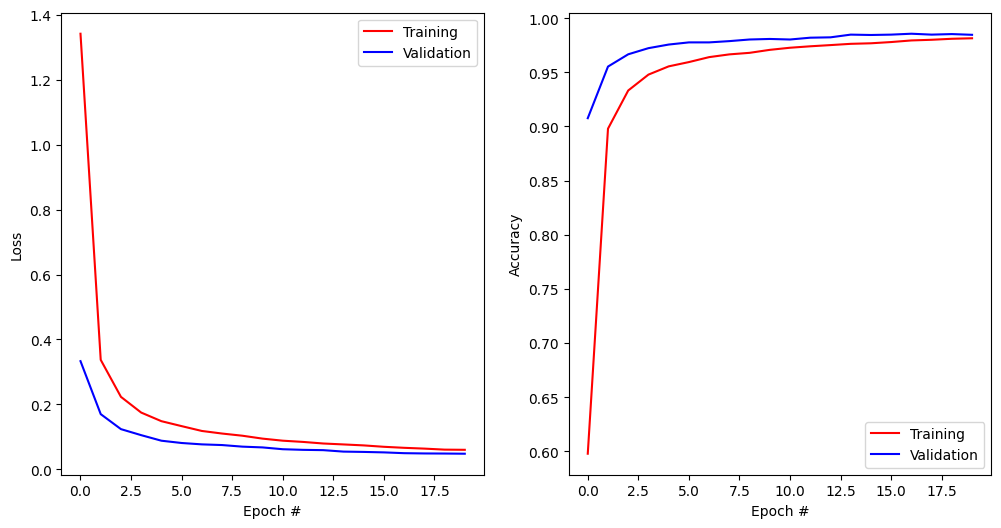

In [6]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(history.history['loss'], '-r', label="Training")
plt.plot(history.history['val_loss'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], '-r', label="Training")
plt.plot(history.history['val_accuracy'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Initialize the ANN-to-SNN converter

We now create an instance of the ANN-to-SNN conversion object. 

In [7]:
from ANNarchy.extensions.ann_to_snn_conversion import ANNtoSNNConverter

snn_converter = ANNtoSNNConverter(
    input_encoding='IB', 
    hidden_neuron='IaF',
    read_out='spike_count',
)

ANNarchy 5.0 (5.0.0) on linux (posix).


In [8]:
net = snn_converter.load_keras_model("runs/cnn.keras", show_info=True)

* Input layer: input_layer, (28, 28, 1)
* InputLayer skipped.
* Conv2D layer: conv2d, (28, 28, 16) 
* MaxPooling2D layer: max_pooling2d, (14, 14, 16) 
* Conv2D layer: conv2d_1, (14, 14, 64) 
* MaxPooling2D layer: max_pooling2d_1, (7, 7, 64) 
* Conv2D layer: conv2d_2, (7, 7, 64) 
* MaxPooling2D layer: max_pooling2d_2, (3, 3, 64) 
* Dropout skipped.
* Flatten skipped.
* Dense layer: dense, 10 
    weights: (10, 576)
    mean -0.001368094002828002, std 0.06911402940750122
    min -0.21231625974178314, max 0.2032238394021988



In [9]:
predictions_snn = snn_converter.predict(X_test[:300], duration_per_sample=200)

  0%|                                                                                         | 0/300 [00:00<?, ?it/s]

  0%|▎                                                                                | 1/300 [00:01<09:39,  1.94s/it]

  1%|▌                                                                                | 2/300 [00:03<09:38,  1.94s/it]

  1%|▊                                                                                | 3/300 [00:05<09:35,  1.94s/it]

  1%|█                                                                                | 4/300 [00:07<09:33,  1.94s/it]

  2%|█▎                                                                               | 5/300 [00:09<09:31,  1.94s/it]

  2%|█▌                                                                               | 6/300 [00:11<09:28,  1.94s/it]

  2%|█▉                                                                               | 7/300 [00:13<09:26,  1.94s/it]

  3%|██▏                                                                              | 8/300 [00:15<09:24,  1.93s/it]

  3%|██▍                                                                              | 9/300 [00:17<09:23,  1.94s/it]

  3%|██▋                                                                             | 10/300 [00:19<09:23,  1.94s/it]

  4%|██▉                                                                             | 11/300 [00:21<09:25,  1.96s/it]

  4%|███▏                                                                            | 12/300 [00:23<09:24,  1.96s/it]

  4%|███▍                                                                            | 13/300 [00:25<09:21,  1.96s/it]

  5%|███▋                                                                            | 14/300 [00:27<09:20,  1.96s/it]

  5%|████                                                                            | 15/300 [00:29<09:17,  1.96s/it]

  5%|████▎                                                                           | 16/300 [00:31<09:15,  1.96s/it]

  6%|████▌                                                                           | 17/300 [00:33<09:12,  1.95s/it]

  6%|████▊                                                                           | 18/300 [00:35<09:10,  1.95s/it]

  6%|█████                                                                           | 19/300 [00:37<09:08,  1.95s/it]

  7%|█████▎                                                                          | 20/300 [00:38<09:05,  1.95s/it]

  7%|█████▌                                                                          | 21/300 [00:40<09:03,  1.95s/it]

  7%|█████▊                                                                          | 22/300 [00:42<09:00,  1.95s/it]

  8%|██████▏                                                                         | 23/300 [00:44<09:00,  1.95s/it]

  8%|██████▍                                                                         | 24/300 [00:46<09:03,  1.97s/it]

  8%|██████▋                                                                         | 25/300 [00:48<09:05,  1.98s/it]

  9%|██████▉                                                                         | 26/300 [00:50<09:02,  1.98s/it]

  9%|███████▏                                                                        | 27/300 [00:52<08:58,  1.97s/it]

  9%|███████▍                                                                        | 28/300 [00:54<08:54,  1.97s/it]

 10%|███████▋                                                                        | 29/300 [00:56<08:51,  1.96s/it]

 10%|████████                                                                        | 30/300 [00:58<08:48,  1.96s/it]

 10%|████████▎                                                                       | 31/300 [01:00<08:45,  1.95s/it]

 11%|████████▌                                                                       | 32/300 [01:02<08:42,  1.95s/it]

 11%|████████▊                                                                       | 33/300 [01:04<08:39,  1.95s/it]

 11%|█████████                                                                       | 34/300 [01:06<08:37,  1.95s/it]

 12%|█████████▎                                                                      | 35/300 [01:08<08:34,  1.94s/it]

 12%|█████████▌                                                                      | 36/300 [01:10<08:33,  1.94s/it]

 12%|█████████▊                                                                      | 37/300 [01:12<08:30,  1.94s/it]

 13%|██████████▏                                                                     | 38/300 [01:14<08:28,  1.94s/it]

 13%|██████████▍                                                                     | 39/300 [01:16<08:26,  1.94s/it]

 13%|██████████▋                                                                     | 40/300 [01:18<08:24,  1.94s/it]

 14%|██████████▉                                                                     | 41/300 [01:19<08:21,  1.94s/it]

 14%|███████████▏                                                                    | 42/300 [01:21<08:20,  1.94s/it]

 14%|███████████▍                                                                    | 43/300 [01:23<08:19,  1.95s/it]

 15%|███████████▋                                                                    | 44/300 [01:25<08:18,  1.95s/it]

 15%|████████████                                                                    | 45/300 [01:27<08:16,  1.95s/it]

 15%|████████████▎                                                                   | 46/300 [01:29<08:14,  1.95s/it]

 16%|████████████▌                                                                   | 47/300 [01:31<08:11,  1.94s/it]

 16%|████████████▊                                                                   | 48/300 [01:33<08:09,  1.94s/it]

 16%|█████████████                                                                   | 49/300 [01:35<08:07,  1.94s/it]

 17%|█████████████▎                                                                  | 50/300 [01:37<08:05,  1.94s/it]

 17%|█████████████▌                                                                  | 51/300 [01:39<08:03,  1.94s/it]

 17%|█████████████▊                                                                  | 52/300 [01:41<08:01,  1.94s/it]

 18%|██████████████▏                                                                 | 53/300 [01:43<07:59,  1.94s/it]

 18%|██████████████▍                                                                 | 54/300 [01:45<07:57,  1.94s/it]

 18%|██████████████▋                                                                 | 55/300 [01:47<07:55,  1.94s/it]

 19%|██████████████▉                                                                 | 56/300 [01:49<07:53,  1.94s/it]

 19%|███████████████▏                                                                | 57/300 [01:51<07:51,  1.94s/it]

 19%|███████████████▍                                                                | 58/300 [01:52<07:49,  1.94s/it]

 20%|███████████████▋                                                                | 59/300 [01:54<07:48,  1.94s/it]

 20%|████████████████                                                                | 60/300 [01:56<07:47,  1.95s/it]

 20%|████████████████▎                                                               | 61/300 [01:58<07:45,  1.95s/it]

 21%|████████████████▌                                                               | 62/300 [02:00<07:43,  1.95s/it]

 21%|████████████████▊                                                               | 63/300 [02:02<07:41,  1.95s/it]

 21%|█████████████████                                                               | 64/300 [02:04<07:39,  1.95s/it]

 22%|█████████████████▎                                                              | 65/300 [02:06<07:37,  1.95s/it]

 22%|█████████████████▌                                                              | 66/300 [02:08<07:35,  1.94s/it]

 22%|█████████████████▊                                                              | 67/300 [02:10<07:32,  1.94s/it]

 23%|██████████████████▏                                                             | 68/300 [02:12<07:30,  1.94s/it]

 23%|██████████████████▍                                                             | 69/300 [02:14<07:28,  1.94s/it]

 23%|██████████████████▋                                                             | 70/300 [02:16<07:26,  1.94s/it]

 24%|██████████████████▉                                                             | 71/300 [02:18<07:24,  1.94s/it]

 24%|███████████████████▏                                                            | 72/300 [02:20<07:22,  1.94s/it]

 24%|███████████████████▍                                                            | 73/300 [02:22<07:20,  1.94s/it]

 25%|███████████████████▋                                                            | 74/300 [02:24<07:18,  1.94s/it]

 25%|████████████████████                                                            | 75/300 [02:26<07:16,  1.94s/it]

 25%|████████████████████▎                                                           | 76/300 [02:27<07:15,  1.95s/it]

 26%|████████████████████▌                                                           | 77/300 [02:29<07:14,  1.95s/it]

 26%|████████████████████▊                                                           | 78/300 [02:31<07:12,  1.95s/it]

 26%|█████████████████████                                                           | 79/300 [02:33<07:10,  1.95s/it]

 27%|█████████████████████▎                                                          | 80/300 [02:35<07:08,  1.95s/it]

 27%|█████████████████████▌                                                          | 81/300 [02:37<07:06,  1.95s/it]

 27%|█████████████████████▊                                                          | 82/300 [02:39<07:03,  1.94s/it]

 28%|██████████████████████▏                                                         | 83/300 [02:41<07:01,  1.94s/it]

 28%|██████████████████████▍                                                         | 84/300 [02:43<06:59,  1.94s/it]

 28%|██████████████████████▋                                                         | 85/300 [02:45<06:57,  1.94s/it]

 29%|██████████████████████▉                                                         | 86/300 [02:47<06:55,  1.94s/it]

 29%|███████████████████████▏                                                        | 87/300 [02:49<06:53,  1.94s/it]

 29%|███████████████████████▍                                                        | 88/300 [02:51<06:51,  1.94s/it]

 30%|███████████████████████▋                                                        | 89/300 [02:53<06:47,  1.93s/it]

 30%|████████████████████████                                                        | 90/300 [02:55<06:44,  1.92s/it]

 30%|████████████████████████▎                                                       | 91/300 [02:57<06:41,  1.92s/it]

 31%|████████████████████████▌                                                       | 92/300 [02:58<06:39,  1.92s/it]

 31%|████████████████████████▊                                                       | 93/300 [03:00<06:37,  1.92s/it]

 31%|█████████████████████████                                                       | 94/300 [03:02<06:35,  1.92s/it]

 32%|█████████████████████████▎                                                      | 95/300 [03:04<06:33,  1.92s/it]

 32%|█████████████████████████▌                                                      | 96/300 [03:06<06:32,  1.92s/it]

 32%|█████████████████████████▊                                                      | 97/300 [03:08<06:29,  1.92s/it]

 33%|██████████████████████████▏                                                     | 98/300 [03:10<06:27,  1.92s/it]

 33%|██████████████████████████▍                                                     | 99/300 [03:12<06:24,  1.91s/it]

 33%|██████████████████████████▎                                                    | 100/300 [03:14<06:22,  1.91s/it]

 34%|██████████████████████████▌                                                    | 101/300 [03:16<06:20,  1.91s/it]

 34%|██████████████████████████▊                                                    | 102/300 [03:18<06:18,  1.91s/it]

 34%|███████████████████████████                                                    | 103/300 [03:20<06:17,  1.92s/it]

 35%|███████████████████████████▍                                                   | 104/300 [03:21<06:17,  1.93s/it]

 35%|███████████████████████████▋                                                   | 105/300 [03:23<06:16,  1.93s/it]

 35%|███████████████████████████▉                                                   | 106/300 [03:25<06:17,  1.95s/it]

 36%|████████████████████████████▏                                                  | 107/300 [03:27<06:17,  1.95s/it]

 36%|████████████████████████████▍                                                  | 108/300 [03:29<06:15,  1.96s/it]

 36%|████████████████████████████▋                                                  | 109/300 [03:31<06:16,  1.97s/it]

 37%|████████████████████████████▉                                                  | 110/300 [03:33<06:14,  1.97s/it]

 37%|█████████████████████████████▏                                                 | 111/300 [03:35<06:13,  1.98s/it]

 37%|█████████████████████████████▍                                                 | 112/300 [03:37<06:11,  1.97s/it]

 38%|█████████████████████████████▊                                                 | 113/300 [03:39<06:08,  1.97s/it]

 38%|██████████████████████████████                                                 | 114/300 [03:41<06:05,  1.97s/it]

 38%|██████████████████████████████▎                                                | 115/300 [03:43<06:02,  1.96s/it]

 39%|██████████████████████████████▌                                                | 116/300 [03:45<06:00,  1.96s/it]

 39%|██████████████████████████████▊                                                | 117/300 [03:47<05:56,  1.95s/it]

 39%|███████████████████████████████                                                | 118/300 [03:49<05:53,  1.94s/it]

 40%|███████████████████████████████▎                                               | 119/300 [03:51<05:49,  1.93s/it]

 40%|███████████████████████████████▌                                               | 120/300 [03:53<05:46,  1.93s/it]

 40%|███████████████████████████████▊                                               | 121/300 [03:55<05:43,  1.92s/it]

 41%|████████████████████████████████▏                                              | 122/300 [03:57<05:40,  1.92s/it]

 41%|████████████████████████████████▍                                              | 123/300 [03:58<05:38,  1.91s/it]

 41%|████████████████████████████████▋                                              | 124/300 [04:00<05:36,  1.91s/it]

 42%|████████████████████████████████▉                                              | 125/300 [04:02<05:33,  1.91s/it]

 42%|█████████████████████████████████▏                                             | 126/300 [04:04<05:33,  1.91s/it]

 42%|█████████████████████████████████▍                                             | 127/300 [04:06<05:32,  1.92s/it]

 43%|█████████████████████████████████▋                                             | 128/300 [04:08<05:31,  1.93s/it]

 43%|█████████████████████████████████▉                                             | 129/300 [04:10<05:30,  1.93s/it]

 43%|██████████████████████████████████▏                                            | 130/300 [04:12<05:27,  1.93s/it]

 44%|██████████████████████████████████▍                                            | 131/300 [04:14<05:25,  1.93s/it]

 44%|██████████████████████████████████▊                                            | 132/300 [04:16<05:23,  1.92s/it]

 44%|███████████████████████████████████                                            | 133/300 [04:18<05:20,  1.92s/it]

 45%|███████████████████████████████████▎                                           | 134/300 [04:20<05:18,  1.92s/it]

 45%|███████████████████████████████████▌                                           | 135/300 [04:22<05:16,  1.92s/it]

 45%|███████████████████████████████████▊                                           | 136/300 [04:23<05:13,  1.91s/it]

 46%|████████████████████████████████████                                           | 137/300 [04:25<05:11,  1.91s/it]

 46%|████████████████████████████████████▎                                          | 138/300 [04:27<05:09,  1.91s/it]

 46%|████████████████████████████████████▌                                          | 139/300 [04:29<05:08,  1.92s/it]

 47%|████████████████████████████████████▊                                          | 140/300 [04:31<05:07,  1.92s/it]

 47%|█████████████████████████████████████▏                                         | 141/300 [04:33<05:05,  1.92s/it]

 47%|█████████████████████████████████████▍                                         | 142/300 [04:35<05:04,  1.93s/it]

 48%|█████████████████████████████████████▋                                         | 143/300 [04:37<05:04,  1.94s/it]

 48%|█████████████████████████████████████▉                                         | 144/300 [04:39<05:02,  1.94s/it]

 48%|██████████████████████████████████████▏                                        | 145/300 [04:41<05:00,  1.94s/it]

 49%|██████████████████████████████████████▍                                        | 146/300 [04:43<04:58,  1.94s/it]

 49%|██████████████████████████████████████▋                                        | 147/300 [04:45<04:56,  1.94s/it]

 49%|██████████████████████████████████████▉                                        | 148/300 [04:47<04:54,  1.94s/it]

 50%|███████████████████████████████████████▏                                       | 149/300 [04:49<04:52,  1.94s/it]

 50%|███████████████████████████████████████▌                                       | 150/300 [04:50<04:50,  1.94s/it]

 50%|███████████████████████████████████████▊                                       | 151/300 [04:52<04:48,  1.94s/it]

 51%|████████████████████████████████████████                                       | 152/300 [04:54<04:46,  1.94s/it]

 51%|████████████████████████████████████████▎                                      | 153/300 [04:56<04:44,  1.93s/it]

 51%|████████████████████████████████████████▌                                      | 154/300 [04:58<04:41,  1.93s/it]

 52%|████████████████████████████████████████▊                                      | 155/300 [05:00<04:39,  1.93s/it]

 52%|█████████████████████████████████████████                                      | 156/300 [05:02<04:37,  1.93s/it]

 52%|█████████████████████████████████████████▎                                     | 157/300 [05:04<04:35,  1.93s/it]

 53%|█████████████████████████████████████████▌                                     | 158/300 [05:06<04:33,  1.93s/it]

 53%|█████████████████████████████████████████▊                                     | 159/300 [05:08<04:32,  1.93s/it]

 53%|██████████████████████████████████████████▏                                    | 160/300 [05:10<04:31,  1.94s/it]

 54%|██████████████████████████████████████████▍                                    | 161/300 [05:12<04:29,  1.94s/it]

 54%|██████████████████████████████████████████▋                                    | 162/300 [05:14<04:27,  1.94s/it]

 54%|██████████████████████████████████████████▉                                    | 163/300 [05:16<04:26,  1.94s/it]

 55%|███████████████████████████████████████████▏                                   | 164/300 [05:18<04:24,  1.94s/it]

 55%|███████████████████████████████████████████▍                                   | 165/300 [05:20<04:22,  1.94s/it]

 55%|███████████████████████████████████████████▋                                   | 166/300 [05:21<04:19,  1.94s/it]

 56%|███████████████████████████████████████████▉                                   | 167/300 [05:23<04:17,  1.94s/it]

 56%|████████████████████████████████████████████▏                                  | 168/300 [05:25<04:15,  1.93s/it]

 56%|████████████████████████████████████████████▌                                  | 169/300 [05:27<04:13,  1.93s/it]

 57%|████████████████████████████████████████████▊                                  | 170/300 [05:29<04:10,  1.93s/it]

 57%|█████████████████████████████████████████████                                  | 171/300 [05:31<04:08,  1.93s/it]

 57%|█████████████████████████████████████████████▎                                 | 172/300 [05:33<04:07,  1.93s/it]

 58%|█████████████████████████████████████████████▌                                 | 173/300 [05:35<04:05,  1.93s/it]

 58%|█████████████████████████████████████████████▊                                 | 174/300 [05:37<04:03,  1.93s/it]

 58%|██████████████████████████████████████████████                                 | 175/300 [05:39<04:01,  1.93s/it]

 59%|██████████████████████████████████████████████▎                                | 176/300 [05:41<04:00,  1.94s/it]

 59%|██████████████████████████████████████████████▌                                | 177/300 [05:43<03:58,  1.94s/it]

 59%|██████████████████████████████████████████████▊                                | 178/300 [05:45<03:56,  1.94s/it]

 60%|███████████████████████████████████████████████▏                               | 179/300 [05:47<03:54,  1.94s/it]

 60%|███████████████████████████████████████████████▍                               | 180/300 [05:49<03:52,  1.94s/it]

 60%|███████████████████████████████████████████████▋                               | 181/300 [05:50<03:50,  1.94s/it]

 61%|███████████████████████████████████████████████▉                               | 182/300 [05:52<03:48,  1.94s/it]

 61%|████████████████████████████████████████████████▏                              | 183/300 [05:54<03:46,  1.93s/it]

 61%|████████████████████████████████████████████████▍                              | 184/300 [05:56<03:44,  1.93s/it]

 62%|████████████████████████████████████████████████▋                              | 185/300 [05:58<03:42,  1.93s/it]

 62%|████████████████████████████████████████████████▉                              | 186/300 [06:00<03:40,  1.93s/it]

 62%|█████████████████████████████████████████████████▏                             | 187/300 [06:02<03:39,  1.94s/it]

 63%|█████████████████████████████████████████████████▌                             | 188/300 [06:04<03:37,  1.94s/it]

 63%|█████████████████████████████████████████████████▊                             | 189/300 [06:06<03:35,  1.94s/it]

 63%|██████████████████████████████████████████████████                             | 190/300 [06:08<03:33,  1.94s/it]

 64%|██████████████████████████████████████████████████▎                            | 191/300 [06:10<03:31,  1.94s/it]

 64%|██████████████████████████████████████████████████▌                            | 192/300 [06:12<03:28,  1.93s/it]

 64%|██████████████████████████████████████████████████▊                            | 193/300 [06:14<03:27,  1.94s/it]

 65%|███████████████████████████████████████████████████                            | 194/300 [06:16<03:25,  1.94s/it]

 65%|███████████████████████████████████████████████████▎                           | 195/300 [06:18<03:23,  1.94s/it]

 65%|███████████████████████████████████████████████████▌                           | 196/300 [06:20<03:22,  1.94s/it]

 66%|███████████████████████████████████████████████████▉                           | 197/300 [06:21<03:19,  1.94s/it]

 66%|████████████████████████████████████████████████████▏                          | 198/300 [06:23<03:17,  1.94s/it]

 66%|████████████████████████████████████████████████████▍                          | 199/300 [06:25<03:15,  1.93s/it]

 67%|████████████████████████████████████████████████████▋                          | 200/300 [06:27<03:13,  1.93s/it]

 67%|████████████████████████████████████████████████████▉                          | 201/300 [06:29<03:11,  1.93s/it]

 67%|█████████████████████████████████████████████████████▏                         | 202/300 [06:31<03:09,  1.94s/it]

 68%|█████████████████████████████████████████████████████▍                         | 203/300 [06:33<03:08,  1.95s/it]

 68%|█████████████████████████████████████████████████████▋                         | 204/300 [06:35<03:06,  1.95s/it]

 68%|█████████████████████████████████████████████████████▉                         | 205/300 [06:37<03:04,  1.95s/it]

 69%|██████████████████████████████████████████████████████▏                        | 206/300 [06:39<03:02,  1.95s/it]

 69%|██████████████████████████████████████████████████████▌                        | 207/300 [06:41<03:00,  1.94s/it]

 69%|██████████████████████████████████████████████████████▊                        | 208/300 [06:43<02:58,  1.95s/it]

 70%|███████████████████████████████████████████████████████                        | 209/300 [06:45<02:57,  1.95s/it]

 70%|███████████████████████████████████████████████████████▎                       | 210/300 [06:47<02:55,  1.95s/it]

 70%|███████████████████████████████████████████████████████▌                       | 211/300 [06:49<02:53,  1.95s/it]

 71%|███████████████████████████████████████████████████████▊                       | 212/300 [06:51<02:51,  1.95s/it]

 71%|████████████████████████████████████████████████████████                       | 213/300 [06:53<02:49,  1.95s/it]

 71%|████████████████████████████████████████████████████████▎                      | 214/300 [06:55<02:47,  1.95s/it]

 72%|████████████████████████████████████████████████████████▌                      | 215/300 [06:57<02:45,  1.95s/it]

 72%|████████████████████████████████████████████████████████▉                      | 216/300 [06:58<02:43,  1.95s/it]

 72%|█████████████████████████████████████████████████████████▏                     | 217/300 [07:00<02:41,  1.95s/it]

 73%|█████████████████████████████████████████████████████████▍                     | 218/300 [07:02<02:39,  1.94s/it]

 73%|█████████████████████████████████████████████████████████▋                     | 219/300 [07:04<02:37,  1.95s/it]

 73%|█████████████████████████████████████████████████████████▉                     | 220/300 [07:06<02:35,  1.95s/it]

 74%|██████████████████████████████████████████████████████████▏                    | 221/300 [07:08<02:33,  1.95s/it]

 74%|██████████████████████████████████████████████████████████▍                    | 222/300 [07:10<02:31,  1.95s/it]

 74%|██████████████████████████████████████████████████████████▋                    | 223/300 [07:12<02:30,  1.95s/it]

 75%|██████████████████████████████████████████████████████████▉                    | 224/300 [07:14<02:28,  1.95s/it]

 75%|███████████████████████████████████████████████████████████▎                   | 225/300 [07:16<02:26,  1.95s/it]

 75%|███████████████████████████████████████████████████████████▌                   | 226/300 [07:18<02:24,  1.96s/it]

 76%|███████████████████████████████████████████████████████████▊                   | 227/300 [07:20<02:23,  1.96s/it]

 76%|████████████████████████████████████████████████████████████                   | 228/300 [07:22<02:21,  1.96s/it]

 76%|████████████████████████████████████████████████████████████▎                  | 229/300 [07:24<02:19,  1.96s/it]

 77%|████████████████████████████████████████████████████████████▌                  | 230/300 [07:26<02:17,  1.96s/it]

 77%|████████████████████████████████████████████████████████████▊                  | 231/300 [07:28<02:15,  1.96s/it]

 77%|█████████████████████████████████████████████████████████████                  | 232/300 [07:30<02:12,  1.95s/it]

 78%|█████████████████████████████████████████████████████████████▎                 | 233/300 [07:32<02:09,  1.94s/it]

 78%|█████████████████████████████████████████████████████████████▌                 | 234/300 [07:34<02:07,  1.94s/it]

 78%|█████████████████████████████████████████████████████████████▉                 | 235/300 [07:35<02:05,  1.93s/it]

 79%|██████████████████████████████████████████████████████████████▏                | 236/300 [07:37<02:03,  1.93s/it]

 79%|██████████████████████████████████████████████████████████████▍                | 237/300 [07:39<02:01,  1.92s/it]

 79%|██████████████████████████████████████████████████████████████▋                | 238/300 [07:41<01:59,  1.92s/it]

 80%|██████████████████████████████████████████████████████████████▉                | 239/300 [07:43<01:57,  1.92s/it]

 80%|███████████████████████████████████████████████████████████████▏               | 240/300 [07:45<01:55,  1.92s/it]

 80%|███████████████████████████████████████████████████████████████▍               | 241/300 [07:47<01:53,  1.92s/it]

 81%|███████████████████████████████████████████████████████████████▋               | 242/300 [07:49<01:51,  1.92s/it]

 81%|███████████████████████████████████████████████████████████████▉               | 243/300 [07:51<01:49,  1.92s/it]

 81%|████████████████████████████████████████████████████████████████▎              | 244/300 [07:53<01:47,  1.92s/it]

 82%|████████████████████████████████████████████████████████████████▌              | 245/300 [07:55<01:45,  1.92s/it]

 82%|████████████████████████████████████████████████████████████████▊              | 246/300 [07:57<01:43,  1.92s/it]

 82%|█████████████████████████████████████████████████████████████████              | 247/300 [07:59<01:41,  1.92s/it]

 83%|█████████████████████████████████████████████████████████████████▎             | 248/300 [08:00<01:39,  1.92s/it]

 83%|█████████████████████████████████████████████████████████████████▌             | 249/300 [08:02<01:37,  1.92s/it]

 83%|█████████████████████████████████████████████████████████████████▊             | 250/300 [08:04<01:35,  1.92s/it]

 84%|██████████████████████████████████████████████████████████████████             | 251/300 [08:06<01:33,  1.91s/it]

 84%|██████████████████████████████████████████████████████████████████▎            | 252/300 [08:08<01:31,  1.91s/it]

 84%|██████████████████████████████████████████████████████████████████▌            | 253/300 [08:10<01:29,  1.91s/it]

 85%|██████████████████████████████████████████████████████████████████▉            | 254/300 [08:12<01:27,  1.91s/it]

 85%|███████████████████████████████████████████████████████████████████▏           | 255/300 [08:14<01:25,  1.91s/it]

 85%|███████████████████████████████████████████████████████████████████▍           | 256/300 [08:16<01:23,  1.91s/it]

 86%|███████████████████████████████████████████████████████████████████▋           | 257/300 [08:18<01:22,  1.91s/it]

 86%|███████████████████████████████████████████████████████████████████▉           | 258/300 [08:20<01:20,  1.91s/it]

 86%|████████████████████████████████████████████████████████████████████▏          | 259/300 [08:21<01:18,  1.92s/it]

 87%|████████████████████████████████████████████████████████████████████▍          | 260/300 [08:23<01:17,  1.93s/it]

 87%|████████████████████████████████████████████████████████████████████▋          | 261/300 [08:25<01:15,  1.93s/it]

 87%|████████████████████████████████████████████████████████████████████▉          | 262/300 [08:27<01:13,  1.93s/it]

 88%|█████████████████████████████████████████████████████████████████████▎         | 263/300 [08:29<01:11,  1.93s/it]

 88%|█████████████████████████████████████████████████████████████████████▌         | 264/300 [08:31<01:09,  1.93s/it]

 88%|█████████████████████████████████████████████████████████████████████▊         | 265/300 [08:33<01:07,  1.93s/it]

 89%|██████████████████████████████████████████████████████████████████████         | 266/300 [08:35<01:05,  1.93s/it]

 89%|██████████████████████████████████████████████████████████████████████▎        | 267/300 [08:37<01:03,  1.92s/it]

 89%|██████████████████████████████████████████████████████████████████████▌        | 268/300 [08:39<01:01,  1.92s/it]

 90%|██████████████████████████████████████████████████████████████████████▊        | 269/300 [08:41<00:59,  1.92s/it]

 90%|███████████████████████████████████████████████████████████████████████        | 270/300 [08:43<00:57,  1.91s/it]

 90%|███████████████████████████████████████████████████████████████████████▎       | 271/300 [08:45<00:55,  1.91s/it]

 91%|███████████████████████████████████████████████████████████████████████▋       | 272/300 [08:46<00:53,  1.91s/it]

 91%|███████████████████████████████████████████████████████████████████████▉       | 273/300 [08:48<00:51,  1.91s/it]

 91%|████████████████████████████████████████████████████████████████████████▏      | 274/300 [08:50<00:49,  1.91s/it]

 92%|████████████████████████████████████████████████████████████████████████▍      | 275/300 [08:52<00:47,  1.91s/it]

 92%|████████████████████████████████████████████████████████████████████████▋      | 276/300 [08:54<00:46,  1.92s/it]

 92%|████████████████████████████████████████████████████████████████████████▉      | 277/300 [08:56<00:44,  1.92s/it]

 93%|█████████████████████████████████████████████████████████████████████████▏     | 278/300 [08:58<00:42,  1.92s/it]

 93%|█████████████████████████████████████████████████████████████████████████▍     | 279/300 [09:00<00:40,  1.92s/it]

 93%|█████████████████████████████████████████████████████████████████████████▋     | 280/300 [09:02<00:38,  1.92s/it]

 94%|█████████████████████████████████████████████████████████████████████████▉     | 281/300 [09:04<00:36,  1.92s/it]

 94%|██████████████████████████████████████████████████████████████████████████▎    | 282/300 [09:06<00:34,  1.93s/it]

 94%|██████████████████████████████████████████████████████████████████████████▌    | 283/300 [09:08<00:32,  1.93s/it]

 95%|██████████████████████████████████████████████████████████████████████████▊    | 284/300 [09:09<00:30,  1.93s/it]

 95%|███████████████████████████████████████████████████████████████████████████    | 285/300 [09:11<00:28,  1.93s/it]

 95%|███████████████████████████████████████████████████████████████████████████▎   | 286/300 [09:13<00:27,  1.93s/it]

 96%|███████████████████████████████████████████████████████████████████████████▌   | 287/300 [09:15<00:25,  1.93s/it]

 96%|███████████████████████████████████████████████████████████████████████████▊   | 288/300 [09:17<00:23,  1.93s/it]

 96%|████████████████████████████████████████████████████████████████████████████   | 289/300 [09:19<00:21,  1.93s/it]

 97%|████████████████████████████████████████████████████████████████████████████▎  | 290/300 [09:21<00:19,  1.93s/it]

 97%|████████████████████████████████████████████████████████████████████████████▋  | 291/300 [09:23<00:17,  1.93s/it]

 97%|████████████████████████████████████████████████████████████████████████████▉  | 292/300 [09:25<00:15,  1.94s/it]

 98%|█████████████████████████████████████████████████████████████████████████████▏ | 293/300 [09:27<00:13,  1.94s/it]

 98%|█████████████████████████████████████████████████████████████████████████████▍ | 294/300 [09:29<00:11,  1.95s/it]

 98%|█████████████████████████████████████████████████████████████████████████████▋ | 295/300 [09:31<00:09,  1.95s/it]

 99%|█████████████████████████████████████████████████████████████████████████████▉ | 296/300 [09:33<00:07,  1.94s/it]

 99%|██████████████████████████████████████████████████████████████████████████████▏| 297/300 [09:35<00:05,  1.94s/it]

 99%|██████████████████████████████████████████████████████████████████████████████▍| 298/300 [09:37<00:03,  1.94s/it]

100%|██████████████████████████████████████████████████████████████████████████████▋| 299/300 [09:39<00:01,  1.93s/it]

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [09:40<00:00,  1.93s/it]

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [09:40<00:00,  1.94s/it]

Using the recorded predictions, we can now compute the accuracy using scikit-learn for all presented samples.

In [10]:
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(t_test[:300], predictions_snn))
print("Test accuracy of the SNN:", accuracy_score(t_test[:300], predictions_snn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      0.98      0.99        41
           2       1.00      1.00      1.00        32
           3       1.00      0.96      0.98        24
           4       1.00      0.97      0.99        37
           5       1.00      1.00      1.00        29
           6       0.96      1.00      0.98        24
           7       1.00      1.00      1.00        34
           8       0.81      1.00      0.89        21
           9       1.00      0.91      0.95        34

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300

Test accuracy of the SNN: 0.98
